## Notes

We are weighting based on time (more recent reports are weighted more heavily when fitting data).

We have scant data past early November, and data around that point in time is suffereing from delays in reporting.


In [1]:
import modeller
import fitter

from functions.misc import knot_fn

import casadi as ca
import numpy as np
from matplotlib import pyplot as plt
from copy import copy
import pandas as pd

## Analysis of total cases

In [2]:
def seir(t, y, p):
    return [
        -p[1]*y[0]*y[2]/sum(y[:4]),
        p[1]*y[0]*y[2]/sum(y[:4]) - p[2]*y[1],
        p[2]*y[1] - p[0]*y[2],
        p[0]*y[2],
        p[2]*y[1]
    ]

In [3]:
cases = pd.read_csv("data/samoa_cases.csv", header=0, parse_dates=["Date"], dayfirst=True)
raw_times = cases["Date"].to_numpy()
raw_times = [(t-raw_times[0])/np.timedelta64(1,'D') for t in raw_times] # convert to days since first timestamp
raw_data = cases['Cases'].to_numpy()
raw_cumdata = np.cumsum(raw_data)

In [4]:
start = 1
clip = 5
times = raw_times[start:(-clip if clip else None)]
data = raw_data[start:(-clip if clip else None)]
cumdata = raw_cumdata[start:(-clip if clip else None)]

In [5]:
additional_times = [33,35,56,60,68, 75,83,86,87,89,90,91,92, 93,94,95]
additional_cumdata = [28,36,169,314,513, 716,1174,1644,1797,2194,2437,2686,2936, 3149,3357,3530]

# times = times + additional_times
# cumdata = np.concatenate([cumdata,additional_cumdata])
times = np.array(additional_times)
cumdata = np.array(additional_cumdata)

Text(0.5, 0, 'Days after 28 August 2019')

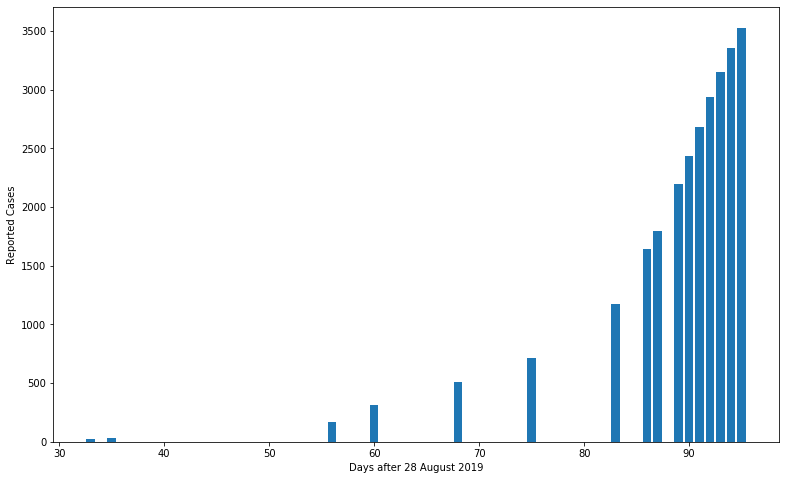

In [6]:
plt.figure(figsize=[13,8])
plt.bar(times, cumdata)
plt.ylabel("Reported Cases")
plt.xlabel("Days after 28 August 2019")

In [7]:
data_pd = np.array([[i] for i in cumdata])
p0 = [1/8, 1, 1/8]
config = {
    "grid_size": 100,
    "basis_number": 24,
    "model_form": {
        "state": 5,
        "parameters": 3
    },
    "time_span": [times[0], 130],
    "knot_function": None,
    "model": seir,
    "dataset": {"y": data_pd, "t": np.array(times)},
    "observation_vector": [-1],
    "weightings":[
        [1]*5,
        np.sqrt(times/np.mean(times))
    ],
    "regularisation_value": copy(p0),
}

In [8]:
model = modeller.Model(config)
config['regularisation_value'][1] = model.ps[1]
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}
ipopt_opts = {
    'ipopt': {
        'print_level': 5,
        'print_frequency_iter': 10,
        
    }
}

solver = ca.nlpsol('solver', 'ipopt', solver_setup, ipopt_opts)

In [9]:
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getp = ca.Function('getx', [solver_setup['x']], model.ps)


In [10]:
c0 = [max(cumdata)*np.ones(config['basis_number']) for _ in range(5)]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*5) + [0]*len(config['regularisation_value'])
alpha = 1e3

In [11]:
pure_solve = solver(x0=x0, p=[0, 0], lbx=lbx, lbg=0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1835

Total number of variables............................:      123
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

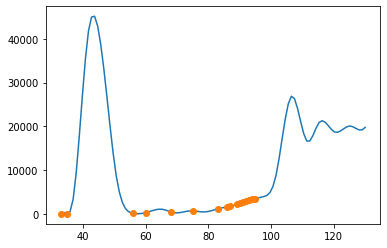

In [12]:
pure_xs = getx(pure_solve['x'])
plt.plot(model.observation_times, pure_xs[-1])
plt.plot(times, cumdata, 'o')

In [13]:
lbg = [0]*len(model.observation_times)*config['model_form']['state']
ubg = [140000]*len(model.observation_times)*config['model_form']['state']
# lbg[0] = 150000

In [14]:
prange = np.logspace(-6, 6, num=100)
sols = []
xguess = x0
for p in prange:
    solve_opts = {
        'x0': xguess,
        'p': [p, alpha],
        'lbx': lbx,
        'lbg': lbg,
        'ubg': ubg
    }
    print(f"Solving for p={p}")
    sols.append(solver(**solve_opts))
    xguess = np.array(sols[-1]['x']).flatten()

Solving for p=1e-06
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1835

Total number of variables............................:      123
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du


Number of Iterations....: 69

                                   (scaled)                 (unscaled)
Objective...............:   6.7655191136543777e+00    6.7655191136543777e+00
Dual infeasibility......:   4.4039421096576718e-09    4.4039421096576718e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800626e-09    2.5059035596800626e-09
Overall NLP error.......:   4.4039421096576718e-09    4.4039421096576718e-09


Number of objective function evaluations             = 98
Number of objective gradient evaluations             = 70
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 98
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 70
Number of Lagrangian Hessian evaluations             = 69
Total CPU secs in IPOPT (w/o function evaluations)   =      0.131
Total CPU secs in NLP function evaluation


Number of Iterations....: 67

                                   (scaled)                 (unscaled)
Objective...............:   6.7680944929234705e+00    6.7680944929234705e+00
Dual infeasibility......:   1.5266206815554614e-10    1.5266206815554614e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059036333727525e-09    2.5059036333727525e-09
Overall NLP error.......:   2.5059036333727525e-09    2.5059036333727525e-09


Number of objective function evaluations             = 95
Number of objective gradient evaluations             = 68
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 95
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 68
Number of Lagrangian Hessian evaluations             = 67
Total CPU secs in IPOPT (w/o function evaluations)   =      0.119
Total CPU secs in NLP function evaluation

  50  6.7774564e+00 0.00e+00 2.67e-02  -8.6 7.46e+04 -13.9 1.00e+00 1.91e-01f  2
  60  6.7743744e+00 0.00e+00 1.37e-02  -8.6 1.04e+03 -12.4 1.00e+00 1.00e+00f  1
  70  6.7740477e+00 0.00e+00 1.65e-03  -8.6 1.36e+04    -  1.00e+00 5.00e-01h  2
  80  6.7740428e+00 0.00e+00 8.94e-08  -8.6 3.14e+02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 82

                                   (scaled)                 (unscaled)
Objective...............:   6.7740428260592473e+00    6.7740428260592473e+00
Dual infeasibility......:   8.5734600250526218e-13    8.5734600250526218e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596809663e-09    2.5059035596809663e-09
Overall NLP error.......:   2.5059035596809663e-09    2.5059035596809663e-09


Number of objective function evaluations             = 131
Number of objective gradient evaluations             = 83
Number of equality constraint evaluations            = 0
Number of ine

  10  7.0061349e+00 0.00e+00 6.83e-01  -2.5 7.93e+03    -  7.41e-01 1.00e+00f  1
  20  6.7986317e+00 0.00e+00 9.12e-07  -5.7 2.46e-01  -5.4 1.00e+00 1.00e+00h  1
  30  6.7978986e+00 0.00e+00 1.14e-04  -8.6 5.95e+01 -10.2 1.00e+00 1.00e+00h  1
  40  6.7964414e+00 0.00e+00 8.16e-02  -8.6 1.22e+03 -12.3 1.00e+00 1.00e+00f  1
  50  6.7900176e+00 0.00e+00 9.45e-02  -8.6 3.91e+02  -9.8 8.66e-01 1.00e+00f  1
  60  6.7877881e+00 0.00e+00 6.86e-04  -8.6 6.50e+02 -14.1 1.00e+00 1.00e+00h  1
  70  6.7877785e+00 0.00e+00 5.66e-06  -8.6 1.21e+03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 71

                                   (scaled)                 (unscaled)
Objective...............:   6.7877784921172806e+00    6.7877784921172806e+00
Dual infeasibility......:   7.4470754061328805e-09    7.4470754061328805e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5111040017807372e-09    2.5111040017807372e-09
Overall NLP error......

  50  6.8194793e+00 0.00e+00 3.39e-06  -8.6 8.84e+02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 52

                                   (scaled)                 (unscaled)
Objective...............:   6.8194793337542663e+00    6.8194793337542663e+00
Dual infeasibility......:   7.9820525537853515e-12    7.9820525537853515e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5085359807494827e-09    2.5085359807494827e-09
Overall NLP error.......:   2.5085359807494827e-09    2.5085359807494827e-09


Number of objective function evaluations             = 68
Number of objective gradient evaluations             = 53
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 68
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 53
Number of Lagrangian Hessian evaluations             = 52
Total CPU secs in IPOPT (w

  30  6.9435582e+00 0.00e+00 3.20e-01  -5.7 1.18e+03 -11.2 1.00e+00 1.00e+00f  1
  40  6.9254224e+00 0.00e+00 4.46e-01  -5.7 3.29e+03 -12.3 1.00e+00 1.00e+00f  1
  50  6.8932292e+00 0.00e+00 2.99e-02  -5.7 1.39e+04 -13.5 1.00e+00 5.00e-01f  2
  60  6.8925806e+00 0.00e+00 2.72e-04  -5.7 2.73e+03    -  1.00e+00 1.00e+00h  1
  70  6.8925519e+00 0.00e+00 1.06e-09  -8.6 5.93e+01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 70

                                   (scaled)                 (unscaled)
Objective...............:   6.8925519088837106e+00    6.8925519088837106e+00
Dual infeasibility......:   1.0590376008016589e-09    1.0590376008016589e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.3162235365445279e-09    3.3162235365445279e-09
Overall NLP error.......:   3.3162235365445279e-09    3.3162235365445279e-09


Number of objective function evaluations             = 120
Number of objective gradient evaluations       

  10  7.3559306e+00 0.00e+00 3.51e+00  -2.5 2.67e+03    -  6.48e-01 1.00e+00f  1
  20  7.2347386e+00 0.00e+00 1.50e-04  -5.7 2.89e+00  -5.4 9.98e-01 1.00e+00f  1
  30  7.1799756e+00 0.00e+00 5.34e-02  -5.7 2.69e+02 -10.2 1.00e+00 1.00e+00f  1
  40  7.1348204e+00 0.00e+00 8.64e-01  -5.7 1.61e+04 -12.3 1.00e+00 1.47e-01f  3
  50  7.0635613e+00 0.00e+00 2.06e-01  -5.7 1.77e+03 -11.6 1.00e+00 1.00e+00f  1
  60  7.0605519e+00 0.00e+00 8.44e-05  -5.7 1.45e+03    -  1.00e+00 1.00e+00h  1
  70  7.0605168e+00 0.00e+00 8.70e-10  -8.6 4.66e+01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 70

                                   (scaled)                 (unscaled)
Objective...............:   7.0605167575012064e+00    7.0605167575012064e+00
Dual infeasibility......:   8.7005606084570699e-10    8.7005606084570699e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   5.1551340965176021e-09    5.1551340965176021e-09
Overall NLP error......

  30  7.5481602e+00 0.00e+00 4.04e+00  -5.7 8.25e+03 -11.6 7.96e-01 1.28e-01f  2
  40  7.4442719e+00 0.00e+00 4.19e-02  -5.7 6.50e+03    -  1.00e+00 1.00e+00h  1
  50  7.4442158e+00 0.00e+00 3.88e-06  -8.6 6.90e+01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 51

                                   (scaled)                 (unscaled)
Objective...............:   7.4442157658218804e+00    7.4442157658218804e+00
Dual infeasibility......:   2.6674919399932790e-09    2.6674919399932790e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   4.8887234346931803e-09    4.8887234346931803e-09
Overall NLP error.......:   4.8887234346931803e-09    4.8887234346931803e-09


Number of objective function evaluations             = 65
Number of objective gradient evaluations             = 52
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 65
Number of equality constraint Jacobia

  40  8.3095927e+00 0.00e+00 3.10e-03  -8.6 8.41e+03    -  1.00e+00 6.12e-01h  1

Number of Iterations....: 43

                                   (scaled)                 (unscaled)
Objective...............:   8.3095927088600945e+00    8.3095927088600945e+00
Dual infeasibility......:   9.9926633970369836e-10    9.9926633970369836e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.3677083537825208e-09    3.3677083537825208e-09
Overall NLP error.......:   3.3677083537825208e-09    3.3677083537825208e-09


Number of objective function evaluations             = 58
Number of objective gradient evaluations             = 44
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 58
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 44
Number of Lagrangian Hessian evaluations             = 43
Total CPU secs in IPOPT (w

  20  2.4582548e+01 0.00e+00 2.12e+02  -1.0 1.99e+04    -  8.78e-01 5.00e-01f  2
  30  2.7509230e+01 0.00e+00 1.23e+02  -1.0 2.36e+04    -  8.48e-01 2.50e-01f  3
  40  3.2349414e+01 0.00e+00 7.04e+02  -1.0 2.19e+04    -  1.00e+00 5.00e-01f  2
  50  3.7280445e+01 0.00e+00 9.06e+02  -1.0 3.16e+04  -9.3 3.65e-01 9.26e-02f  3
  60  3.9988361e+01 0.00e+00 1.94e+02  -1.0 6.47e+05    -  1.56e-02 1.44e-03f  5
  70  4.2409598e+01 0.00e+00 5.27e+02  -1.0 1.64e+04    -  1.00e+00 1.25e-01f  4
  80  4.4257235e+01 0.00e+00 5.78e+02  -1.0 4.19e+03  -9.3 1.00e+00 1.00e+00f  1
  90  4.5173220e+01 0.00e+00 1.66e+03  -1.0 4.58e+03  -9.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.5710975e+01 0.00e+00 1.29e+03  -1.0 7.39e+03    -  1.00e+00 1.00e+00f  1
 110  4.4035169e+01 0.00e+00 1.04e+02  -2.5 1.87e+03  -8.8 1.00e+00 1.00e+00f  1
 120  4.2069995e+01 0.00e+00 5.25e+02  -2.5 1.77e+05 -10.8 6.60e-02 3.23e-02f  4
 130  4.0544510e+01 0.00e+00

  90  1.3118513e+01 0.00e+00 1.54e+01  -3.8 1.30e+03  -9.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.1472203e+01 0.00e+00 7.61e+00  -3.8 2.45e+02    -  7.11e-01 1.00e+00f  1
 110  1.1268860e+01 0.00e+00 3.04e+00  -3.8 1.14e+02  -7.8 1.00e+00 1.00e+00f  1
 120  1.1260947e+01 0.00e+00 4.62e-04  -3.8 3.16e+02    -  1.00e+00 1.00e+00h  1
 130  1.1257922e+01 0.00e+00 3.93e-03  -8.6 4.88e+01    -  1.00e+00 5.00e-01f  2

Number of Iterations....: 132

                                   (scaled)                 (unscaled)
Objective...............:   1.1257922379349427e+01    1.1257922379349427e+01
Dual infeasibility......:   1.9644927849138123e-09    1.9644927849138123e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.8345166639688947e-09    2.8345166639688947e-09
Overall NLP error.......:   2.8345166639688947e-09    2.8345166639688947e-09


Number of objective func

 130  1.7704126e+01 0.00e+00 1.26e+01  -2.5 1.02e+04 -10.9 1.00e+00 6.99e-02f  4
 140  1.6089372e+01 0.00e+00 2.09e+01  -2.5 1.74e+03 -10.2 1.00e+00 1.00e+00f  1
 150  1.4604447e+01 0.00e+00 1.49e+01  -2.5 6.78e+04    -  7.41e-01 5.00e-01f  2
 160  1.4314178e+01 0.00e+00 3.87e-02  -3.8 2.84e+01 -11.4 1.00e+00 1.00e+00f  1
 170  1.4311030e+01 0.00e+00 2.23e-04  -5.7 8.46e+02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 176

                                   (scaled)                 (unscaled)
Objective...............:   1.4310910778653781e+01    1.4310910778653781e+01
Dual infeasibility......:   1.8912020553415048e-10    1.8912020553415048e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.6213378571499628e-09    2.6213378571499628e-09
Overall NLP error.......:   2.6213378571499628e-09    2.6213378571499628e-09


Number of objective function evaluations             = 382
Number of objective gradient evaluations      

 150  1.9300287e+01 0.00e+00 1.30e-05  -5.7 4.83e+01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 154

                                   (scaled)                 (unscaled)
Objective...............:   1.9300161029793539e+01    1.9300161029793539e+01
Dual infeasibility......:   1.7088175792144339e-09    1.7088175792144339e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   7.1953760064036998e-09    7.1953760064036998e-09
Overall NLP error.......:   7.1953760064036998e-09    7.1953760064036998e-09


Number of objective function evaluations             = 290
Number of objective gradient evaluations             = 155
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 290
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 155
Number of Lagrangian Hessian evaluations             = 154
Total CPU secs in IP

  30  3.2841833e+01 0.00e+00 1.94e+00  -5.7 3.64e+04    -  1.00e+00 5.00e-01f  2
  40  3.2840667e+01 0.00e+00 3.47e-08  -8.6 9.46e+00    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 41

                                   (scaled)                 (unscaled)
Objective...............:   3.2840667058793912e+01    3.2840667058793912e+01
Dual infeasibility......:   9.6009938250305076e-12    9.6009938250305076e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5514759627906486e-09    2.5514759627906486e-09
Overall NLP error.......:   2.5514759627906486e-09    2.5514759627906486e-09


Number of objective function evaluations             = 60
Number of objective gradient evaluations             = 42
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 60
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 42
Num

  20  5.7565370e+01 0.00e+00 1.62e+00  -5.7 2.89e+04    -  1.00e+00 5.00e-01f  2

Number of Iterations....: 29

                                   (scaled)                 (unscaled)
Objective...............:   5.7564057800072845e+01    5.7564057800072845e+01
Dual infeasibility......:   2.5932618445270360e-09    2.5932618445270360e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   4.7420439218837434e-09    4.7420439218837434e-09
Overall NLP error.......:   4.7420439218837434e-09    4.7420439218837434e-09


Number of objective function evaluations             = 41
Number of objective gradient evaluations             = 30
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 41
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 30
Number of Lagrangian Hessian evaluations             = 29
Total CPU secs in IPOPT (w

  40  1.1051156e+02 0.00e+00 4.92e-07  -8.6 1.84e+00    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 41

                                   (scaled)                 (unscaled)
Objective...............:   1.1051156211735828e+02    1.1051156211735828e+02
Dual infeasibility......:   3.1374315305837992e-10    3.1374315305837992e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.5574167370357481e-09    3.5574167370357481e-09
Overall NLP error.......:   3.5574167370357481e-09    3.5574167370357481e-09


Number of objective function evaluations             = 56
Number of objective gradient evaluations             = 42
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 56
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 42
Number of Lagrangian Hessian evaluations             = 41
Total CPU secs in IPOPT (w

  10  1.8286808e+02 0.00e+00 5.93e+02  -1.7 6.21e+03    -  8.11e-01 5.00e-01f  2
  20  1.8145572e+02 0.00e+00 1.80e+00  -3.8 1.02e+04    -  1.00e+00 1.00e+00f  1
  30  1.8145350e+02 0.00e+00 8.45e-03  -5.7 7.20e+02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 34

                                   (scaled)                 (unscaled)
Objective...............:   1.8145338253496195e+02    1.8145338253496195e+02
Dual infeasibility......:   1.1156570849429518e-09    1.1156570849429518e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   6.0106415032920323e-09    6.0106415032920323e-09
Overall NLP error.......:   6.0106415032920323e-09    6.0106415032920323e-09


Number of objective function evaluations             = 39
Number of objective gradient evaluations             = 35
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 39
Number of equality constraint Jacobia

  10  2.5888766e+02 0.00e+00 2.73e-01  -1.0 9.78e-01  -4.0 1.00e+00 1.00e+00f  1
  20  2.5674484e+02 0.00e+00 4.39e-05  -3.8 1.97e+00  -7.3 1.00e+00 1.00e+00f  1
  30  2.5652465e+02 0.00e+00 7.68e+00  -5.7 2.35e+01    -  1.00e+00 7.81e-03f  8

Number of Iterations....: 36

                                   (scaled)                 (unscaled)
Objective...............:   2.5652421366159609e+02    2.5652421366159609e+02
Dual infeasibility......:   2.7475636000543283e-11    2.7475636000543283e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0935667546389470e-10    9.0935667546389470e-10
Overall NLP error.......:   9.0935667546389470e-10    9.0935667546389470e-10


Number of objective function evaluations             = 45
Number of objective gradient evaluations             = 37
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 45
Number of equality constraint Jacobia

  40  3.8060173e+02 0.00e+00 3.06e-01  -8.6 8.95e+01  -8.6 1.00e+00 1.00e+00f  1
  50  3.7986258e+02 0.00e+00 9.07e+01  -8.6 8.02e+03  -8.9 1.00e+00 6.45e-02f  3
  60  3.7937615e+02 0.00e+00 2.77e-07  -8.6 1.96e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 61

                                   (scaled)                 (unscaled)
Objective...............:   3.7937615468340300e+02    3.7937615468340300e+02
Dual infeasibility......:   2.7801522235137550e-11    2.7801522235137550e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035711856519e-09    2.5059035711856519e-09
Overall NLP error.......:   2.5059035711856519e-09    2.5059035711856519e-09


Number of objective function evaluations             = 85
Number of objective gradient evaluations             = 62
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 85
Number of equality constraint Jacobia

  40  5.9305277e+02 0.00e+00 2.12e+02  -5.7 9.12e+03 -10.5 1.00e+00 5.00e-01f  2
  50  5.9209685e+02 0.00e+00 7.95e+01  -5.7 1.92e+02  -8.0 1.00e+00 1.00e+00f  1
  60  5.9054232e+02 0.00e+00 4.70e+01  -5.7 6.76e+02  -8.3 1.00e+00 1.00e+00f  1
  70  5.8881545e+02 0.00e+00 1.86e-01  -5.7 4.59e-01    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 73

                                   (scaled)                 (unscaled)
Objective...............:   5.2788271569704432e+02    5.8881544565070624e+02
Dual infeasibility......:   6.7972327831653519e-11    7.5818274237795933e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5060164790860978e-09    2.7952822967364236e-09
Overall NLP error.......:   2.5060164790860978e-09    2.7952822967364236e-09


Number of objective function evaluations             = 98
Number of objective gradient evaluations             = 74
Number of equality constraint evaluations            = 0
Number of ineq


Number of Iterations....: 59

                                   (scaled)                 (unscaled)
Objective...............:   5.5394971545493866e+02    9.2626662374761975e+02
Dual infeasibility......:   7.2991280535118946e-11    1.2204968266615113e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059271468969061e-09    4.1901938261804537e-09
Overall NLP error.......:   2.5059271468969061e-09    4.1901938261804537e-09


Number of objective function evaluations             = 84
Number of objective gradient evaluations             = 60
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 84
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 60
Number of Lagrangian Hessian evaluations             = 59
Total CPU secs in IPOPT (w/o function evaluations)   =      0.112
Total CPU secs in NLP function evaluation

  40  1.6494736e+03 0.00e+00 2.52e+02  -2.5 6.19e+00  -4.6 1.00e+00 1.00e+00f  1
  50  1.6450399e+03 0.00e+00 1.53e+01  -2.5 1.60e+00  -4.9 1.00e+00 1.00e+00f  1
  60  1.6398527e+03 0.00e+00 9.00e-01  -2.5 1.35e+01    -  8.31e-01 1.00e+00f  1

Number of Iterations....: 69

                                   (scaled)                 (unscaled)
Objective...............:   6.3899402594099388e+02    1.6397337619908030e+03
Dual infeasibility......:   1.4366386837935752e-10    3.6865836893064874e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059065026322262e-09    6.4304505675265766e-09
Overall NLP error.......:   2.5059065026322262e-09    6.4304505675265766e-09


Number of objective function evaluations             = 85
Number of objective gradient evaluations             = 70
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 85
Number of equality constraint Jacobia

  30  2.3995898e+03 0.00e+00 2.40e-07  -8.6 3.26e-03    -  1.00e+00 9.99e-01h  1

Number of Iterations....: 31

                                   (scaled)                 (unscaled)
Objective...............:   7.4376471298718093e+02    2.3995898122362300e+03
Dual infeasibility......:   1.9363450459318967e-10    6.2471824275325062e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059062996133532e-09    8.0847439008234206e-09
Overall NLP error.......:   2.5059062996133532e-09    8.0847439008234206e-09


Number of objective function evaluations             = 39
Number of objective gradient evaluations             = 32
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 39
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 32
Number of Lagrangian Hessian evaluations             = 31
Total CPU secs in IPOPT (w


Number of Iterations....: 34

                                   (scaled)                 (unscaled)
Objective...............:   8.9030968922156853e+02    3.3235365857632696e+03
Dual infeasibility......:   3.1355547173036773e-10    1.1705062795321217e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059081199320281e-09    9.3545846102576385e-09
Overall NLP error.......:   2.5059081199320281e-09    9.3545846102576385e-09


Number of objective function evaluations             = 45
Number of objective gradient evaluations             = 35
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 45
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 35
Number of Lagrangian Hessian evaluations             = 34
Total CPU secs in IPOPT (w/o function evaluations)   =      0.053
Total CPU secs in NLP function evaluation

  10  4.3081100e+03 0.00e+00 5.60e+00  -1.0 2.58e-01  -3.1 1.00e+00 1.00e+00f  1
  20  4.3097381e+03 0.00e+00 3.32e+02  -1.7 2.41e+03    -  1.00e+00 1.25e-01f  4
  30  4.3128066e+03 0.00e+00 1.07e+03  -1.7 3.82e+03    -  1.00e+00 1.00e+00f  1
  40  4.3157677e+03 0.00e+00 5.40e+02  -2.5 2.99e+04    -  8.78e-01 1.06e-01f  4
  50  4.3155230e+03 0.00e+00 6.57e-01  -2.5 5.07e+01  -8.3 1.00e+00 1.00e+00f  1
  60  4.3150068e+03 0.00e+00 1.45e+00  -2.5 1.40e+01  -7.6 1.00e+00 1.00e+00f  1
  70  4.3144061e+03 0.00e+00 5.02e-01  -2.5 1.06e+00  -6.1 1.00e+00 1.00e+00f  1
  80  4.3137321e+03 0.00e+00 1.30e+02  -2.5 6.76e+02  -9.0 1.00e+00 5.00e-01f  2
  90  4.3129300e+03 0.00e+00 1.97e+02  -2.5 6.03e+00  -6.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.3120943e+03 0.00e+00 1.75e+00  -2.5 1.92e+00  -5.9 1.00e+00 1.00e+00f  1
 110  4.3112416e+03 0.00e+00 1.02e+02  -3.8 1.67e+02  -8.0 1.00e+00 1.00e+00f  1
 120  4.3107514e+03 0.00e+00

  40  4.9022909e+03 0.00e+00 5.83e+00  -3.8 1.95e+00  -4.9 1.00e+00 1.00e+00f  1
  50  4.9020465e+03 0.00e+00 6.98e+01  -3.8 1.41e+00  -5.2 1.00e+00 1.00e+00f  1
  60  4.9016542e+03 0.00e+00 5.72e+00  -3.8 2.18e-01  -4.5 1.00e+00 1.00e+00f  1
  70  4.9013102e+03 0.00e+00 1.46e+02  -3.8 1.06e+03  -9.3 1.00e+00 1.00e+00f  1
  80  4.9011310e+03 0.00e+00 9.48e+00  -3.8 2.55e+02  -8.7 1.00e+00 1.00e+00f  1
  90  4.9006860e+03 0.00e+00 2.81e+01  -3.8 5.32e+02  -8.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.9002280e+03 0.00e+00 1.30e+00  -3.8 1.39e+02  -8.3 1.00e+00 1.00e+00f  1
 110  4.8998432e+03 0.00e+00 9.08e+00  -3.8 2.79e+02  -8.5 1.00e+00 1.00e+00f  1
 120  4.8994590e+03 0.00e+00 9.11e-01  -3.8 8.87e+00  -7.0 1.00e+00 1.00e+00f  1
 130  4.8990176e+03 0.00e+00 1.56e+00  -3.8 1.41e+02  -8.1 1.00e+00 1.00e+00f  1
 140  4.8985805e+03 0.00e+00 1.02e+00  -3.8 4.63e+00  -6.6 1.00e+00 1.00e+00f  1
 150  4.8981497e+03 0.00e+00

  80  5.3494666e+03 0.00e+00 3.99e+02  -2.5 1.42e+01  -6.6 1.00e+00 2.50e-01f  3
  90  5.3494066e+03 0.00e+00 2.99e+00  -2.5 7.56e-01  -6.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.3493135e+03 0.00e+00 2.71e+01  -2.5 3.67e-01  -5.3 1.00e+00 1.00e+00f  1
 110  5.3492511e+03 0.00e+00 5.40e+01  -3.8 5.33e-01  -5.6 1.00e+00 1.00e+00f  1
 120  5.3491684e+03 0.00e+00 1.92e-02  -3.8 5.68e-02  -4.9 1.00e+00 1.00e+00h  1
 130  5.3490752e+03 0.00e+00 8.58e-01  -3.8 7.17e-02  -5.2 1.00e+00 1.00e+00f  1
 140  5.3489754e+03 0.00e+00 3.49e+00  -3.8 1.40e-01  -5.4 1.00e+00 1.00e+00f  1
 150  5.3488371e+03 0.00e+00 2.37e-01  -3.8 3.68e-02  -4.8 1.00e+00 1.00e+00h  1
 160  5.3487278e+03 0.00e+00 1.11e+00  -3.8 7.09e-02  -5.0 1.00e+00 1.00e+00f  1
 170  5.3486295e+03 0.00e+00 3.55e+01  -3.8 8.58e-01  -6.2 1.00e+00 1.00e+00f  1
 180  5.3484891e+03 0.00e+00 1.95e+00  -3.8 1.87e+00  -6.5 1.00e+00 1.00e+00f  1
 190  5.3483447e+03 0.00e+00

 490  5.4999310e+03 0.00e+00 2.79e-01  -3.8 2.41e+00  -7.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  5.4999002e+03 0.00e+00 2.10e-01  -3.8 6.10e-01  -6.7 1.00e+00 1.00e+00h  1
 510  5.4998681e+03 0.00e+00 5.08e+00  -3.8 1.56e-01  -5.2 1.00e+00 1.00e+00h  1
 520  5.4998434e+03 0.00e+00 1.79e+02  -3.8 2.34e+03 -10.0 1.00e+00 6.25e-02f  5
 530  5.4998157e+03 0.00e+00 6.50e+01  -3.8 4.55e-01  -4.8 1.00e+00 1.00e+00f  1
 540  5.4997864e+03 0.00e+00 9.19e+01  -3.8 4.71e+02  -9.6 1.00e+00 1.00e+00f  1
 550  5.4997724e+03 0.00e+00 3.01e+00  -3.8 1.37e+01  -8.0 1.00e+00 1.00e+00f  1
 560  5.4997403e+03 0.00e+00 1.71e+00  -3.8 2.59e+01  -8.3 1.00e+00 1.00e+00f  1
 570  5.4997150e+03 0.00e+00 7.25e-01  -3.8 4.85e+01  -8.5 1.00e+00 1.00e+00f  1
 580  5.4996839e+03 0.00e+00 1.26e-01  -3.8 1.15e+01  -7.9 1.00e+00 1.00e+00f  1
 590  5.4996518e+03 0.00e+00 1.25e+00  -3.8 2.83e+00  -7.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 330  5.6062295e+03 0.00e+00 3.83e+02  -3.8 1.26e+03 -10.2 1.00e+00 1.25e-01f  4
 340  5.6062244e+03 0.00e+00 1.19e+01  -3.8 1.91e+02  -9.5 1.00e+00 1.00e+00f  1
 350  5.6062185e+03 0.00e+00 7.00e-01  -3.8 4.41e+01  -8.9 1.00e+00 1.00e+00f  1
 360  5.6062076e+03 0.00e+00 1.55e+00  -3.8 8.33e+01  -9.1 1.00e+00 1.00e+00f  1
 370  5.6062002e+03 0.00e+00 6.77e-02  -3.8 1.94e+01  -8.5 1.00e+00 1.00e+00f  1
 380  5.6061910e+03 0.00e+00 1.17e-01  -3.8 4.54e+00  -7.8 1.00e+00 1.00e+00f  1
 390  5.6061804e+03 0.00e+00 3.03e-02  -3.8 8.52e+00  -8.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  5.6061714e+03 0.00e+00 3.37e-01  -3.8 2.01e+00  -7.4 1.00e+00 1.00e+00h  1
 410  5.6061614e+03 0.00e+00 1.04e+00  -3.8 5.15e-01  -6.8 1.00e+00 1.00e+00h  1
 420  5.6061503e+03 0.00e+00 1.17e+00  -3.8 7.06e+00  -8.0 1.00e+00 1.00e+00f  1
 430  5.6061418e+03 0.00e+00 1.49e-01  -3.8 1.31e+01  -8.2 1.00e+00 1.00e+00f  1
 440  5.6061300e+03 0.00e+00

 160  5.6882711e+03 0.00e+00 2.45e+03  -1.7 1.39e+00  -5.0 1.00e+00 1.00e+00f  1
 170  5.6883059e+03 0.00e+00 1.89e-01  -1.7 1.43e-02  -3.3 1.00e+00 1.00e+00f  1
 180  5.6882599e+03 0.00e+00 7.10e+03  -2.5 9.44e+00  -6.6 1.00e+00 1.00e+00f  1
 190  5.6882319e+03 0.00e+00 1.72e+03  -2.5 6.46e+00  -6.9 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  5.6882414e+03 0.00e+00 1.92e+03  -2.5 2.01e+04    -  1.00e+00 6.25e-02f  5
 210  5.6882849e+03 0.00e+00 3.42e+00  -2.5 6.82e-02  -4.5 1.00e+00 1.00e+00f  1
 220  5.6883519e+03 0.00e+00 1.40e-04  -2.5 7.51e-04  -6.0 1.00e+00 1.00e+00f  1
 230  5.6883452e+03 0.00e+00 1.38e-02  -3.8 2.88e+00  -8.5 1.00e+00 1.00e+00h  1
 240  5.6883430e+03 0.00e+00 3.61e+02  -3.8 5.31e+00  -7.0 1.00e+00 1.25e-01f  4
 250  5.6883384e+03 0.00e+00 3.26e+00  -3.8 4.99e-02  -5.4 1.00e+00 1.00e+00f  1
 260  5.6883377e+03 0.00e+00 3.96e-01  -5.7 1.62e+02 -10.2 1.00e+00 1.00e+00f  1
 270  5.6883353e+03 0.00e+00

1150  5.6879666e+03 0.00e+00 6.03e-01  -5.7 8.37e+00  -7.7 1.00e+00 1.00e+00f  1
1160  5.6879587e+03 0.00e+00 8.86e-01  -5.7 1.55e+01  -7.9 1.00e+00 1.00e+00f  1
1170  5.6879500e+03 0.00e+00 2.35e+00  -5.7 2.90e+01  -8.2 1.00e+00 1.00e+00f  1
1180  5.6879418e+03 0.00e+00 9.61e-01  -5.7 6.74e+00  -7.5 1.00e+00 1.00e+00f  1
1190  5.6879321e+03 0.00e+00 2.08e+00  -5.7 1.61e+00  -6.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  5.6879210e+03 0.00e+00 7.94e+00  -5.7 2.37e+01  -8.0 1.00e+00 1.00e+00f  1
1210  5.6879145e+03 0.00e+00 5.66e+00  -5.7 4.36e+01  -8.3 1.00e+00 1.00e+00f  1
1220  5.6878993e+03 0.00e+00 2.40e+02  -5.7 8.41e+01  -8.6 1.00e+00 1.00e+00f  1
1230  5.6878897e+03 0.00e+00 1.63e+03  -5.7 1.57e+02  -8.8 1.00e+00 1.00e+00f  1
1240  5.6878789e+03 0.00e+00 8.43e+02  -5.7 3.16e+02  -9.1 1.00e+00 2.50e-01f  3
1250  5.6878664e+03 0.00e+00 1.60e-01  -5.7 1.60e-02  -3.9 1.00e+00 1.00e+00f  1
1260  5.6878580e+03 0.00e+00

 510  5.7635453e+03 0.00e+00 5.00e+00  -5.7 7.01e-02  -5.5 1.00e+00 1.00e+00h  1
 520  5.7635436e+03 0.00e+00 9.83e+02  -5.7 4.43e+02 -10.3 1.00e+00 1.00e+00f  1
 530  5.7635427e+03 0.00e+00 1.88e-01  -5.7 1.00e+02  -9.6 1.00e+00 1.00e+00f  1
 540  5.7635411e+03 0.00e+00 1.91e-01  -5.7 2.32e+01  -9.0 1.00e+00 1.00e+00f  1
 550  5.7635395e+03 0.00e+00 1.48e-02  -5.7 5.35e+00  -8.4 1.00e+00 1.00e+00h  1
 560  5.7635372e+03 0.00e+00 9.64e-01  -5.7 1.74e-01  -6.8 1.00e+00 1.00e+00h  1
 570  5.7635353e+03 0.00e+00 2.56e-01  -5.7 3.02e-01  -7.1 1.00e+00 1.00e+00h  1
 580  5.7635335e+03 0.00e+00 3.09e+01  -5.7 1.70e-01  -6.4 1.00e+00 1.00e+00h  1
 590  5.7635318e+03 0.00e+00 1.47e+00  -5.7 3.72e-02  -5.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  5.7635300e+03 0.00e+00 1.78e+02  -5.7 2.61e+01  -8.7 1.00e+00 1.25e-01f  4
 610  5.7635292e+03 0.00e+00 1.38e-02  -5.7 3.33e+00  -8.1 1.00e+00 1.00e+00h  1
 620  5.7635271e+03 0.00e+00

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1835

Total number of variables............................:      123
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.8501578e+03 0.00e+00 1.01e+02  -1.0 0.00e+00    -  0.00e+00 0.

 860  5.8412236e+03 0.00e+00 3.21e-01  -5.7 4.07e+01  -8.6 1.00e+00 1.00e+00f  1
 870  5.8412212e+03 0.00e+00 2.84e+00  -5.7 9.38e+00  -7.9 1.00e+00 1.00e+00f  1
 880  5.8412170e+03 0.00e+00 6.49e+00  -5.7 6.77e-02  -5.5 1.00e+00 1.00e+00h  1
 890  5.8412144e+03 0.00e+00 3.48e+00  -5.7 8.83e-02  -5.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 900  5.8412113e+03 0.00e+00 7.26e+01  -5.7 1.09e+00  -6.9 1.00e+00 1.00e+00h  1
 910  5.8412059e+03 0.00e+00 3.58e-01  -5.7 1.75e+00  -7.2 1.00e+00 1.00e+00f  1
 920  5.8412025e+03 0.00e+00 9.69e-02  -5.7 3.23e+00  -7.4 1.00e+00 1.00e+00f  1
 930  5.8411991e+03 0.00e+00 8.06e+00  -5.7 7.87e-01  -6.8 1.00e+00 1.00e+00h  1
 940  5.8411941e+03 0.00e+00 7.67e-01  -5.7 1.12e+01  -7.9 1.00e+00 1.00e+00f  1
 950  5.8411908e+03 0.00e+00 3.08e+00  -5.7 2.60e+00  -7.3 1.00e+00 1.00e+00f  1
 960  5.8411886e+03 0.00e+00 1.20e+01  -5.7 4.76e+00  -7.5 1.00e+00 1.00e+00f  1
 970  5.8411861e+03 0.00e+00

 300  5.9285674e+03 0.00e+00 2.82e+00  -5.7 3.81e-02  -5.6 1.00e+00 1.00e+00h  1
 310  5.9285671e+03 0.00e+00 3.94e+00  -5.7 1.67e+02 -10.4 1.00e+00 1.00e+00f  1
 320  5.9285667e+03 0.00e+00 4.61e-03  -5.7 4.78e+00  -8.8 1.00e+00 1.00e+00h  1
 330  5.9285660e+03 0.00e+00 4.58e+02  -5.7 1.23e+01  -9.1 1.00e+00 1.00e+00h  1
 340  5.9285657e+03 0.00e+00 4.94e+01  -5.7 1.71e+01  -9.3 1.00e+00 1.00e+00h  1
 350  5.9285655e+03 0.00e+00 3.01e-03  -5.7 3.65e+00  -8.7 1.00e+00 1.00e+00h  1
 360  5.9285648e+03 0.00e+00 3.48e-02  -5.7 1.07e-01  -7.1 1.00e+00 1.00e+00h  1
 370  5.9285643e+03 0.00e+00 3.65e+01  -5.7 1.46e-01  -6.5 1.00e+00 1.00e+00h  1
 380  5.9285636e+03 0.00e+00 9.04e-01  -5.7 2.19e-02  -4.9 1.00e+00 1.00e+00f  1
 390  5.9285636e+03 0.00e+00 3.43e-01  -5.7 4.12e+01  -9.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  5.9285630e+03 0.00e+00 1.23e+00  -5.7 1.19e+00  -8.2 1.00e+00 1.00e+00h  1
 410  5.9285621e+03 0.00e+00

1330  5.9284814e+03 0.00e+00 2.11e+00  -5.7 2.25e-01  -6.7 1.00e+00 1.00e+00h  1
1340  5.9284800e+03 0.00e+00 1.45e+02  -5.7 5.40e-01  -6.9 1.00e+00 1.00e+00h  1
1350  5.9284788e+03 0.00e+00 1.20e+01  -5.7 4.48e+01  -9.0 1.00e+00 1.00e+00f  1
1360  5.9284772e+03 0.00e+00 2.17e+01  -5.7 8.24e+01  -9.2 1.00e+00 1.00e+00f  1
1370  5.9284763e+03 0.00e+00 9.01e-01  -5.7 1.88e+01  -8.6 1.00e+00 1.00e+00f  1
1380  5.9284746e+03 0.00e+00 1.72e+00  -5.7 3.47e+01  -8.8 1.00e+00 1.00e+00f  1
1390  5.9284733e+03 0.00e+00 2.03e-01  -5.7 7.95e+00  -8.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  5.9284719e+03 0.00e+00 7.92e-01  -5.7 1.46e+01  -8.5 1.00e+00 1.00e+00f  1
1410  5.9284703e+03 0.00e+00 7.39e-01  -5.7 2.68e+01  -8.7 1.00e+00 1.00e+00f  1
1420  5.9284676e+03 0.00e+00 1.46e+00  -5.7 5.01e+01  -9.0 1.00e+00 1.00e+00f  1
1430  5.9284648e+03 0.00e+00 1.37e+01  -5.7 8.42e-02  -4.7 1.00e+00 1.00e+00f  1
1440  5.9284631e+03 0.00e+00

  70  6.0312541e+03 0.00e+00 8.56e+00  -1.7 6.22e-02  -3.4 1.00e+00 1.00e+00f  1
  80  6.0314275e+03 0.00e+00 4.10e+04  -1.7 6.52e+03    -  9.06e-01 1.25e-01f  4
  90  6.0312172e+03 0.00e+00 5.24e+03  -2.5 1.37e+00  -4.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.0312116e+03 0.00e+00 2.95e+03  -2.5 1.49e+00  -5.3 1.00e+00 1.00e+00f  1
 110  6.0312993e+03 0.00e+00 2.82e+04  -2.5 7.79e+03    -  1.00e+00 5.00e-01f  2
 120  6.0312567e+03 0.00e+00 6.40e+00  -3.8 6.37e-02  -4.3 1.00e+00 1.00e+00h  1
 130  6.0312558e+03 0.00e+00 6.47e+02  -3.8 1.01e+00  -6.4 1.00e+00 5.00e-01f  2
 140  6.0312547e+03 0.00e+00 3.19e+00  -3.8 3.52e-02  -5.7 1.00e+00 1.00e+00h  1
 150  6.0312536e+03 0.00e+00 1.16e+01  -3.8 6.86e-02  -5.1 1.00e+00 1.00e+00f  1
 160  6.0312529e+03 0.00e+00 1.78e+03  -3.8 2.37e+02  -9.8 1.00e+00 5.00e-01f  2
 170  6.0312521e+03 0.00e+00 2.89e+00  -3.8 5.09e+01  -9.2 1.00e+00 1.00e+00f  1
 180  6.0312506e+03 0.00e+00

  40  6.1561064e+03 0.00e+00 8.45e+02  -1.7 3.23e-01  -3.7 1.00e+00 1.00e+00f  1
  50  6.1560268e+03 0.00e+00 9.68e+01  -1.7 9.26e-01  -4.3 1.00e+00 1.00e+00f  1
  60  6.1559704e+03 0.00e+00 8.39e+03  -1.7 3.02e+00  -5.0 1.00e+00 1.00e+00f  1
  70  6.1559568e+03 0.00e+00 7.54e+03  -1.7 1.42e+00  -4.3 1.00e+00 1.00e+00f  1
  80  6.1560032e+03 0.00e+00 3.49e+04  -1.7 1.29e+03    -  8.16e-01 1.25e-01f  4
  90  6.1559672e+03 0.00e+00 2.30e+04  -1.7 2.49e+03    -  8.40e-01 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.1559256e+03 0.00e+00 4.92e+01  -2.5 1.32e-01  -3.8 1.00e+00 1.00e+00f  1
 110  6.1559229e+03 0.00e+00 2.08e+03  -2.5 1.27e+00  -5.3 1.00e+00 1.00e+00f  1
 120  6.1559620e+03 0.00e+00 5.92e+01  -2.5 1.21e-01  -3.7 1.00e+00 1.00e+00f  1
 130  6.1559651e+03 0.00e+00 2.16e+03  -2.5 7.67e-01  -4.7 1.00e+00 1.00e+00f  1
 140  6.1560208e+03 0.00e+00 5.18e+03  -2.5 1.83e+04    -  1.00e+00 3.12e-02f  6
 150  6.1560253e+03 0.00e+00

 970  6.1559848e+03 0.00e+00 3.50e-01  -5.7 1.03e-02  -4.6 1.00e+00 1.00e+00f  1
 980  6.1559841e+03 0.00e+00 5.86e+01  -5.7 9.37e+01  -9.4 1.00e+00 1.00e+00f  1
 990  6.1559837e+03 0.00e+00 3.06e+00  -5.7 2.13e+01  -8.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  6.1559830e+03 0.00e+00 2.97e-01  -5.7 4.84e+00  -8.1 1.00e+00 1.00e+00f  1
1010  6.1559820e+03 0.00e+00 4.20e-02  -5.7 1.11e+00  -7.4 1.00e+00 1.00e+00h  1
1020  6.1559810e+03 0.00e+00 1.35e+00  -5.7 2.65e-01  -6.8 1.00e+00 1.00e+00h  1
1030  6.1559802e+03 0.00e+00 1.42e+01  -5.7 9.11e-02  -6.1 1.00e+00 1.00e+00h  1
1040  6.1559791e+03 0.00e+00 2.91e+00  -5.7 2.95e-02  -5.5 1.00e+00 1.00e+00h  1
1050  6.1559780e+03 0.00e+00 1.73e+01  -5.7 7.16e-02  -4.8 1.00e+00 1.00e+00f  1
1060  6.1559773e+03 0.00e+00 8.43e+02  -5.7 2.05e+02  -9.6 1.00e+00 2.50e-01f  3
1070  6.1559769e+03 0.00e+00 7.40e+00  -5.7 4.12e+01  -9.0 1.00e+00 1.00e+00f  1
1080  6.1559760e+03 0.00e+00

  10  6.3100386e+03 0.00e+00 2.48e+03  -1.0 1.43e+00  -3.3 1.00e+00 1.00e+00f  1
  20  6.3095564e+03 0.00e+00 1.72e+01  -1.0 1.51e-01  -2.5 1.00e+00 1.00e+00f  1
  30  6.3094702e+03 0.00e+00 4.94e+04  -1.0 6.51e+02    -  7.35e-01 1.56e-02f  7
  40  6.3096400e+03 0.00e+00 1.30e+05  -1.0 3.84e+02    -  7.63e-01 6.25e-02f  5
  50  6.3091487e+03 0.00e+00 1.79e+04  -1.7 6.01e+02    -  7.48e-01 7.81e-03f  8
  60  6.3090071e+03 0.00e+00 2.58e+03  -1.7 7.08e-01  -3.6 1.00e+00 1.00e+00f  1
  70  6.3089200e+03 0.00e+00 2.97e+02  -1.7 3.83e-01  -3.7 1.00e+00 1.00e+00f  1
  80  6.3088523e+03 0.00e+00 1.92e+04  -1.7 7.44e+02    -  7.95e-01 6.25e-02f  5
  90  6.3087938e+03 0.00e+00 1.96e+04  -1.7 1.12e+03    -  7.63e-01 1.56e-02f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.3087499e+03 0.00e+00 8.67e+02  -1.7 4.81e-01  -4.3 1.00e+00 1.00e+00f  1
 110  6.3087255e+03 0.00e+00 3.44e-01  -1.7 7.00e-03  -2.7 1.00e+00 1.00e+00f  1
 120  6.3087184e+03 0.00e+00

 970  6.3086700e+03 0.00e+00 8.33e-07  -8.6 3.63e-09    -  1.00e+00 1.00e+00H  1
 980  6.3086700e+03 0.00e+00 1.25e-06  -8.6 1.88e-09    -  1.00e+00 1.00e+00F  1
 990  6.3086700e+03 0.00e+00 9.57e-07  -8.6 2.70e-09    -  1.00e+00 1.00e+00F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  6.3086700e+03 0.00e+00 7.07e-07  -8.6 5.45e-09    -  1.00e+00 6.10e-05f 15
1010  6.3086700e+03 0.00e+00 7.07e-07  -8.6 8.18e-10    -  1.00e+00 6.10e-05f 14
1020  6.3086700e+03 0.00e+00 2.67e-06  -8.6 2.12e-09    -  1.00e+00 1.00e+00F  1
1030  6.3086700e+03 0.00e+00 1.47e-06  -8.6 1.78e-09    -  1.00e+00 3.05e-05f 16
1040  6.3086700e+03 0.00e+00 1.30e-06  -8.6 2.62e-09    -  1.00e+00 1.00e+00F  1
1050  6.3086700e+03 0.00e+00 8.36e-07  -8.6 3.71e-09    -  1.00e+00 1.00e+00H  1
1060  6.3086700e+03 0.00e+00 8.30e-07  -8.6 2.28e-09    -  1.00e+00 1.00e+00H  1
1070  6.3086700e+03 0.00e+00 1.52e-06  -8.6 3.03e-09    -  1.00e+00 3.05e-05f 16
1080  6.3086700e+03 0.00e+00

 450  6.4980734e+03 0.00e+00 1.64e+03  -5.7 7.05e+04    -  1.00e+00 3.30e-02f  4
 460  6.4980718e+03 0.00e+00 1.00e+03  -5.7 4.86e+04    -  1.00e+00 4.21e-02f  3
 470  6.4980710e+03 0.00e+00 8.61e-01  -5.7 1.18e+00    -  1.00e+00 1.00e+00h  1
 480  6.4980710e+03 0.00e+00 6.11e-06  -8.6 1.90e-08    -  1.00e+00 1.00e+00h  1
 490  6.4980710e+03 0.00e+00 8.96e-06  -8.6 1.05e-08    -  1.00e+00 1.00e+00F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  6.4980710e+03 0.00e+00 7.46e-06  -8.6 9.70e-09    -  1.00e+00 6.25e-02f  5
 510  6.4980710e+03 0.00e+00 4.67e-06  -8.6 9.53e-09    -  1.00e+00 6.10e-05f 15
 520  6.4980710e+03 0.00e+00 5.59e-06  -8.6 9.48e-09    -  1.00e+00 1.00e+00H  1
 530  6.4980710e+03 0.00e+00 1.21e-05  -8.6 4.62e-09    -  1.00e+00 9.77e-04f 11
 540  6.4980710e+03 0.00e+00 1.10e-05  -8.6 2.57e-09    -  1.00e+00 3.05e-05f 16
 550  6.4980710e+03 0.00e+00 6.53e-06  -8.6 9.97e-09    -  1.00e+00 1.00e+00H  1
 560  6.4980710e+03 0.00e+00

1420  6.4980710e+03 0.00e+00 2.50e-06  -8.6 1.74e-08    -  1.00e+00 1.00e+00w  1
1430  6.4980710e+03 0.00e+00 5.80e-06  -8.6 1.07e-08    -  1.00e+00 1.53e-05f 17
1440  6.4980710e+03 0.00e+00 5.80e-06  -8.6 1.07e-08    -  1.00e+00 1.53e-05f 17
1450  6.4980710e+03 0.00e+00 5.80e-06  -8.6 1.07e-08    -  1.00e+00 1.53e-05f 17
1460  6.4980710e+03 0.00e+00 7.18e-06  -8.6 1.18e-08    -  1.00e+00 1.00e+00w  1
1470  6.4980710e+03 0.00e+00 5.80e-06  -8.6 1.07e-08    -  1.00e+00 1.53e-05f 17
1480  6.4980710e+03 0.00e+00 5.80e-06  -8.6 1.07e-08    -  1.00e+00 1.53e-05f 17
1490  6.4980710e+03 0.00e+00 5.80e-06  -8.6 1.07e-08    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  6.4980710e+03 0.00e+00 5.80e-06  -8.6 5.97e-09    -  1.00e+00 1.53e-05f 16
1510  6.4980710e+03 0.00e+00 5.03e-06  -8.6 1.07e-08    -  1.00e+00 1.00e+00w  1
1520  6.4980710e+03 0.00e+00 5.80e-06  -8.6 1.07e-08    -  1.00e+00 1.53e-05f 17
1530  6.4980710e+03 0.00e+00

2400  6.4980710e+03 0.00e+00 5.80e-06  -8.6 1.07e-08    -  1.00e+00 1.53e-05f 17
2410  6.4980710e+03 0.00e+00 5.80e-06  -8.6 5.97e-09    -  1.00e+00 1.53e-05f 16
2420  6.4980710e+03 0.00e+00 5.03e-06  -8.6 1.07e-08    -  1.00e+00 1.00e+00w  1
2430  6.4980710e+03 0.00e+00 5.80e-06  -8.6 1.07e-08    -  1.00e+00 1.53e-05f 17
2440  6.4980710e+03 0.00e+00 5.80e-06  -8.6 1.07e-08    -  1.00e+00 1.53e-05f 17
2450  6.4980710e+03 0.00e+00 5.80e-06  -8.6 1.07e-08    -  1.00e+00 1.53e-05f 17
2460  6.4980710e+03 0.00e+00 2.50e-06  -8.6 1.74e-08    -  1.00e+00 1.00e+00w  1
2470  6.4980710e+03 0.00e+00 5.80e-06  -8.6 1.07e-08    -  1.00e+00 1.53e-05f 17
2480  6.4980710e+03 0.00e+00 5.80e-06  -8.6 1.07e-08    -  1.00e+00 1.53e-05f 17
2490  6.4980710e+03 0.00e+00 5.80e-06  -8.6 1.07e-08    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500  6.4980710e+03 0.00e+00 7.18e-06  -8.6 1.18e-08    -  1.00e+00 1.00e+00w  1
2510  6.4980710e+03 0.00e+00

  20  6.7358315e+03 0.00e+00 4.00e+04  -1.0 4.67e+03    -  4.41e-01 3.12e-02f  6
  30  6.7352562e+03 0.00e+00 6.38e+04  -1.0 6.49e+03    -  5.01e-01 6.25e-02f  5
  40  6.7347408e+03 0.00e+00 5.75e+04  -1.0 9.38e+03    -  5.87e-01 6.25e-02f  5
  50  6.7344855e+03 0.00e+00 4.60e+04  -1.0 1.26e+04    -  6.95e-01 6.25e-02f  5
  60  6.7344495e+03 0.00e+00 4.96e+04  -1.0 1.57e+04    -  8.23e-01 6.25e-02f  5
  70  6.7343562e+03 0.00e+00 3.15e+04  -1.0 1.85e+04    -  9.82e-01 6.25e-02f  5
  80  6.7344215e+03 0.00e+00 3.97e+04  -1.0 2.02e+04    -  1.00e+00 6.25e-02f  5
  90  6.7342685e+03 0.00e+00 1.74e+02  -1.7 2.94e-01  -3.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.7342252e+03 0.00e+00 6.44e+03  -1.7 2.42e+05    -  1.34e-01 7.64e-04f 10
 110  6.7341913e+03 0.00e+00 7.07e+03  -1.7 6.16e+00  -6.4 1.00e+00 2.50e-01f  3
 120  6.7342286e+03 0.00e+00 2.66e+04  -1.7 1.78e+04    -  1.00e+00 1.25e-01f  4
 130  6.7341750e+03 0.00e+00

1030  6.7341140e+03 0.00e+00 6.31e-06  -8.6 2.62e-09    -  1.00e+00 7.63e-06f 17
1040  6.7341140e+03 0.00e+00 3.85e-06  -8.6 1.13e-08    -  1.00e+00 1.00e+00w  1
1050  6.7341140e+03 0.00e+00 6.31e-06  -8.6 1.13e-08    -  1.00e+00 7.63e-06f 18
1060  6.7341140e+03 0.00e+00 6.31e-06  -8.6 1.13e-08    -  1.00e+00 7.63e-06f 18
1070  6.7341140e+03 0.00e+00 6.31e-06  -8.6 1.13e-08    -  1.00e+00 7.63e-06f 18
1080  6.7341140e+03 0.00e+00 1.09e-05  -8.6 1.82e-08    -  1.00e+00 1.00e+00w  1
1090  6.7341140e+03 0.00e+00 6.31e-06  -8.6 1.13e-08    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  6.7341140e+03 0.00e+00 6.31e-06  -8.6 1.13e-08    -  1.00e+00 7.63e-06f 18
1110  6.7341140e+03 0.00e+00 6.31e-06  -8.6 1.13e-08    -  1.00e+00 7.63e-06f 18
1120  6.7341140e+03 0.00e+00 1.35e-06  -8.6 7.25e-09    -  1.00e+00 1.00e+00w  1
1130  6.7341140e+03 0.00e+00 6.31e-06  -8.6 1.13e-08    -  1.00e+00 7.63e-06f 18
1140  6.7341140e+03 0.00e+00

1960  6.7341140e+03 0.00e+00 6.31e-06  -8.6 1.13e-08    -  1.00e+00 7.63e-06f 18
1970  6.7341140e+03 0.00e+00 6.31e-06  -8.6 1.13e-08    -  1.00e+00 7.63e-06f 18
1980  6.7341140e+03 0.00e+00 6.31e-06  -8.6 1.13e-08    -  1.00e+00 7.63e-06f 18
1990  6.7341140e+03 0.00e+00 1.09e-05  -8.6 1.82e-08    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  6.7341140e+03 0.00e+00 6.31e-06  -8.6 1.13e-08    -  1.00e+00 7.63e-06f 18
2010  6.7341140e+03 0.00e+00 6.31e-06  -8.6 1.13e-08    -  1.00e+00 7.63e-06f 18
2020  6.7341140e+03 0.00e+00 6.31e-06  -8.6 1.13e-08    -  1.00e+00 7.63e-06f 18
2030  6.7341140e+03 0.00e+00 1.35e-06  -8.6 7.25e-09    -  1.00e+00 1.00e+00w  1
2040  6.7341140e+03 0.00e+00 6.31e-06  -8.6 1.13e-08    -  1.00e+00 7.63e-06f 18
2050  6.7341140e+03 0.00e+00 6.31e-06  -8.6 1.13e-08    -  1.00e+00 7.63e-06f 18
2060  6.7341140e+03 0.00e+00 6.31e-06  -8.6 1.13e-08    -  1.00e+00 7.63e-06f 18
2070  6.7341140e+03 0.00e+00

2920  6.7341140e+03 0.00e+00 6.31e-06  -8.6 1.13e-08    -  1.00e+00 7.63e-06f 18
2930  6.7341140e+03 0.00e+00 6.31e-06  -8.6 1.13e-08    -  1.00e+00 7.63e-06f 18
2940  6.7341140e+03 0.00e+00 1.35e-06  -8.6 7.25e-09    -  1.00e+00 1.00e+00w  1
2950  6.7341140e+03 0.00e+00 6.31e-06  -8.6 1.13e-08    -  1.00e+00 7.63e-06f 18
2960  6.7341140e+03 0.00e+00 6.31e-06  -8.6 1.13e-08    -  1.00e+00 7.63e-06f 18
2970  6.7341140e+03 0.00e+00 6.31e-06  -8.6 1.13e-08    -  1.00e+00 7.63e-06f 18
2980  6.7341140e+03 0.00e+00 6.31e-06  -8.6 2.62e-09    -  1.00e+00 7.63e-06f 17
2990  6.7341140e+03 0.00e+00 3.85e-06  -8.6 1.13e-08    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  6.7341140e+03 0.00e+00 6.31e-06  -8.6 1.13e-08    -  1.00e+00 7.63e-06f 18

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   5.1733252983043003e+03    6.7341139948472173e+03
Dual infe

 570  7.0285761e+03 0.00e+00 1.61e-05  -8.6 1.02e-08    -  1.00e+00 7.63e-06f 18
 580  7.0285761e+03 0.00e+00 1.61e-05  -8.6 1.02e-08    -  1.00e+00 7.63e-06f 18
 590  7.0285761e+03 0.00e+00 1.21e-05  -8.6 2.41e-08    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  7.0285761e+03 0.00e+00 1.61e-05  -8.6 1.02e-08    -  1.00e+00 7.63e-06f 18
 610  7.0285761e+03 0.00e+00 1.61e-05  -8.6 1.02e-08    -  1.00e+00 7.63e-06f 18
 620  7.0285761e+03 0.00e+00 1.61e-05  -8.6 1.02e-08    -  1.00e+00 7.63e-06f 18
 630  7.0285761e+03 0.00e+00 3.24e-06  -8.6 1.24e-08    -  1.00e+00 1.00e+00w  1
 640  7.0285761e+03 0.00e+00 1.61e-05  -8.6 1.02e-08    -  1.00e+00 7.63e-06f 18
 650  7.0285761e+03 0.00e+00 1.61e-05  -8.6 1.02e-08    -  1.00e+00 7.63e-06f 18
 660  7.0285761e+03 0.00e+00 1.61e-05  -8.6 1.02e-08    -  1.00e+00 7.63e-06f 18
 670  7.0285761e+03 0.00e+00 1.61e-05  -8.6 2.21e-09    -  1.00e+00 7.63e-06f 17
 680  7.0285761e+03 0.00e+00

1550  7.0285761e+03 0.00e+00 1.61e-05  -8.6 1.02e-08    -  1.00e+00 7.63e-06f 18
1560  7.0285761e+03 0.00e+00 1.61e-05  -8.6 1.02e-08    -  1.00e+00 7.63e-06f 18
1570  7.0285761e+03 0.00e+00 1.61e-05  -8.6 1.02e-08    -  1.00e+00 7.63e-06f 18
1580  7.0285761e+03 0.00e+00 1.61e-05  -8.6 2.21e-09    -  1.00e+00 7.63e-06f 17
1590  7.0285761e+03 0.00e+00 1.60e-05  -8.6 1.02e-08    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  7.0285761e+03 0.00e+00 1.61e-05  -8.6 1.02e-08    -  1.00e+00 7.63e-06f 18
1610  7.0285761e+03 0.00e+00 1.61e-05  -8.6 1.02e-08    -  1.00e+00 7.63e-06f 18
1620  7.0285761e+03 0.00e+00 1.61e-05  -8.6 1.02e-08    -  1.00e+00 7.63e-06f 18
1630  7.0285761e+03 0.00e+00 1.21e-05  -8.6 2.41e-08    -  1.00e+00 1.00e+00w  1
1640  7.0285761e+03 0.00e+00 1.61e-05  -8.6 1.02e-08    -  1.00e+00 7.63e-06f 18
1650  7.0285761e+03 0.00e+00 1.61e-05  -8.6 1.02e-08    -  1.00e+00 7.63e-06f 18
1660  7.0285761e+03 0.00e+00

2500  7.0285761e+03 0.00e+00 1.60e-05  -8.6 1.02e-08    -  1.00e+00 1.00e+00w  1
2510  7.0285761e+03 0.00e+00 1.61e-05  -8.6 1.02e-08    -  1.00e+00 7.63e-06f 18
2520  7.0285761e+03 0.00e+00 1.61e-05  -8.6 1.02e-08    -  1.00e+00 7.63e-06f 18
2530  7.0285761e+03 0.00e+00 1.61e-05  -8.6 1.02e-08    -  1.00e+00 7.63e-06f 18
2540  7.0285761e+03 0.00e+00 1.21e-05  -8.6 2.41e-08    -  1.00e+00 1.00e+00w  1
2550  7.0285761e+03 0.00e+00 1.61e-05  -8.6 1.02e-08    -  1.00e+00 7.63e-06f 18
2560  7.0285761e+03 0.00e+00 1.61e-05  -8.6 1.02e-08    -  1.00e+00 7.63e-06f 18
2570  7.0285761e+03 0.00e+00 1.61e-05  -8.6 1.02e-08    -  1.00e+00 7.63e-06f 18
2580  7.0285761e+03 0.00e+00 3.24e-06  -8.6 1.24e-08    -  1.00e+00 1.00e+00w  1
2590  7.0285761e+03 0.00e+00 1.61e-05  -8.6 1.02e-08    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  7.0285761e+03 0.00e+00 1.61e-05  -8.6 1.02e-08    -  1.00e+00 7.63e-06f 18
2610  7.0285761e+03 0.00e+00

 130  7.3948723e+03 0.00e+00 3.75e+03  -2.5 3.08e+03    -  1.00e+00 6.25e-02f  5
 140  7.3948643e+03 0.00e+00 8.22e+02  -2.5 6.28e-01  -5.3 1.00e+00 1.00e+00f  1
 150  7.3948625e+03 0.00e+00 9.55e+01  -2.5 2.33e-01  -6.4 1.00e+00 1.00e+00f  1
 160  7.3948610e+03 0.00e+00 2.63e+02  -2.5 2.63e+03    -  1.00e+00 3.12e-02f  6
 170  7.3948263e+03 0.00e+00 1.89e+00  -3.8 1.32e-02  -4.4 1.00e+00 1.00e+00f  1
 180  7.3948054e+03 0.00e+00 1.97e-01  -5.7 4.05e-03  -4.1 1.00e+00 1.00e+00f  1
 190  7.3947835e+03 0.00e+00 2.66e-02  -5.7 1.71e-03  -3.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  7.3947625e+03 0.00e+00 1.61e-03  -5.7 4.64e-04  -3.5 1.00e+00 1.00e+00f  1
 210  7.3947573e+03 0.00e+00 4.66e-06  -8.6 2.32e-08    -  1.00e+00 1.00e+00H  1
 220  7.3947573e+03 0.00e+00 1.69e-06  -8.6 3.96e-09    -  1.00e+00 1.00e+00h  1
 230  7.3947573e+03 0.00e+00 2.91e-05  -8.6 1.67e-08    -  1.00e+00 1.00e+00H  1
 240  7.3947573e+03 0.00e+00

1070  7.3947573e+03 0.00e+00 1.72e-05  -8.6 1.62e-08    -  1.00e+00 3.05e-05f 16
1080  7.3947573e+03 0.00e+00 1.72e-05  -8.6 1.62e-08    -  1.00e+00 3.05e-05f 16
1090  7.3947573e+03 0.00e+00 1.72e-05  -8.6 1.62e-08    -  1.00e+00 3.05e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  7.3947573e+03 0.00e+00 1.72e-05  -8.6 1.17e-08    -  1.00e+00 3.05e-05f 15
1110  7.3947573e+03 0.00e+00 1.44e-06  -8.6 1.62e-08    -  1.00e+00 1.00e+00w  1
1120  7.3947573e+03 0.00e+00 1.72e-05  -8.6 1.62e-08    -  1.00e+00 3.05e-05f 16
1130  7.3947573e+03 0.00e+00 1.72e-05  -8.6 1.62e-08    -  1.00e+00 3.05e-05f 16
1140  7.3947573e+03 0.00e+00 1.72e-05  -8.6 1.62e-08    -  1.00e+00 3.05e-05f 16
1150  7.3947573e+03 0.00e+00 1.71e-06  -8.6 1.08e-08    -  1.00e+00 1.00e+00w  1
1160  7.3947573e+03 0.00e+00 1.72e-05  -8.6 1.62e-08    -  1.00e+00 3.05e-05f 16
1170  7.3947573e+03 0.00e+00 1.72e-05  -8.6 1.62e-08    -  1.00e+00 3.05e-05f 16
1180  7.3947573e+03 0.00e+00

2060  7.3947573e+03 0.00e+00 1.71e-06  -8.6 1.08e-08    -  1.00e+00 1.00e+00w  1
2070  7.3947573e+03 0.00e+00 1.72e-05  -8.6 1.62e-08    -  1.00e+00 3.05e-05f 16
2080  7.3947573e+03 0.00e+00 1.72e-05  -8.6 1.62e-08    -  1.00e+00 3.05e-05f 16
2090  7.3947573e+03 0.00e+00 1.72e-05  -8.6 1.62e-08    -  1.00e+00 3.05e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  7.3947573e+03 0.00e+00 8.88e-06  -8.6 1.13e-08    -  1.00e+00 1.00e+00w  1
2110  7.3947573e+03 0.00e+00 1.72e-05  -8.6 1.62e-08    -  1.00e+00 3.05e-05f 16
2120  7.3947573e+03 0.00e+00 1.72e-05  -8.6 1.62e-08    -  1.00e+00 3.05e-05f 16
2130  7.3947573e+03 0.00e+00 1.72e-05  -8.6 1.62e-08    -  1.00e+00 3.05e-05f 16
2140  7.3947573e+03 0.00e+00 1.72e-05  -8.6 1.17e-08    -  1.00e+00 3.05e-05f 15
2150  7.3947573e+03 0.00e+00 1.44e-06  -8.6 1.62e-08    -  1.00e+00 1.00e+00w  1
2160  7.3947573e+03 0.00e+00 1.72e-05  -8.6 1.62e-08    -  1.00e+00 3.05e-05f 16
2170  7.3947573e+03 0.00e+00

  60  7.8480068e+03 0.00e+00 7.74e+00  -1.0 3.25e-02  -2.5 1.00e+00 1.00e+00f  1
  70  7.8478683e+03 0.00e+00 2.18e+01  -1.0 8.68e-02  -3.1 1.00e+00 1.00e+00f  1
  80  7.8478735e+03 0.00e+00 9.62e+04  -1.7 1.27e+04    -  7.04e-01 1.25e-01f  4
  90  7.8476863e+03 0.00e+00 1.15e+03  -1.7 2.04e-01  -3.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  7.8476717e+03 0.00e+00 2.17e+02  -1.7 1.43e-01  -4.0 1.00e+00 1.00e+00f  1
 110  7.8476841e+03 0.00e+00 5.21e+02  -1.7 1.23e-01  -3.7 1.00e+00 1.00e+00f  1
 120  7.8477424e+03 0.00e+00 3.90e+02  -3.8 1.73e-01  -3.8 1.00e+00 1.00e+00f  1
 130  7.8477325e+03 0.00e+00 3.53e+03  -3.8 2.92e+00  -5.4 1.00e+00 2.50e-01f  3
 140  7.8477286e+03 0.00e+00 8.74e+02  -3.8 1.52e+00  -5.7 1.00e+00 2.50e-01f  3
 150  7.8477101e+03 0.00e+00 3.61e+03  -3.8 4.66e+04    -  1.00e+00 1.50e-02f  7
 160  7.8476693e+03 0.00e+00 8.30e+03  -3.8 4.44e+04    -  1.00e+00 5.18e-02f  5
 170  7.8476259e+03 0.00e+00

1010  7.8475472e+03 0.00e+00 1.80e-07  -8.6 1.10e-08    -  1.00e+00 1.00e+00w  1
1020  7.8475472e+03 0.00e+00 2.29e-06  -8.6 1.25e-08    -  1.00e+00 7.63e-06f 18
1030  7.8475472e+03 0.00e+00 2.29e-06  -8.6 1.25e-08    -  1.00e+00 7.63e-06f 18
1040  7.8475472e+03 0.00e+00 2.29e-06  -8.6 1.25e-08    -  1.00e+00 7.63e-06f 18
1050  7.8475472e+03 0.00e+00 6.21e-06  -8.6 1.88e-08    -  1.00e+00 1.00e+00w  1
1060  7.8475472e+03 0.00e+00 2.29e-06  -8.6 1.25e-08    -  1.00e+00 7.63e-06f 18
1070  7.8475472e+03 0.00e+00 2.29e-06  -8.6 1.25e-08    -  1.00e+00 7.63e-06f 18
1080  7.8475472e+03 0.00e+00 2.29e-06  -8.6 1.25e-08    -  1.00e+00 7.63e-06f 18
1090  7.8475472e+03 0.00e+00 2.29e-06  -8.6 3.32e-08    -  1.00e+00 7.63e-06f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  7.8475472e+03 0.00e+00 2.13e-05  -8.6 1.25e-08    -  1.00e+00 1.00e+00w  1
1110  7.8475472e+03 0.00e+00 2.29e-06  -8.6 1.25e-08    -  1.00e+00 7.63e-06f 18
1120  7.8475472e+03 0.00e+00

1960  7.8475472e+03 0.00e+00 6.21e-06  -8.6 1.88e-08    -  1.00e+00 1.00e+00w  1
1970  7.8475472e+03 0.00e+00 2.29e-06  -8.6 1.25e-08    -  1.00e+00 7.63e-06f 18
1980  7.8475472e+03 0.00e+00 2.29e-06  -8.6 1.25e-08    -  1.00e+00 7.63e-06f 18
1990  7.8475472e+03 0.00e+00 2.29e-06  -8.6 1.25e-08    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  7.8475472e+03 0.00e+00 2.29e-06  -8.6 3.32e-08    -  1.00e+00 7.63e-06f 17
2010  7.8475472e+03 0.00e+00 2.13e-05  -8.6 1.25e-08    -  1.00e+00 1.00e+00w  1
2020  7.8475472e+03 0.00e+00 2.29e-06  -8.6 1.25e-08    -  1.00e+00 7.63e-06f 18
2030  7.8475472e+03 0.00e+00 2.29e-06  -8.6 1.25e-08    -  1.00e+00 7.63e-06f 18
2040  7.8475472e+03 0.00e+00 2.29e-06  -8.6 1.25e-08    -  1.00e+00 7.63e-06f 18
2050  7.8475472e+03 0.00e+00 1.80e-07  -8.6 1.10e-08    -  1.00e+00 1.00e+00w  1
2060  7.8475472e+03 0.00e+00 2.29e-06  -8.6 1.25e-08    -  1.00e+00 7.63e-06f 18
2070  7.8475472e+03 0.00e+00

2950  7.8475472e+03 0.00e+00 2.29e-06  -8.6 1.25e-08    -  1.00e+00 7.63e-06f 18
2960  7.8475472e+03 0.00e+00 1.80e-07  -8.6 1.10e-08    -  1.00e+00 1.00e+00w  1
2970  7.8475472e+03 0.00e+00 2.29e-06  -8.6 1.25e-08    -  1.00e+00 7.63e-06f 18
2980  7.8475472e+03 0.00e+00 2.29e-06  -8.6 1.25e-08    -  1.00e+00 7.63e-06f 18
2990  7.8475472e+03 0.00e+00 2.29e-06  -8.6 1.25e-08    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  7.8475472e+03 0.00e+00 6.21e-06  -8.6 1.88e-08    -  1.00e+00 1.00e+00w  1

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   4.5966613278315672e+03    7.8475471904295773e+03
Dual infeasibility......:   6.2100076662432894e-06    1.0601896624122875e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035807343333e-09    4.2781478125028650e-09
Overall NLP error....

 570  8.4032410e+03 0.00e+00 4.73e-06  -8.6 3.25e-08    -  1.00e+00 1.00e+00w  1
 580  8.4032410e+03 0.00e+00 4.27e-06  -8.6 1.81e-08    -  1.00e+00 3.81e-06f 19
 590  8.4032410e+03 0.00e+00 4.27e-06  -8.6 1.81e-08    -  1.00e+00 3.81e-06f 19
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  8.4032410e+03 0.00e+00 4.27e-06  -8.6 1.81e-08    -  1.00e+00 3.81e-06f 19
 610  8.4032410e+03 0.00e+00 4.27e-06  -8.6 2.88e-08    -  1.00e+00 3.81e-06f 18
 620  8.4032410e+03 0.00e+00 2.01e-06  -8.6 1.81e-08    -  1.00e+00 1.00e+00w  1
 630  8.4032410e+03 0.00e+00 4.27e-06  -8.6 1.81e-08    -  1.00e+00 3.81e-06f 19
 640  8.4032410e+03 0.00e+00 4.27e-06  -8.6 1.81e-08    -  1.00e+00 3.81e-06f 19
 650  8.4032410e+03 0.00e+00 4.27e-06  -8.6 1.81e-08    -  1.00e+00 3.81e-06f 19
 660  8.4032410e+03 0.00e+00 1.08e-05  -8.6 3.01e-08    -  1.00e+00 1.00e+00w  1
 670  8.4032410e+03 0.00e+00 4.27e-06  -8.6 1.81e-08    -  1.00e+00 3.81e-06f 19
 680  8.4032410e+03 0.00e+00

1500  8.4032410e+03 0.00e+00 4.27e-06  -8.6 1.81e-08    -  1.00e+00 3.81e-06f 19
1510  8.4032410e+03 0.00e+00 4.27e-06  -8.6 1.81e-08    -  1.00e+00 3.81e-06f 19
1520  8.4032410e+03 0.00e+00 4.27e-06  -8.6 2.88e-08    -  1.00e+00 3.81e-06f 18
1530  8.4032410e+03 0.00e+00 2.01e-06  -8.6 1.81e-08    -  1.00e+00 1.00e+00w  1
1540  8.4032410e+03 0.00e+00 4.27e-06  -8.6 1.81e-08    -  1.00e+00 3.81e-06f 19
1550  8.4032410e+03 0.00e+00 4.27e-06  -8.6 1.81e-08    -  1.00e+00 3.81e-06f 19
1560  8.4032410e+03 0.00e+00 4.27e-06  -8.6 1.81e-08    -  1.00e+00 3.81e-06f 19
1570  8.4032410e+03 0.00e+00 1.08e-05  -8.6 3.01e-08    -  1.00e+00 1.00e+00w  1
1580  8.4032410e+03 0.00e+00 4.27e-06  -8.6 1.81e-08    -  1.00e+00 3.81e-06f 19
1590  8.4032410e+03 0.00e+00 4.27e-06  -8.6 1.81e-08    -  1.00e+00 3.81e-06f 19
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  8.4032410e+03 0.00e+00 4.27e-06  -8.6 1.81e-08    -  1.00e+00 3.81e-06f 19
1610  8.4032410e+03 0.00e+00

2480  8.4032410e+03 0.00e+00 1.08e-05  -8.6 3.01e-08    -  1.00e+00 1.00e+00w  1
2490  8.4032410e+03 0.00e+00 4.27e-06  -8.6 1.81e-08    -  1.00e+00 3.81e-06f 19
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500  8.4032410e+03 0.00e+00 4.27e-06  -8.6 1.81e-08    -  1.00e+00 3.81e-06f 19
2510  8.4032410e+03 0.00e+00 4.27e-06  -8.6 1.81e-08    -  1.00e+00 3.81e-06f 19
2520  8.4032410e+03 0.00e+00 4.73e-06  -8.6 3.25e-08    -  1.00e+00 1.00e+00w  1
2530  8.4032410e+03 0.00e+00 4.27e-06  -8.6 1.81e-08    -  1.00e+00 3.81e-06f 19
2540  8.4032410e+03 0.00e+00 4.27e-06  -8.6 1.81e-08    -  1.00e+00 3.81e-06f 19
2550  8.4032410e+03 0.00e+00 4.27e-06  -8.6 1.81e-08    -  1.00e+00 3.81e-06f 19
2560  8.4032410e+03 0.00e+00 4.27e-06  -8.6 2.88e-08    -  1.00e+00 3.81e-06f 18
2570  8.4032410e+03 0.00e+00 2.01e-06  -8.6 1.81e-08    -  1.00e+00 1.00e+00w  1
2580  8.4032410e+03 0.00e+00 4.27e-06  -8.6 1.81e-08    -  1.00e+00 3.81e-06f 19
2590  8.4032410e+03 0.00e+00

 180  9.0796649e+03 0.00e+00 5.00e+03  -1.7 2.91e+03    -  1.00e+00 2.50e-01f  3
 190  9.0796571e+03 0.00e+00 3.33e+03  -2.5 6.48e-01  -4.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  9.0796462e+03 0.00e+00 4.86e+03  -2.5 8.21e+04    -  9.31e-01 2.43e-03f  9
 210  9.0795038e+03 0.00e+00 1.98e+03  -2.5 6.29e+03    -  1.00e+00 6.25e-02f  5
 220  9.0794312e+03 0.00e+00 8.38e+03  -3.8 4.82e+04    -  1.00e+00 3.96e-02f  5
 230  9.0793959e+03 0.00e+00 3.57e-01  -3.8 9.59e-03  -3.7 1.00e+00 1.00e+00f  1
 240  9.0793431e+03 0.00e+00 1.95e-01  -3.8 2.78e-03  -3.4 1.00e+00 1.00e+00f  1
 250  9.0792829e+03 0.00e+00 3.00e-02  -3.8 8.75e-04  -3.1 1.00e+00 1.00e+00f  1
 260  9.0792450e+03 0.00e+00 1.86e-05  -3.8 4.99e-05  -4.6 1.00e+00 1.00e+00h  1
 270  9.0792411e+03 0.00e+00 2.16e-05  -5.7 2.44e-06    -  1.00e+00 1.00e+00h  1
 280  9.0792411e+03 0.00e+00 1.23e-05  -8.6 3.19e-08    -  1.00e+00 2.50e-01f  3
 290  9.0792411e+03 0.00e+00

1130  9.0792411e+03 0.00e+00 1.28e-05  -8.6 1.13e-08    -  1.00e+00 3.05e-05f 16
1140  9.0792411e+03 0.00e+00 1.28e-05  -8.6 1.13e-08    -  1.00e+00 3.05e-05f 16
1150  9.0792411e+03 0.00e+00 1.28e-05  -8.6 1.13e-08    -  1.00e+00 3.05e-05f 16
1160  9.0792411e+03 0.00e+00 1.28e-05  -8.6 2.10e-08    -  1.00e+00 3.05e-05f 15
1170  9.0792411e+03 0.00e+00 2.61e-05  -8.6 1.13e-08    -  1.00e+00 1.00e+00w  1
1180  9.0792411e+03 0.00e+00 1.28e-05  -8.6 1.13e-08    -  1.00e+00 3.05e-05f 16
1190  9.0792411e+03 0.00e+00 1.28e-05  -8.6 1.13e-08    -  1.00e+00 3.05e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  9.0792411e+03 0.00e+00 1.28e-05  -8.6 1.13e-08    -  1.00e+00 3.05e-05f 16
1210  9.0792411e+03 0.00e+00 2.37e-05  -8.6 2.14e-08    -  1.00e+00 1.00e+00w  1
1220  9.0792411e+03 0.00e+00 1.28e-05  -8.6 1.13e-08    -  1.00e+00 3.05e-05f 16
1230  9.0792411e+03 0.00e+00 1.28e-05  -8.6 1.13e-08    -  1.00e+00 3.05e-05f 16
1240  9.0792411e+03 0.00e+00

2110  9.0792411e+03 0.00e+00 1.28e-05  -8.6 1.13e-08    -  1.00e+00 3.05e-05f 16
2120  9.0792411e+03 0.00e+00 2.37e-05  -8.6 2.14e-08    -  1.00e+00 1.00e+00w  1
2130  9.0792411e+03 0.00e+00 1.28e-05  -8.6 1.13e-08    -  1.00e+00 3.05e-05f 16
2140  9.0792411e+03 0.00e+00 1.28e-05  -8.6 1.13e-08    -  1.00e+00 3.05e-05f 16
2150  9.0792411e+03 0.00e+00 1.28e-05  -8.6 1.13e-08    -  1.00e+00 3.05e-05f 16
2160  9.0792411e+03 0.00e+00 1.29e-05  -8.6 3.20e-08    -  1.00e+00 1.00e+00w  1
2170  9.0792411e+03 0.00e+00 1.28e-05  -8.6 1.13e-08    -  1.00e+00 3.05e-05f 16
2180  9.0792411e+03 0.00e+00 1.28e-05  -8.6 1.13e-08    -  1.00e+00 3.05e-05f 16
2190  9.0792411e+03 0.00e+00 1.28e-05  -8.6 1.13e-08    -  1.00e+00 3.05e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  9.0792411e+03 0.00e+00 1.28e-05  -8.6 2.10e-08    -  1.00e+00 3.05e-05f 15
2210  9.0792411e+03 0.00e+00 2.61e-05  -8.6 1.13e-08    -  1.00e+00 1.00e+00w  1
2220  9.0792411e+03 0.00e+00

  30  9.8978214e+03 0.00e+00 1.17e+02  -1.0 9.57e-02  -2.5 1.00e+00 1.00e+00f  1
  40  9.8962800e+03 0.00e+00 1.36e+01  -1.0 3.35e-02  -2.2 1.00e+00 1.00e+00f  1
  50  9.8951413e+03 0.00e+00 2.48e+00  -1.0 1.19e-02  -1.9 1.00e+00 1.00e+00f  1
  60  9.8945908e+03 0.00e+00 9.70e+00  -1.0 3.12e-02  -2.4 1.00e+00 1.00e+00f  1
  70  9.8944230e+03 0.00e+00 1.28e+02  -1.0 5.33e-02  -2.6 1.00e+00 1.00e+00f  1
  80  9.8942791e+03 0.00e+00 2.21e+00  -1.0 1.15e-02  -2.3 1.00e+00 1.00e+00f  1
  90  9.8941506e+03 0.00e+00 6.93e+03  -1.7 1.07e+00  -4.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  9.8940973e+03 0.00e+00 1.70e+02  -1.7 4.84e-02  -3.6 1.00e+00 1.00e+00f  1
 110  9.8940592e+03 0.00e+00 4.12e+02  -1.7 9.01e-02  -3.7 1.00e+00 1.00e+00f  1
 120  9.8942317e+03 0.00e+00 7.59e+04  -1.7 1.75e+04    -  1.00e+00 1.25e-01f  4
 130  9.8940636e+03 0.00e+00 1.11e+04  -1.7 1.74e+04    -  1.00e+00 6.25e-02f  5
 140  9.8941850e+03 0.00e+00

1040  9.8937534e+03 0.00e+00 2.62e-05  -8.6 6.53e-08    -  1.00e+00 1.00e+00w  1
1050  9.8937534e+03 0.00e+00 9.34e-06  -8.6 6.53e-08    -  1.00e+00 7.63e-06f 18
1060  9.8937534e+03 0.00e+00 9.34e-06  -8.6 6.53e-08    -  1.00e+00 7.63e-06f 18
1070  9.8937534e+03 0.00e+00 9.34e-06  -8.6 6.53e-08    -  1.00e+00 7.63e-06f 18
1080  9.8937534e+03 0.00e+00 3.75e-06  -8.6 5.28e-08    -  1.00e+00 1.00e+00w  1
1090  9.8937534e+03 0.00e+00 9.34e-06  -8.6 6.53e-08    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  9.8937534e+03 0.00e+00 9.34e-06  -8.6 6.53e-08    -  1.00e+00 7.63e-06f 18
1110  9.8937534e+03 0.00e+00 9.34e-06  -8.6 6.53e-08    -  1.00e+00 7.63e-06f 18
1120  9.8937534e+03 0.00e+00 2.82e-06  -8.6 8.46e-08    -  1.00e+00 1.00e+00w  1
1130  9.8937534e+03 0.00e+00 9.34e-06  -8.6 6.53e-08    -  1.00e+00 7.63e-06f 18
1140  9.8937534e+03 0.00e+00 9.34e-06  -8.6 6.53e-08    -  1.00e+00 7.63e-06f 18
1150  9.8937534e+03 0.00e+00

1970  9.8937534e+03 0.00e+00 9.34e-06  -8.6 6.53e-08    -  1.00e+00 7.63e-06f 18
1980  9.8937534e+03 0.00e+00 9.34e-06  -8.6 6.53e-08    -  1.00e+00 7.63e-06f 18
1990  9.8937534e+03 0.00e+00 3.75e-06  -8.6 5.28e-08    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  9.8937534e+03 0.00e+00 9.34e-06  -8.6 6.53e-08    -  1.00e+00 7.63e-06f 18
2010  9.8937534e+03 0.00e+00 9.34e-06  -8.6 6.53e-08    -  1.00e+00 7.63e-06f 18
2020  9.8937534e+03 0.00e+00 9.34e-06  -8.6 6.53e-08    -  1.00e+00 7.63e-06f 18
2030  9.8937534e+03 0.00e+00 2.82e-06  -8.6 8.46e-08    -  1.00e+00 1.00e+00w  1
2040  9.8937534e+03 0.00e+00 9.34e-06  -8.6 6.53e-08    -  1.00e+00 7.63e-06f 18
2050  9.8937534e+03 0.00e+00 9.34e-06  -8.6 6.53e-08    -  1.00e+00 7.63e-06f 18
2060  9.8937534e+03 0.00e+00 9.34e-06  -8.6 6.53e-08    -  1.00e+00 7.63e-06f 18
2070  9.8937534e+03 0.00e+00 9.34e-06  -8.6 2.82e-08    -  1.00e+00 7.63e-06f 17
2080  9.8937534e+03 0.00e+00

2920  9.8937534e+03 0.00e+00 9.34e-06  -8.6 6.53e-08    -  1.00e+00 7.63e-06f 18
2930  9.8937534e+03 0.00e+00 9.34e-06  -8.6 6.53e-08    -  1.00e+00 7.63e-06f 18
2940  9.8937534e+03 0.00e+00 2.82e-06  -8.6 8.46e-08    -  1.00e+00 1.00e+00w  1
2950  9.8937534e+03 0.00e+00 9.34e-06  -8.6 6.53e-08    -  1.00e+00 7.63e-06f 18
2960  9.8937534e+03 0.00e+00 9.34e-06  -8.6 6.53e-08    -  1.00e+00 7.63e-06f 18
2970  9.8937534e+03 0.00e+00 9.34e-06  -8.6 6.53e-08    -  1.00e+00 7.63e-06f 18
2980  9.8937534e+03 0.00e+00 9.34e-06  -8.6 2.82e-08    -  1.00e+00 7.63e-06f 17
2990  9.8937534e+03 0.00e+00 2.62e-05  -8.6 6.53e-08    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  9.8937534e+03 0.00e+00 9.34e-06  -8.6 6.53e-08    -  1.00e+00 7.63e-06f 18

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   4.3911155926629563e+03    9.8937533988100258e+03
Dual infe

 610  1.0865592e+04 0.00e+00 2.83e-05  -8.6 5.82e-08    -  1.00e+00 7.63e-06f 18
 620  1.0865592e+04 0.00e+00 2.83e-05  -8.6 2.69e-08    -  1.00e+00 7.63e-06f 17
 630  1.0865592e+04 0.00e+00 4.80e-06  -8.6 5.82e-08    -  1.00e+00 1.00e+00w  1
 640  1.0865592e+04 0.00e+00 2.83e-05  -8.6 5.82e-08    -  1.00e+00 7.63e-06f 18
 650  1.0865592e+04 0.00e+00 2.83e-05  -8.6 5.82e-08    -  1.00e+00 7.63e-06f 18
 660  1.0865592e+04 0.00e+00 2.83e-05  -8.6 5.82e-08    -  1.00e+00 7.63e-06f 18
 670  1.0865592e+04 0.00e+00 7.89e-06  -8.6 2.33e-08    -  1.00e+00 1.00e+00w  1
 680  1.0865592e+04 0.00e+00 2.83e-05  -8.6 5.82e-08    -  1.00e+00 7.63e-06f 18
 690  1.0865592e+04 0.00e+00 2.83e-05  -8.6 5.82e-08    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  1.0865592e+04 0.00e+00 2.83e-05  -8.6 5.82e-08    -  1.00e+00 7.63e-06f 18
 710  1.0865592e+04 0.00e+00 1.16e-05  -8.6 4.78e-08    -  1.00e+00 1.00e+00w  1
 720  1.0865592e+04 0.00e+00

1610  1.0865592e+04 0.00e+00 2.83e-05  -8.6 5.82e-08    -  1.00e+00 7.63e-06f 18
1620  1.0865592e+04 0.00e+00 1.16e-05  -8.6 4.78e-08    -  1.00e+00 1.00e+00w  1
1630  1.0865592e+04 0.00e+00 2.83e-05  -8.6 5.82e-08    -  1.00e+00 7.63e-06f 18
1640  1.0865592e+04 0.00e+00 2.83e-05  -8.6 5.82e-08    -  1.00e+00 7.63e-06f 18
1650  1.0865592e+04 0.00e+00 2.83e-05  -8.6 5.82e-08    -  1.00e+00 7.63e-06f 18
1660  1.0865592e+04 0.00e+00 2.83e-05  -8.6 1.61e-08    -  1.00e+00 7.63e-06f 17
1670  1.0865592e+04 0.00e+00 7.60e-06  -8.6 5.82e-08    -  1.00e+00 1.00e+00w  1
1680  1.0865592e+04 0.00e+00 2.83e-05  -8.6 5.82e-08    -  1.00e+00 7.63e-06f 18
1690  1.0865592e+04 0.00e+00 2.83e-05  -8.6 5.82e-08    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700  1.0865592e+04 0.00e+00 2.83e-05  -8.6 5.82e-08    -  1.00e+00 7.63e-06f 18
1710  1.0865592e+04 0.00e+00 3.46e-05  -8.6 2.33e-08    -  1.00e+00 1.00e+00w  1
1720  1.0865592e+04 0.00e+00

2620  1.0865592e+04 0.00e+00 7.89e-06  -8.6 2.33e-08    -  1.00e+00 1.00e+00w  1
2630  1.0865592e+04 0.00e+00 2.83e-05  -8.6 5.82e-08    -  1.00e+00 7.63e-06f 18
2640  1.0865592e+04 0.00e+00 2.83e-05  -8.6 5.82e-08    -  1.00e+00 7.63e-06f 18
2650  1.0865592e+04 0.00e+00 2.83e-05  -8.6 5.82e-08    -  1.00e+00 7.63e-06f 18
2660  1.0865592e+04 0.00e+00 1.16e-05  -8.6 4.78e-08    -  1.00e+00 1.00e+00w  1
2670  1.0865592e+04 0.00e+00 2.83e-05  -8.6 5.82e-08    -  1.00e+00 7.63e-06f 18
2680  1.0865592e+04 0.00e+00 2.83e-05  -8.6 5.82e-08    -  1.00e+00 7.63e-06f 18
2690  1.0865592e+04 0.00e+00 2.83e-05  -8.6 5.82e-08    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2700  1.0865592e+04 0.00e+00 2.83e-05  -8.6 1.61e-08    -  1.00e+00 7.63e-06f 17
2710  1.0865592e+04 0.00e+00 4.80e-06  -8.6 5.82e-08    -  1.00e+00 1.00e+00w  1
2720  1.0865592e+04 0.00e+00 2.83e-05  -8.6 5.82e-08    -  1.00e+00 7.63e-06f 18
2730  1.0865592e+04 0.00e+00

 310  1.2013981e+04 0.00e+00 1.50e-05  -8.6 8.58e-08    -  1.00e+00 1.00e+00H  1
 320  1.2013981e+04 0.00e+00 3.24e-05  -8.6 2.83e-08    -  1.00e+00 7.81e-03h  8
 330  1.2013981e+04 0.00e+00 2.93e-05  -8.6 1.02e-08    -  1.00e+00 5.00e-01h  2
 340  1.2013981e+04 0.00e+00 4.93e-06  -8.6 2.01e-07    -  1.00e+00 6.25e-02f  5
 350  1.2013981e+04 0.00e+00 1.40e-05  -8.6 6.15e-08    -  1.00e+00 1.00e+00H  1
 360  1.2013981e+04 0.00e+00 1.61e-05  -8.6 1.70e-08    -  1.00e+00 1.00e+00H  1
 370  1.2013981e+04 0.00e+00 2.85e-05  -8.6 2.54e-08    -  1.00e+00 1.00e+00H  1
 380  1.2013981e+04 0.00e+00 2.63e-06  -8.6 4.17e-09    -  1.00e+00 3.05e-05f 16
 390  1.2013981e+04 0.00e+00 2.63e-06  -8.6 4.17e-09    -  1.00e+00 3.05e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  1.2013981e+04 0.00e+00 2.63e-06  -8.6 4.17e-09    -  1.00e+00 3.05e-05f 16
 410  1.2013981e+04 0.00e+00 1.06e-05  -8.6 6.75e-08    -  1.00e+00 1.00e+00w  1
 420  1.2013981e+04 0.00e+00

1240  1.2013981e+04 0.00e+00 2.63e-06  -8.6 4.17e-09    -  1.00e+00 3.05e-05f 16
1250  1.2013981e+04 0.00e+00 2.63e-06  -8.6 4.17e-09    -  1.00e+00 3.05e-05f 16
1260  1.2013981e+04 0.00e+00 2.63e-06  -8.6 4.17e-09    -  1.00e+00 3.05e-05f 16
1270  1.2013981e+04 0.00e+00 2.63e-06  -8.6 7.92e-08    -  1.00e+00 3.05e-05f 15
1280  1.2013981e+04 0.00e+00 2.74e-06  -8.6 4.17e-09    -  1.00e+00 1.00e+00w  1
1290  1.2013981e+04 0.00e+00 2.63e-06  -8.6 4.17e-09    -  1.00e+00 3.05e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  1.2013981e+04 0.00e+00 2.63e-06  -8.6 4.17e-09    -  1.00e+00 3.05e-05f 16
1310  1.2013981e+04 0.00e+00 2.63e-06  -8.6 4.17e-09    -  1.00e+00 3.05e-05f 16
1320  1.2013981e+04 0.00e+00 1.06e-05  -8.6 6.75e-08    -  1.00e+00 1.00e+00w  1
1330  1.2013981e+04 0.00e+00 2.63e-06  -8.6 4.17e-09    -  1.00e+00 3.05e-05f 16
1340  1.2013981e+04 0.00e+00 2.63e-06  -8.6 4.17e-09    -  1.00e+00 3.05e-05f 16
1350  1.2013981e+04 0.00e+00

2180  1.2013981e+04 0.00e+00 2.63e-06  -8.6 7.92e-08    -  1.00e+00 3.05e-05f 15
2190  1.2013981e+04 0.00e+00 2.74e-06  -8.6 4.17e-09    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  1.2013981e+04 0.00e+00 2.63e-06  -8.6 4.17e-09    -  1.00e+00 3.05e-05f 16
2210  1.2013981e+04 0.00e+00 2.63e-06  -8.6 4.17e-09    -  1.00e+00 3.05e-05f 16
2220  1.2013981e+04 0.00e+00 2.63e-06  -8.6 4.17e-09    -  1.00e+00 3.05e-05f 16
2230  1.2013981e+04 0.00e+00 1.06e-05  -8.6 6.75e-08    -  1.00e+00 1.00e+00w  1
2240  1.2013981e+04 0.00e+00 2.63e-06  -8.6 4.17e-09    -  1.00e+00 3.05e-05f 16
2250  1.2013981e+04 0.00e+00 2.63e-06  -8.6 4.17e-09    -  1.00e+00 3.05e-05f 16
2260  1.2013981e+04 0.00e+00 2.63e-06  -8.6 4.17e-09    -  1.00e+00 3.05e-05f 16
2270  1.2013981e+04 0.00e+00 1.43e-05  -8.6 2.20e-08    -  1.00e+00 1.00e+00w  1
2280  1.2013981e+04 0.00e+00 2.63e-06  -8.6 4.17e-09    -  1.00e+00 3.05e-05f 16
2290  1.2013981e+04 0.00e+00

  70  1.3363519e+04 0.00e+00 1.30e+05  -1.0 9.42e+03    -  5.97e-01 6.25e-02f  5
  80  1.3361089e+04 0.00e+00 3.94e+04  -1.0 1.20e+04    -  6.80e-01 3.12e-02f  6
  90  1.3360161e+04 0.00e+00 3.53e+04  -1.0 1.48e+04    -  7.93e-01 3.12e-02f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.3360185e+04 0.00e+00 9.23e+04  -1.0 1.67e+04    -  9.01e-01 6.25e-02f  5
 110  1.3359382e+04 0.00e+00 2.82e+04  -1.0 1.86e+04    -  1.00e+00 3.12e-02f  6
 120  1.3359390e+04 0.00e+00 6.42e+04  -1.0 1.96e+04    -  1.00e+00 1.25e-01f  4
 130  1.3359306e+04 0.00e+00 3.73e+04  -1.0 1.94e+04    -  1.00e+00 3.12e-02f  6
 140  1.3359188e+04 0.00e+00 3.01e+03  -1.0 1.21e+00  -4.5 1.00e+00 1.00e+00f  1
 150  1.3359212e+04 0.00e+00 5.13e+01  -1.0 2.24e-02  -2.5 1.00e+00 1.00e+00f  1
 160  1.3359395e+04 0.00e+00 3.35e+04  -1.0 1.64e+04    -  1.00e+00 6.25e-02f  5
 170  1.3359438e+04 0.00e+00 3.27e+04  -1.0 1.38e+04    -  1.00e+00 6.25e-02f  5
 180  1.3359378e+04 0.00e+00

1080  1.3358208e+04 0.00e+00 7.27e-06  -8.6 9.29e-08    -  1.00e+00 7.63e-06f 18
1090  1.3358208e+04 0.00e+00 7.27e-06  -8.6 9.29e-08    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  1.3358208e+04 0.00e+00 7.27e-06  -8.6 2.23e-08    -  1.00e+00 7.63e-06f 17
1110  1.3358208e+04 0.00e+00 6.81e-05  -8.6 9.29e-08    -  1.00e+00 1.00e+00w  1
1120  1.3358208e+04 0.00e+00 7.27e-06  -8.6 9.29e-08    -  1.00e+00 7.63e-06f 18
1130  1.3358208e+04 0.00e+00 7.27e-06  -8.6 9.29e-08    -  1.00e+00 7.63e-06f 18
1140  1.3358208e+04 0.00e+00 7.27e-06  -8.6 9.29e-08    -  1.00e+00 7.63e-06f 18
1150  1.3358208e+04 0.00e+00 3.84e-05  -8.6 4.92e-08    -  1.00e+00 1.00e+00w  1
1160  1.3358208e+04 0.00e+00 7.27e-06  -8.6 9.29e-08    -  1.00e+00 7.63e-06f 18
1170  1.3358208e+04 0.00e+00 7.27e-06  -8.6 9.29e-08    -  1.00e+00 7.63e-06f 18
1180  1.3358208e+04 0.00e+00 7.27e-06  -8.6 9.29e-08    -  1.00e+00 7.63e-06f 18
1190  1.3358208e+04 0.00e+00

2010  1.3358208e+04 0.00e+00 7.27e-06  -8.6 2.23e-08    -  1.00e+00 7.63e-06f 17
2020  1.3358208e+04 0.00e+00 6.81e-05  -8.6 9.29e-08    -  1.00e+00 1.00e+00w  1
2030  1.3358208e+04 0.00e+00 7.27e-06  -8.6 9.29e-08    -  1.00e+00 7.63e-06f 18
2040  1.3358208e+04 0.00e+00 7.27e-06  -8.6 9.29e-08    -  1.00e+00 7.63e-06f 18
2050  1.3358208e+04 0.00e+00 7.27e-06  -8.6 9.29e-08    -  1.00e+00 7.63e-06f 18
2060  1.3358208e+04 0.00e+00 3.84e-05  -8.6 4.92e-08    -  1.00e+00 1.00e+00w  1
2070  1.3358208e+04 0.00e+00 7.27e-06  -8.6 9.29e-08    -  1.00e+00 7.63e-06f 18
2080  1.3358208e+04 0.00e+00 7.27e-06  -8.6 9.29e-08    -  1.00e+00 7.63e-06f 18
2090  1.3358208e+04 0.00e+00 7.27e-06  -8.6 9.29e-08    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  1.3358208e+04 0.00e+00 1.38e-05  -8.6 3.58e-08    -  1.00e+00 1.00e+00w  1
2110  1.3358208e+04 0.00e+00 7.27e-06  -8.6 9.29e-08    -  1.00e+00 7.63e-06f 18
2120  1.3358208e+04 0.00e+00

2960  1.3358208e+04 0.00e+00 7.27e-06  -8.6 9.29e-08    -  1.00e+00 7.63e-06f 18
2970  1.3358208e+04 0.00e+00 3.84e-05  -8.6 4.92e-08    -  1.00e+00 1.00e+00w  1
2980  1.3358208e+04 0.00e+00 7.27e-06  -8.6 9.29e-08    -  1.00e+00 7.63e-06f 18
2990  1.3358208e+04 0.00e+00 7.27e-06  -8.6 9.29e-08    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  1.3358208e+04 0.00e+00 7.27e-06  -8.6 9.29e-08    -  1.00e+00 7.63e-06f 18

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   4.6107610934023141e+03    1.3358207651592607e+04
Dual infeasibility......:   7.2652795300435305e-06    2.1048827003433375e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596941797e-09    7.2600552115266836e-09
Overall NLP error.......:   7.2652795300435305e-06    2.1048827003433375e-05


Number of objective fun

 640  1.4917125e+04 0.00e+00 5.52e-06  -8.6 1.42e-07    -  1.00e+00 1.00e+00w  1
 650  1.4917125e+04 0.00e+00 1.72e-05  -8.6 8.36e-08    -  1.00e+00 1.53e-05f 17
 660  1.4917125e+04 0.00e+00 1.72e-05  -8.6 8.36e-08    -  1.00e+00 1.53e-05f 17
 670  1.4917125e+04 0.00e+00 1.72e-05  -8.6 8.36e-08    -  1.00e+00 1.53e-05f 17
 680  1.4917125e+04 0.00e+00 3.84e-05  -8.6 7.42e-08    -  1.00e+00 1.00e+00w  1
 690  1.4917125e+04 0.00e+00 1.72e-05  -8.6 8.36e-08    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  1.4917125e+04 0.00e+00 1.72e-05  -8.6 8.36e-08    -  1.00e+00 1.53e-05f 17
 710  1.4917125e+04 0.00e+00 1.72e-05  -8.6 8.36e-08    -  1.00e+00 1.53e-05f 17
 720  1.4917125e+04 0.00e+00 1.72e-05  -8.6 5.86e-08    -  1.00e+00 1.53e-05f 16
 730  1.4917125e+04 0.00e+00 3.96e-06  -8.6 8.36e-08    -  1.00e+00 1.00e+00w  1
 740  1.4917125e+04 0.00e+00 1.72e-05  -8.6 8.36e-08    -  1.00e+00 1.53e-05f 17
 750  1.4917125e+04 0.00e+00

1600  1.4917125e+04 0.00e+00 1.72e-05  -8.6 8.36e-08    -  1.00e+00 1.53e-05f 17
1610  1.4917125e+04 0.00e+00 1.72e-05  -8.6 8.36e-08    -  1.00e+00 1.53e-05f 17
1620  1.4917125e+04 0.00e+00 1.72e-05  -8.6 8.36e-08    -  1.00e+00 1.53e-05f 17
1630  1.4917125e+04 0.00e+00 1.72e-05  -8.6 3.13e-08    -  1.00e+00 1.53e-05f 16
1640  1.4917125e+04 0.00e+00 3.96e-06  -8.6 8.36e-08    -  1.00e+00 1.00e+00w  1
1650  1.4917125e+04 0.00e+00 1.72e-05  -8.6 8.36e-08    -  1.00e+00 1.53e-05f 17
1660  1.4917125e+04 0.00e+00 1.72e-05  -8.6 8.36e-08    -  1.00e+00 1.53e-05f 17
1670  1.4917125e+04 0.00e+00 1.72e-05  -8.6 8.36e-08    -  1.00e+00 1.53e-05f 17
1680  1.4917125e+04 0.00e+00 1.63e-05  -8.6 1.46e-07    -  1.00e+00 1.00e+00w  1
1690  1.4917125e+04 0.00e+00 1.72e-05  -8.6 8.36e-08    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700  1.4917125e+04 0.00e+00 1.72e-05  -8.6 8.36e-08    -  1.00e+00 1.53e-05f 17
1710  1.4917125e+04 0.00e+00

2600  1.4917125e+04 0.00e+00 1.72e-05  -8.6 8.36e-08    -  1.00e+00 1.53e-05f 17
2610  1.4917125e+04 0.00e+00 1.72e-05  -8.6 8.36e-08    -  1.00e+00 1.53e-05f 17
2620  1.4917125e+04 0.00e+00 1.72e-05  -8.6 8.36e-08    -  1.00e+00 1.53e-05f 17
2630  1.4917125e+04 0.00e+00 1.08e-05  -8.6 3.94e-08    -  1.00e+00 1.00e+00w  1
2640  1.4917125e+04 0.00e+00 1.72e-05  -8.6 8.36e-08    -  1.00e+00 1.53e-05f 17
2650  1.4917125e+04 0.00e+00 1.72e-05  -8.6 8.36e-08    -  1.00e+00 1.53e-05f 17
2660  1.4917125e+04 0.00e+00 1.72e-05  -8.6 8.36e-08    -  1.00e+00 1.53e-05f 17
2670  1.4917125e+04 0.00e+00 1.72e-05  -8.6 1.72e-08    -  1.00e+00 1.53e-05f 16
2680  1.4917125e+04 0.00e+00 3.96e-06  -8.6 8.36e-08    -  1.00e+00 1.00e+00w  1
2690  1.4917125e+04 0.00e+00 1.72e-05  -8.6 8.36e-08    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2700  1.4917125e+04 0.00e+00 1.72e-05  -8.6 8.36e-08    -  1.00e+00 1.53e-05f 17
2710  1.4917125e+04 0.00e+00

 370  1.6708589e+04 0.00e+00 4.59e-05  -8.6 2.42e-08    -  1.00e+00 3.05e-05f 16
 380  1.6708589e+04 0.00e+00 6.17e-06  -8.6 1.56e-08    -  1.00e+00 1.00e+00w  1
 390  1.6708589e+04 0.00e+00 4.59e-05  -8.6 2.42e-08    -  1.00e+00 3.05e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  1.6708589e+04 0.00e+00 4.59e-05  -8.6 2.42e-08    -  1.00e+00 3.05e-05f 16
 410  1.6708589e+04 0.00e+00 4.59e-05  -8.6 2.42e-08    -  1.00e+00 3.05e-05f 16
 420  1.6708589e+04 0.00e+00 5.78e-05  -8.6 6.31e-08    -  1.00e+00 1.00e+00w  1
 430  1.6708589e+04 0.00e+00 4.59e-05  -8.6 2.42e-08    -  1.00e+00 3.05e-05f 16
 440  1.6708589e+04 0.00e+00 4.59e-05  -8.6 2.42e-08    -  1.00e+00 3.05e-05f 16
 450  1.6708589e+04 0.00e+00 4.59e-05  -8.6 2.42e-08    -  1.00e+00 3.05e-05f 16
 460  1.6708589e+04 0.00e+00 4.59e-05  -8.6 3.16e-08    -  1.00e+00 3.05e-05f 15
 470  1.6708589e+04 0.00e+00 1.15e-05  -8.6 2.42e-08    -  1.00e+00 1.00e+00w  1
 480  1.6708589e+04 0.00e+00

1370  1.6708589e+04 0.00e+00 4.59e-05  -8.6 3.16e-08    -  1.00e+00 3.05e-05f 15
1380  1.6708589e+04 0.00e+00 1.15e-05  -8.6 2.42e-08    -  1.00e+00 1.00e+00w  1
1390  1.6708589e+04 0.00e+00 4.59e-05  -8.6 2.42e-08    -  1.00e+00 3.05e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  1.6708589e+04 0.00e+00 4.59e-05  -8.6 2.42e-08    -  1.00e+00 3.05e-05f 16
1410  1.6708589e+04 0.00e+00 4.59e-05  -8.6 2.42e-08    -  1.00e+00 3.05e-05f 16
1420  1.6708589e+04 0.00e+00 6.17e-06  -8.6 1.56e-08    -  1.00e+00 1.00e+00w  1
1430  1.6708589e+04 0.00e+00 4.59e-05  -8.6 2.42e-08    -  1.00e+00 3.05e-05f 16
1440  1.6708589e+04 0.00e+00 4.59e-05  -8.6 2.42e-08    -  1.00e+00 3.05e-05f 16
1450  1.6708589e+04 0.00e+00 4.59e-05  -8.6 2.42e-08    -  1.00e+00 3.05e-05f 16
1460  1.6708589e+04 0.00e+00 5.78e-05  -8.6 6.31e-08    -  1.00e+00 1.00e+00w  1
1470  1.6708589e+04 0.00e+00 4.59e-05  -8.6 2.42e-08    -  1.00e+00 3.05e-05f 16
1480  1.6708589e+04 0.00e+00

2330  1.6708589e+04 0.00e+00 6.17e-06  -8.6 1.56e-08    -  1.00e+00 1.00e+00w  1
2340  1.6708589e+04 0.00e+00 4.59e-05  -8.6 2.42e-08    -  1.00e+00 3.05e-05f 16
2350  1.6708589e+04 0.00e+00 4.59e-05  -8.6 2.42e-08    -  1.00e+00 3.05e-05f 16
2360  1.6708589e+04 0.00e+00 4.59e-05  -8.6 2.42e-08    -  1.00e+00 3.05e-05f 16
2370  1.6708589e+04 0.00e+00 5.78e-05  -8.6 6.31e-08    -  1.00e+00 1.00e+00w  1
2380  1.6708589e+04 0.00e+00 4.59e-05  -8.6 2.42e-08    -  1.00e+00 3.05e-05f 16
2390  1.6708589e+04 0.00e+00 4.59e-05  -8.6 2.42e-08    -  1.00e+00 3.05e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2400  1.6708589e+04 0.00e+00 4.59e-05  -8.6 2.42e-08    -  1.00e+00 3.05e-05f 16
2410  1.6708589e+04 0.00e+00 4.59e-05  -8.6 3.16e-08    -  1.00e+00 3.05e-05f 15
2420  1.6708589e+04 0.00e+00 1.15e-05  -8.6 2.42e-08    -  1.00e+00 1.00e+00w  1
2430  1.6708589e+04 0.00e+00 4.59e-05  -8.6 2.42e-08    -  1.00e+00 3.05e-05f 16
2440  1.6708589e+04 0.00e+00

In [15]:
fsvals = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in sols])

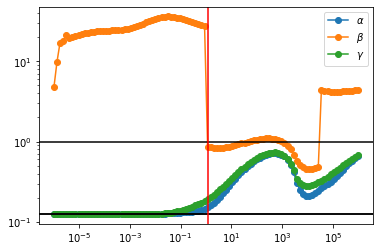

In [59]:
idx = 50
plt.plot(prange, [float(s['x'][-3]) for s in sols], 'o-', label=r'$\alpha$')
plt.plot(prange, [float(s['x'][-2]) for s in sols], 'o-', label=r'$\beta$')
plt.plot(prange, [float(s['x'][-1]) for s in sols], 'o-', label=r'$\gamma$')
for q in p0:
    plt.axhline(q, color='k')
plt.xscale('log')
plt.yscale('log')
plt.axvline(prange[idx], color='r')
plt.legend()

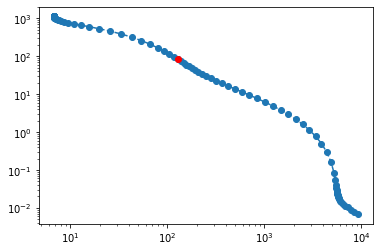

In [60]:
plt.loglog(*fsvals.T, 'o--',)
plt.loglog(*fsvals[idx], 'ro')

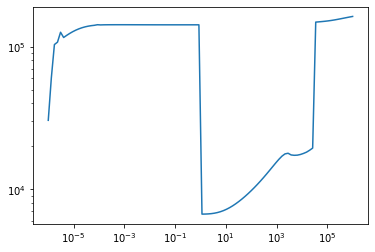

In [61]:
getN = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(sols[idx]['x'])]).sum(axis=1))
plt.loglog(prange, [getN(i) for i,_ in enumerate(prange)])

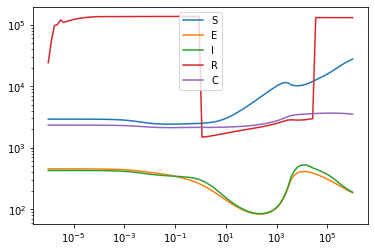

In [62]:
getM = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(sols[idx]['x'])]), axis=0)
plt.semilogx(prange, [getM(i) for i,_ in enumerate(prange)])
plt.yscale('log')
plt.legend("SEIRC")

In [63]:
# applying the final size relation
from scipy.optimize import brentq
def rinf(sol):
    pfin = np.array([float(p) for p in getp(sol['x'])])
    r0 = pfin[1]/pfin[0]
    S0, E0, I0, R0, C0 = [float(x[0]) for x in getx(sol['x'])]
    N = sum((S0, E0, I0, R0))
    f = lambda y: y/S0 - np.exp(r0*(y-N)/N) 
    sinf = brentq(f, 0, S0) 
    return N-sinf

# def rinf(sol):
#     r0 = 8*getp(sol['x'])
#     S0, E0, I0, R0 = [float(x[0]) for x in getx(sol['x'])]
#     N = sum((S0, E0, I0, R0))
#     f = lambda y: y/S0 - np.exp(r0*(y-N)/N)
#     sinf = brentq(f, 0, S0)
#     return N-sinf

(0, 20000)

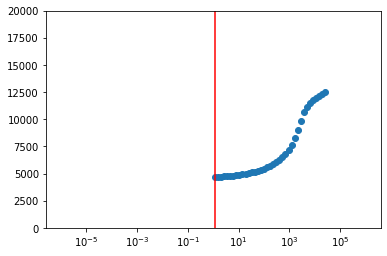

In [64]:
plt.semilogx(prange[:], [rinf(sol) for sol in sols][:], 'o')
plt.axvline(prange[idx], color='r')
plt.ylim([0,20000])

In [65]:
rinf(sols[idx])

4734.245730669406

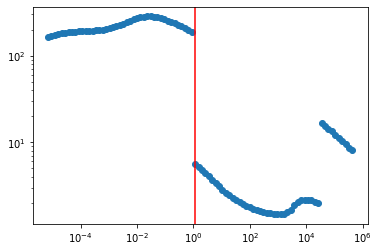

In [66]:
def r0(sol):
    pfin = np.array([float(p) for p in getp(sol['x'])])
    return pfin[1]/pfin[0]
# def r0(sol):
#     return 8*getp(sol['x'])
plt.plot(prange[7:-3], [r0(sol) for sol in sols][7:-3], 'o')
plt.xscale('log')
plt.yscale('log')
plt.axvline(prange[idx], color='r')

In [67]:
[getx(sols[idx]['x'])[i][50] for i in range(5)]

[DM(3353.83), DM(520.347), DM(293.719), DM(273.362), DM(1070.74)]

In [68]:
getx(sols[idx]['x'])[0][0]

DM(4737.61)

In [69]:
getp(sols[idx]['x'])

(DM(0.153893), DM(0.864081), DM(0.193378))

In [70]:
r0(sols[idx])

5.61481871856333

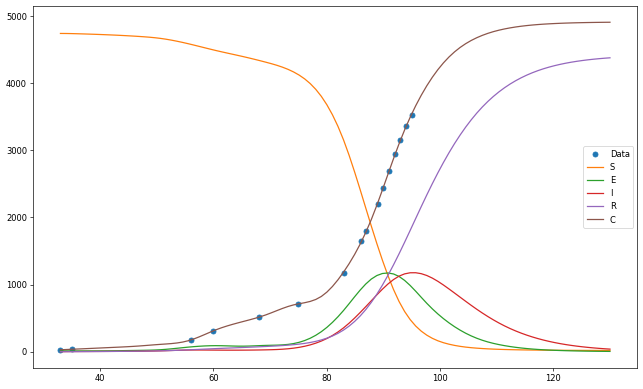

In [72]:
idx = 50
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)
ax.plot(times, cumdata, 'o', label='Data')
ax.plot(model.observation_times, getx(sols[idx]['x'])[0], label='S')
ax.plot(model.observation_times, getx(sols[idx]['x'])[1], label='E')
ax.plot(model.observation_times, getx(sols[idx]['x'])[2], label='I')
ax.plot(model.observation_times, getx(sols[idx]['x'])[3], label='R')
ax.plot(model.observation_times, getx(sols[idx]['x'])[4], label='C')
plt.legend()

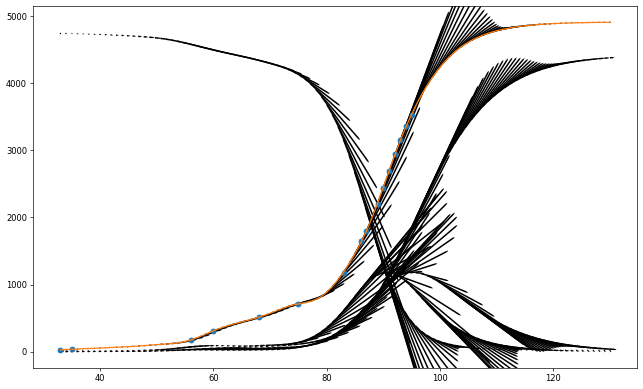

In [143]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)
xx = np.vstack([xix.toarray().flatten() for xix in getx(sols[idx]['x'])])
dxxdt = np.vstack([seir(0, xxj, [float(q) for q in getp(sols[idx]['x'])]) for xxj in xx.T])
for i, xxi in enumerate(xx):
    ax.quiver(model.observation_times, xxi, [1]*len(model.observation_times), dxxdt[:,i], 
              angles='xy', headwidth=0.75, headlength=1, headaxislength=2, width=0.0025)

Text(0.5, 1.0, 'Number of Reported Cases (Prediction)')

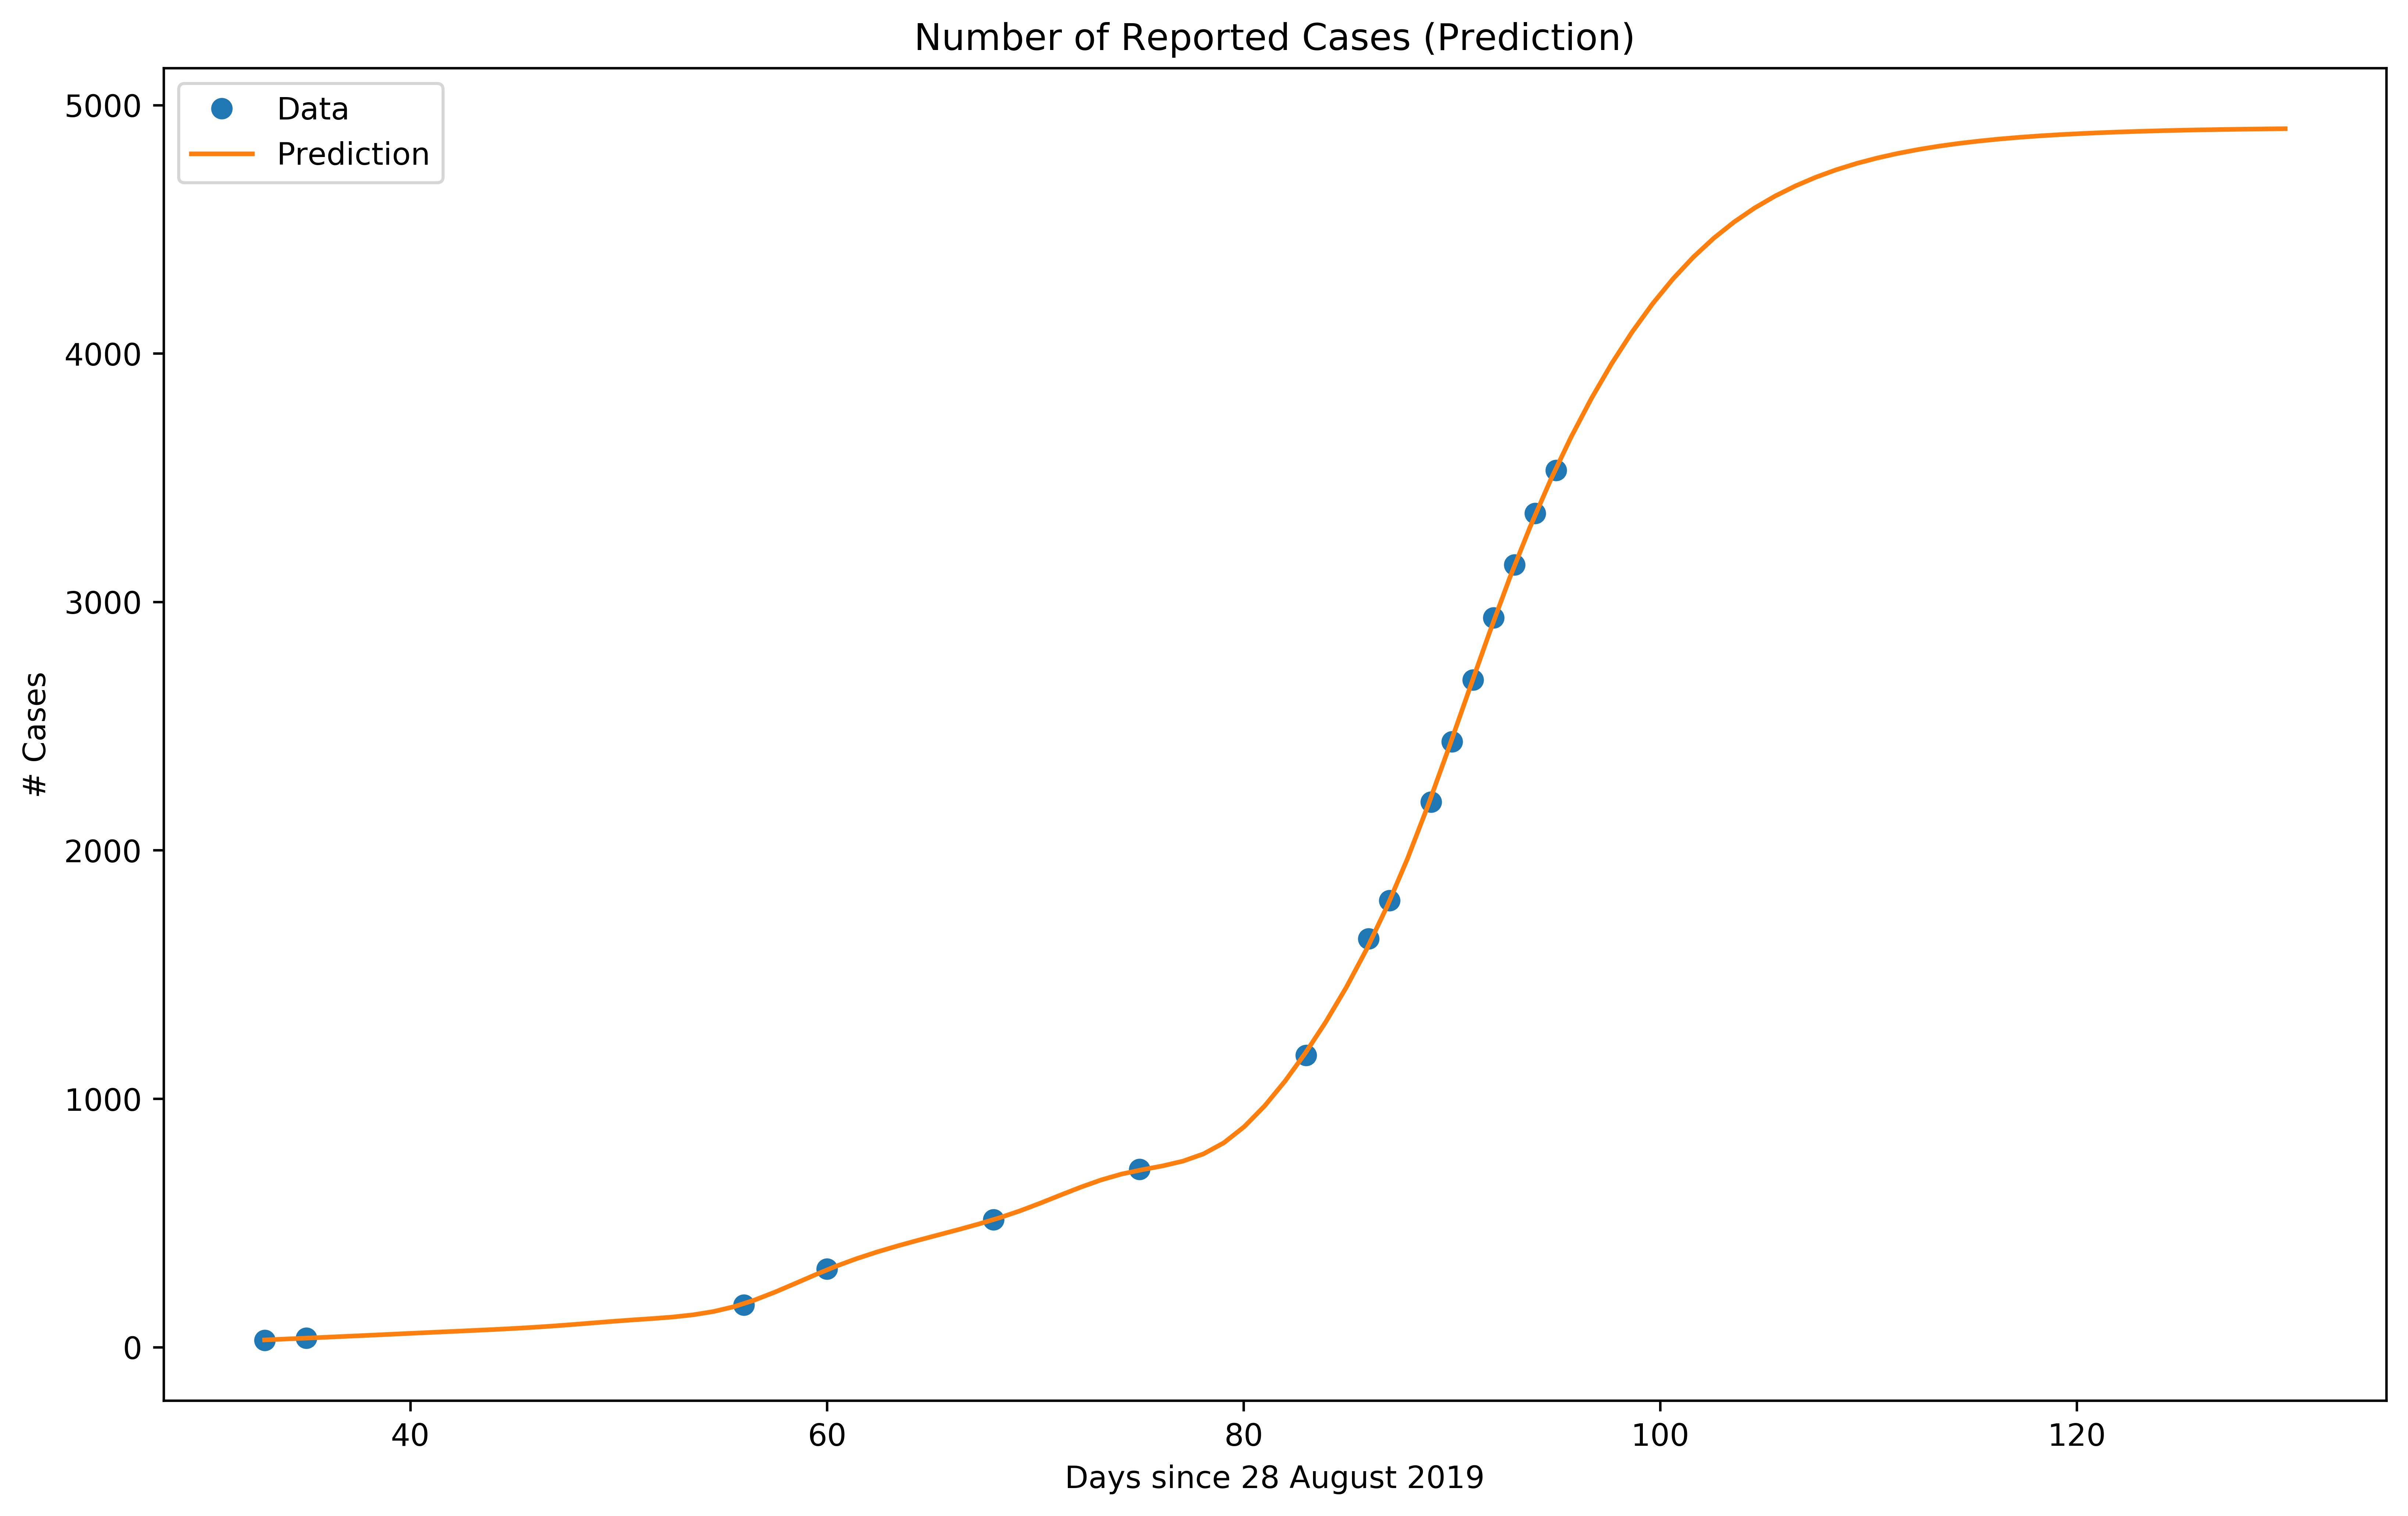

In [92]:
idx = 50
fig, ax=plt.subplots(figsize=[13, 8], dpi=600)

ax.plot(times, cumdata, 'o', label='Data')
ax.plot(model.observation_times, getx(sols[idx]['x'])[4], label='Prediction')
plt.legend()
plt.xlabel("Days since 28 August 2019")
plt.ylabel("# Cases")
plt.title("Number of Reported Cases (Prediction)")

In [93]:
fsvals[idx]

array([127.56287157,  82.45591245])

In [94]:
getc = ca.Function('getx', [solver_setup['x']], model.cs)
np.sqrt(ca.sumsqr(cumdata - objective.collocation_matrices[0]@getc(sols[idx]['x'])[-1])/(len(times)-1))

DM(10.9426)

In [95]:
getp(sols[idx]['x'])

(DM(0.153893), DM(0.864081), DM(0.193378))

In [122]:
profiler_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
}
opts = {'ipopt': {'dual_inf_tol': 1e-1, 'print_frequency_iter': 10}}
profiler = ca.nlpsol('solver', 'ipopt', profiler_setup, opts)

In [123]:
rho = prange[idx]
pref = getp(sols[idx]['x'])
lbx = [-np.inf]*(config['basis_number']*config['model_form']['state']) + [0]*config['model_form']['parameters']
ubx = [np.inf]*(config['basis_number']*config['model_form']['state'] + config['model_form']['parameters'])

profiles = []
for pdx in range(config['model_form']['parameters']):
    pdx_mod = config['basis_number']*config['model_form']['state'] + pdx
    pvals = np.logspace(-2, 1, num=50)
    profiles.append([])
    for pval in pvals:
        lbx0 = np.array(lbx)
        ubx0 = np.array(ubx)
        lbx0[pdx_mod] = pval
        ubx0[pdx_mod] = pval
        profiles[pdx].append(profiler(x0=np.array(sols[idx]['x']).flatten(), p=[rho, alpha], lbx=lbx0, ubx=ubx0))

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1761

Total number of variables............................:      122
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  50  2.4756800e+02 0.00e+00 4.98e-06  -8.6 4.32e+05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 52

                                   (scaled)                 (unscaled)
Objective...............:   4.4573589672918557e-01    2.4756799411608847e+02
Dual infeasibility......:   5.5346631099076846e-12    3.0740298330978922e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035608954842e-09    1.3918141270910063e-06
Overall NLP error.......:   2.5059035608954842e-09    1.3918141270910063e-06


Number of objective function evaluations             = 90
Number of objective gradient evaluations             = 53
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 52
Total CPU secs in IPOPT (w/o

 130  3.6851713e+03 0.00e+00 6.23e-05  -8.6 5.28e-01  -9.1 1.00e+00 1.00e+00f  1
 140  3.6848896e+03 0.00e+00 9.25e+04  -8.6 4.78e+04 -13.8 1.00e+00 1.00e+00f  1
 150  3.6841390e+03 0.00e+00 5.39e+04  -8.6 8.60e-01  -6.1 3.73e-01 1.00e+00f  1
 160  3.6841191e+03 0.00e+00 5.16e-02  -8.6 8.09e+00    -  1.00e+00 1.00e+00f  1
 170  3.6841191e+03 0.00e+00 3.03e-06  -8.6 6.95e-06    -  1.00e+00 1.00e+00f  1
 180  3.6841191e+03 0.00e+00 8.79e-07  -8.6 5.25e-05    -  1.00e+00 1.00e+00f  1
 190  3.6841191e+03 0.00e+00 1.85e-06  -8.6 2.70e-05    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  3.6841191e+03 0.00e+00 2.94e-07  -8.6 4.88e-05    -  1.00e+00 1.00e+00f  1
 210  3.6841191e+03 0.00e+00 2.60e-06  -8.6 2.65e-06    -  1.00e+00 1.00e+00f  1
 220  3.6841191e+03 0.00e+00 6.93e-06  -8.6 1.24e-05    -  1.00e+00 1.00e+00f  1
 230  3.6841191e+03 0.00e+00 4.48e-06  -8.6 1.44e-05    -  1.00e+00 1.00e+00f  1
 240  3.6841191e+03 0.00e+00

  50  2.4181641e+02 0.00e+00 1.49e-10  -9.0 6.87e+04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 50

                                   (scaled)                 (unscaled)
Objective...............:   5.1522675375867000e-01    2.4181640988763490e+02
Dual infeasibility......:   1.4895970999396119e-10    6.9912717120887289e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090900e-10    4.2667252485265697e-07
Overall NLP error.......:   9.0909090909090900e-10    4.2667252485265697e-07


Number of objective function evaluations             = 116
Number of objective gradient evaluations             = 51
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 50
Total CPU secs in IPOPT (w/


Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1761

Total number of variables............................:      122
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.8641183e+03 0.00e+00 9.90e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  2.3349447e+02 0.00e+00 8.49e-02  -2.5 3.27e+01  -7.8 1.00e+00

  20  2.2841513e+02 0.00e+00 4.29e-02  -8.6 6.25e+01  -9.0 1.00e+00 1.00e+00f  1
  30  2.2657602e+02 0.00e+00 1.58e+00  -8.6 1.67e+02  -7.4 1.00e+00 2.50e-01f  3
  40  2.0246775e+02 0.00e+00 2.32e+01  -8.6 7.41e+01  -6.3 1.00e+00 1.00e+00f  1
  50  1.7174485e+02 0.00e+00 2.69e+01  -8.6 4.31e+00  -4.3 1.00e+00 1.00e+00f  1
  60  1.5644875e+02 0.00e+00 1.82e+02  -8.6 8.07e+00  -5.0 1.00e+00 1.00e+00f  1
  70  1.5277792e+02 0.00e+00 2.29e+00  -8.6 1.32e+00  -3.4 1.00e+00 5.00e-01f  2
  80  1.5021106e+02 0.00e+00 3.17e+00  -8.6 1.16e+00  -4.4 1.00e+00 1.00e+00f  1
  90  1.4933264e+02 0.00e+00 1.44e+02  -8.6 3.50e-01  -4.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.4836970e+02 0.00e+00 4.34e+02  -8.6 4.60e-01  -3.9 1.00e+00 1.00e+00f  1
 110  1.4821784e+02 0.00e+00 2.12e+00  -8.6 9.34e-03  -0.9 1.00e+00 1.25e-01f  4
 120  1.4817478e+02 0.00e+00 3.92e+02  -8.6 3.61e+01    -  1.00e+00 2.50e-01f  3
 130  1.4815494e+02 0.00e+00

  90  1.5037379e+02 0.00e+00 2.54e+02  -8.6 2.64e-01  -3.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.4980416e+02 0.00e+00 9.61e-02  -8.6 2.13e-01  -3.9 1.00e+00 1.00e+00f  1
 110  1.4980126e+02 0.00e+00 1.14e-03  -8.6 6.31e-02  -3.3 1.00e+00 1.00e+00f  1
 120  1.4974103e+02 0.00e+00 3.79e-07  -8.6 8.54e-10    -  1.00e+00 6.10e-05f 15
 130  1.4974103e+02 0.00e+00 9.21e-08  -8.6 1.24e-09    -  1.00e+00 1.00e+00w  1

Number of Iterations....: 133

                                   (scaled)                 (unscaled)
Objective...............:   2.6129958341543307e+00    1.4974102955555171e+02
Dual infeasibility......:   1.0005190731269093e-07    5.7336010314948338e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035597623369e-09    1.4360397138833395e-07
Overall NLP error.......:   1.0005190731269093e-07    5.7336010314948338e-06


Number of objective func

  50  1.9928672e+02 0.00e+00 3.98e-01  -8.6 7.24e+00  -5.6 1.00e+00 1.00e+00f  1
  60  1.7605784e+02 0.00e+00 1.54e+02  -8.6 8.85e+02    -  1.00e+00 8.63e-02f  4
  70  1.6801280e+02 0.00e+00 3.42e+01  -8.6 3.91e+00  -4.7 1.00e+00 5.00e-01f  2
  80  1.6672729e+02 0.00e+00 1.31e+00  -8.6 4.89e-01  -4.0 1.00e+00 1.00e+00f  1
  90  1.6552548e+02 0.00e+00 8.75e-01  -8.6 4.68e+00  -5.5 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.6478401e+02 0.00e+00 2.10e-01  -8.6 2.19e-01  -5.2 1.00e+00 1.00e+00f  1
 110  1.6477522e+02 0.00e+00 9.22e-03  -8.6 1.59e-02  -3.7 1.00e+00 1.00e+00f  1
 120  1.6477467e+02 0.00e+00 2.12e-04  -8.6 4.71e-04  -2.1 1.00e+00 1.00e+00f  1
 130  1.6468396e+02 0.00e+00 7.19e+01  -8.6 3.89e+00    -  1.00e+00 5.00e-01f  2

Number of Iterations....: 136

                                   (scaled)                 (unscaled)
Objective...............:   3.8828823950543306e-01    1.6468084134581525e+02
Dual infea

 110  2.1924110e+02 0.00e+00 1.65e+00  -5.7 1.42e+00  -6.2 1.00e+00 1.00e+00f  1
 120  2.1907867e+02 0.00e+00 1.32e-01  -5.7 2.36e-01  -5.5 1.00e+00 1.00e+00f  1
 130  2.1895205e+02 0.00e+00 1.88e+00  -5.7 3.40e+00  -6.7 1.00e+00 1.00e+00f  1
 140  2.1880556e+02 0.00e+00 2.31e+00  -5.7 2.01e-01  -5.1 1.00e+00 1.00e+00f  1
 150  2.1855287e+02 0.00e+00 1.91e+01  -5.7 1.61e+00  -5.4 1.00e+00 1.00e+00f  1
 160  2.1814219e+02 0.00e+00 2.16e+01  -5.7 5.37e+00  -6.1 1.00e+00 1.00e+00f  1
 170  2.1787807e+02 0.00e+00 4.42e-02  -5.7 1.67e-01    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 175

                                   (scaled)                 (unscaled)
Objective...............:   2.2141374863250463e-01    2.1787805736241248e+02
Dual infeasibility......:   2.9077030658492908e-09    2.8612708076474429e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035599445416e-09    2.4658875203114545e-06
Overall NLP error.....

 180  3.7133949e+02 0.00e+00 1.56e+00  -8.6 5.62e-02  -3.1 1.00e+00 5.00e-01f  2
 190  3.7118894e+02 0.00e+00 1.44e+00  -8.6 1.93e+00  -6.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  3.7118536e+02 0.00e+00 1.42e-03  -8.6 5.42e-02  -4.5 1.00e+00 1.00e+00f  1
 210  3.7117365e+02 0.00e+00 8.20e-05  -8.6 1.51e-03  -2.9 1.00e+00 1.00e+00f  1
 220  3.7113992e+02 0.00e+00 4.81e-02  -8.6 3.10e-01  -5.0 1.00e+00 1.25e-01f  4
 230  3.7113663e+02 0.00e+00 2.50e-03  -8.6 3.77e-02  -4.4 1.00e+00 1.00e+00f  1
 240  3.7111784e+02 0.00e+00 3.24e-03  -8.6 6.64e-02  -4.6 1.00e+00 1.00e+00f  1
 250  3.7109927e+02 0.00e+00 4.60e-02  -8.6 1.17e-01  -4.9 1.00e+00 1.00e+00f  1
 260  3.7109912e+02 0.00e+00 2.18e-05  -8.6 5.17e-05  -1.5 1.00e+00 1.00e+00f  1
 270  3.7106255e+02 0.00e+00 8.26e+00  -8.6 2.70e+00  -6.3 1.00e+00 1.00e+00f  1
 280  3.7100893e+02 0.00e+00 1.67e-02  -8.6 7.69e-02  -4.7 1.00e+00 1.00e+00f  1
 290  3.7100623e+02 0.00e+00

 340  4.6352692e+02 0.00e+00 2.94e+00  -5.7 4.91e+00  -8.1 1.00e+00 1.00e+00f  1
 350  4.6350811e+02 0.00e+00 2.53e+00  -5.7 3.86e+00  -7.4 1.00e+00 2.50e-01f  3
 360  4.6350040e+02 0.00e+00 1.09e-02  -5.7 1.21e-01  -6.8 1.00e+00 1.00e+00f  1
 370  4.6348427e+02 0.00e+00 1.99e-01  -5.7 1.57e+00  -7.9 1.00e+00 1.00e+00f  1
 380  4.6346788e+02 0.00e+00 2.36e-02  -5.7 3.78e-01  -7.3 1.00e+00 1.00e+00f  1
 390  4.6343522e+02 0.00e+00 2.90e-01  -5.7 3.92e-02  -5.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  4.6341615e+02 0.00e+00 2.91e-02  -5.7 8.18e-02  -6.0 1.00e+00 1.00e+00f  1
 410  4.6339282e+02 0.00e+00 7.47e-01  -5.7 1.95e-01  -6.3 1.00e+00 5.00e-01f  2
 420  4.6335632e+02 0.00e+00 1.09e-01  -5.7 6.85e-01  -7.4 1.00e+00 1.00e+00f  1
 430  4.6330312e+02 0.00e+00 7.98e-05  -5.7 1.38e-03  -2.3 1.00e+00 1.00e+00f  1
 440  4.6329554e+02 0.00e+00 8.97e-02  -5.7 7.95e-01  -7.0 1.00e+00 1.00e+00f  1
 450  4.6325406e+02 0.00e+00

 150  7.7089022e+02 0.00e+00 7.12e-06  -8.6 8.32e-03  -3.7 1.00e+00 1.00e+00f  1
 160  7.7083374e+02 0.00e+00 3.77e-04  -8.6 1.08e-03  -2.1 1.00e+00 1.00e+00f  1
 170  7.7082616e+02 0.00e+00 2.06e-04  -8.6 1.77e-04  -1.5 1.00e+00 1.00e+00f  1
 180  7.7082001e+02 0.00e+00 5.20e-04  -8.6 1.59e-02  -2.7 1.00e+00 2.50e-01f  3
 190  7.7067310e+02 0.00e+00 7.15e-02  -8.6 1.76e+00  -5.6 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  7.7054027e+02 0.00e+00 2.31e-02  -8.6 8.15e-01  -5.9 1.00e+00 1.00e+00f  1
 210  7.7048620e+02 0.00e+00 3.94e-03  -8.6 4.68e-02  -4.3 1.00e+00 2.50e-01f  3
 220  7.7047026e+02 0.00e+00 2.05e-03  -8.6 2.57e-01  -5.5 1.00e+00 1.00e+00f  1
 230  7.7039547e+02 0.00e+00 5.03e-05  -8.6 5.76e-02  -4.8 1.00e+00 1.00e+00f  1
 240  7.6961113e+02 0.00e+00 7.37e+00  -8.6 3.77e-02  -2.4 1.00e+00 2.50e-01f  3
 250  7.6953058e+02 0.00e+00 2.83e-03  -8.6 7.49e-02  -4.4 1.00e+00 1.00e+00f  1
 260  7.6911058e+02 0.00e+00

 450  1.0003299e+03 0.00e+00 1.59e-01  -8.6 6.69e-01  -8.0 1.00e+00 1.00e+00f  1
 460  1.0003239e+03 0.00e+00 9.16e-02  -8.6 1.70e-01  -7.4 1.00e+00 1.00e+00f  1
 470  1.0003163e+03 0.00e+00 5.39e-01  -8.6 3.27e-01  -7.6 1.00e+00 1.00e+00f  1
 480  1.0003120e+03 0.00e+00 1.91e+00  -8.6 5.18e+01  -8.8 2.04e-01 1.56e-02f  7
 490  1.0003065e+03 0.00e+00 4.20e-01  -8.6 5.08e-01  -7.3 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.0003013e+03 0.00e+00 5.38e-01  -8.6 3.31e-02  -5.7 1.00e+00 1.00e+00f  1
 510  1.0002983e+03 0.00e+00 3.73e-03  -8.6 1.84e-02  -6.0 1.00e+00 1.00e+00f  1
 520  1.0002922e+03 0.00e+00 3.77e-01  -8.6 9.32e-01  -8.0 1.00e+00 1.00e+00f  1
 530  1.0002865e+03 0.00e+00 8.25e-02  -8.6 1.82e+00  -8.3 1.00e+00 1.00e+00f  1
 540  1.0002700e+03 0.00e+00 1.40e+00  -8.6 2.31e-02  -4.9 1.00e+00 1.00e+00f  1
 550  1.0002688e+03 0.00e+00 4.96e-03  -8.6 2.59e-02  -6.1 1.00e+00 1.00e+00f  1
 560  1.0002638e+03 0.00e+00

CasADi - 2019-12-02 17:46:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1010  9.9964122e+02 0.00e+00 6.47e+08  -8.6 2.38e-10  12.1 1.00e+00 7.28e-12f 38
1020  9.9966285e+02 0.00e+00 3.87e+09  -8.6 5.42e-10  11.9 1.00e+00 1.00e+00w  1
1030  9.9964122e+02 0.00e+00 6.47e+08  -8.6 1.15e-09  11.6 1.00e+00 9.09e-13f 41
1040  9.9964467e+02 0.00e+00 5.48e+08  -8.6 3.64e-09  11.4 1.00e+00 3.81e-06f 19
1050  9.9967421e+02 0.00e+00 2.73e+09  -8.6 8.43e-12  15.6 1.00e+00 1.00e+00f  1
1060  9.9965212e+02 0.00e+00 2.25e+09  -8.6 2.17e-09  10.9 1.00e+00 6.25e-02f  5
1070  9.9964940e+02 0.00e+00 3.93e+09  -8.6 3.05e-09  11.5 1.00e+00 5.68e-14f 45
1080  9.9966928e+02 0.00e+00 9.41e+07  -8.6 3.09e-10  11.3 1.00e+00 1.00e+00w  1
1090  9.9965034e+02 0.00e+00 9.33e+08  -8.6 4.10e-10  11.9 1.00e+00 1.82e-12f 40
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  9.9964186e+02 0.00e+00 1.29e+09  -8.6 3.55e-13  16.2 1.00e+00 5.96e-08f 25
1110  9.9965795e+02 0.00e+00 4.22e+09  -8.6 1.74e-09  11.4 1.00e+00 1.14e-13f 44
1120  9.9966218e+02 0.00e+00

CasADi - 2019-12-02 17:46:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:46:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:46:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:46:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:46:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:46:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:46:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1210  1.0010075e+03 0.00e+00 3.08e+11  -8.6 6.81e-11  16.1 1.00e+00 2.50e-01f  3
1220  1.0005872e+03 0.00e+00 1.24e+11  -8.6 1.53e-10  11.3 1.00e+00 5.68e-14f 44
1230  1.2648123e+03 0.00e+00 1.40e+12  -8.6 5.38e-10   6.5 1.00e+00 1.00e+00w  1
1240  1.0001120e+03 0.00e+00 1.17e+11  -8.6 1.34e-11  15.7 1.00e+00 9.09e-13f 41
1250  9.9994605e+02 0.00e+00 9.24e+10  -8.6 5.56e-11  10.9 1.00e+00 1.00e+00f  1
1260  9.9983175e+02 0.00e+00 7.39e+10  -8.6 1.86e-09   6.2 1.00e+00 5.68e-14f 45
1270  9.9974743e+02 0.00e+00 5.46e+10  -8.6 1.69e-12  16.2 1.00e+00 1.56e-02f  7
1280  1.0008877e+03 0.00e+00 1.24e+11  -8.6 2.12e-10  14.2 1.00e+00 1.00e+00S 21
1290  9.9983659e+02 0.00e+00 2.09e+10  -8.6 1.82e-11  10.3 1.00e+00 1.82e-12f 40
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  1.0754302e+03 0.00e+00 2.40e+13  -8.6 2.01e-07   5.5 1.00e+00 1.00e+00w  1
1310  9.9994739e+02 0.00e+00 1.92e+10  -8.6 7.65e-12  15.1 1.00e+00 6.25e-02f  5
1320  9.9980107e+02 0.00e+00

CasADi - 2019-12-02 17:46:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:46:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:46:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:46:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:46:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1330  1.0112735e+03 0.00e+00 6.88e+12  -8.6 7.99e-12  15.9 1.00e+00 5.00e-01f  2
1340  1.0026459e+03 0.00e+00 3.78e+11  -8.6 1.33e-11  11.1 1.00e+00 2.27e-13f 43
1350  1.0000427e+03 0.00e+00 6.01e+10  -8.6 1.48e-09   6.3 1.00e+00 1.00e+00F  1
1360  9.9978214e+02 0.00e+00 3.75e+10  -8.6 1.68e-08   5.2 1.00e+00 1.53e-05f 17
1370  9.9998034e+02 0.00e+00 1.07e+11  -8.6 1.89e-11  15.2 1.00e+00 1.00e+00f  1
1380  9.9990803e+02 0.00e+00 8.17e+10  -8.6 1.05e-11  10.5 1.00e+00 9.09e-13f 41
1390  9.9976951e+02 0.00e+00 2.78e+09  -8.6 2.81e-08   5.7 1.00e+00 3.91e-03f  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  9.9976158e+02 0.00e+00 7.14e+09  -8.6 6.25e-08   4.5 1.00e+00 2.44e-04f 13
1410  9.9973003e+02 0.00e+00 1.02e+10  -8.6 5.03e-08  11.7 1.00e+00 5.96e-08f 25
1420  9.9972972e+02 0.00e+00 8.86e+09  -8.6 1.34e-11  14.1 1.00e+00 2.44e-04f 13
1430  9.9977139e+02 0.00e+00 3.44e+07  -8.6 7.69e-10  11.2 1.00e+00 1.00e+00w  1
1440  9.9972915e+02 0.00e+00

CasADi - 2019-12-02 17:46:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:46:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:46:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:46:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:46:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:46:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:46:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1730  1.0029474e+03 0.00e+00 2.10e+12  -8.6 1.96e-10  14.3 1.00e+00 3.12e-02f  6
1740  1.0038479e+03 0.00e+00 8.66e+11  -8.6 1.95e-10   9.6 1.00e+00 1.42e-14f 47
1750  1.0034560e+03 0.00e+00 3.65e+10  -8.6 2.90e-09   6.6 1.00e+00 9.77e-04f 11
1760  1.0006663e+03 0.00e+00 1.93e+11  -8.6 2.03e-10   6.3 1.00e+00 2.50e-01f  3
1770  1.0007726e+03 0.00e+00 2.74e+11  -8.6 8.89e-09   6.1 1.00e+00 1.00e+00w  1
1780  1.0001302e+03 0.00e+00 7.97e+10  -8.6 1.50e-09   5.8 1.00e+00 3.91e-03f  9
1790  1.0005216e+03 0.00e+00 2.61e+11  -8.6 4.21e-12  15.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1800  1.0001183e+03 0.00e+00 8.24e+10  -8.6 7.74e-11  11.1 1.00e+00 2.27e-13f 43
1810  1.0000551e+03 0.00e+00 5.77e+10  -8.6 7.61e-11  12.7 1.00e+00 4.55e-13f 42
1820  1.0000844e+03 0.00e+00 4.24e+10  -8.6 6.73e-11   7.9 1.00e+00 5.00e-01f  2


CasADi - 2019-12-02 17:46:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:46:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:46:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:46:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:46:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:46:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:46:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1830  9.9997705e+02 0.00e+00 2.57e+10  -8.6 3.68e-09  12.4 1.00e+00 1.42e-14f 47
1840  1.0003275e+03 0.00e+00 6.02e+11  -8.6 1.41e-11  14.8 1.00e+00 1.00e+00f  1
1850  9.9987347e+02 0.00e+00 1.20e+11  -8.6 1.85e-11  10.0 1.00e+00 4.55e-13f 42
1860  9.9971218e+02 0.00e+00 6.81e+10  -8.6 1.10e-08   5.3 1.00e+00 2.44e-04f 13
1870  9.9964837e+02 0.00e+00 3.24e+10  -8.6 1.27e-07   5.0 1.00e+00 7.63e-06f 18
1880  1.0069906e+03 0.00e+00 8.62e+11  -8.6 6.20e-13  19.1 1.00e+00 1.00e+00w  1
1890  9.9964672e+02 0.00e+00 2.47e+10  -8.6 2.01e-11  14.3 1.00e+00 6.10e-05f 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1900  9.9964622e+02 0.00e+00 2.18e+10  -8.6 2.25e-10   9.5 1.00e+00 7.63e-06f 18
1910  9.9964573e+02 0.00e+00 1.86e+10  -8.6 3.57e-12  15.1 1.00e+00 4.88e-04f 12
1920  9.9964538e+02 0.00e+00 1.58e+10  -8.6 1.03e-11  16.6 1.00e+00 7.63e-06f 17
1930  1.0018088e+03 0.00e+00 1.56e+12  -8.6 1.96e-10  11.9 1.00e+00 1.00e+00w  1
1940  9.9964471e+02 0.00e+00

CasADi - 2019-12-02 17:46:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:46:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1761

Total number of variables............................:      122
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.7951307e+05 0.00e+00 1.01e+02  -1.0 0.00e+00    -  0.00e+00 0.

 960  1.3180480e+03 0.00e+00 1.44e-01  -9.0 2.33e+00  -7.3 1.00e+00 1.00e+00f  1
 970  1.3180471e+03 0.00e+00 1.76e-05  -9.0 9.45e-03  -4.9 1.00e+00 1.00e+00f  1
 980  1.3178680e+03 0.00e+00 2.05e+00  -9.0 7.62e+00  -7.0 1.00e+00 5.00e-01f  2
 990  1.3175938e+03 0.00e+00 1.11e-01  -9.0 1.45e-01  -4.0 1.00e+00 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  1.3172180e+03 0.00e+00 3.11e-03  -9.0 8.23e-03  -2.4 1.00e+00 1.00e+00f  1

Number of Iterations....: 1007

                                   (scaled)                 (unscaled)
Objective...............:   3.0105432586514491e-01    1.3172162671714459e+03
Dual infeasibility......:   7.2287086152473221e-11    3.1628087559556800e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090879e-10    3.9775855415830193e-06
Overall NLP error.......:   9.0909090909090879e-10    3.9775855415830193e-06


Number of objective fun

 720  1.7471689e+03 0.00e+00 8.02e-04  -8.6 1.31e-01  -7.7 1.00e+00 1.00e+00f  1
 730  1.7471665e+03 0.00e+00 1.98e-01  -8.6 2.34e-01  -7.9 1.00e+00 1.00e+00f  1
 740  1.7471641e+03 0.00e+00 1.27e-01  -8.6 1.07e-01  -7.3 1.00e+00 1.00e+00f  1
 750  1.7471610e+03 0.00e+00 1.06e+01  -8.6 4.24e+00  -9.3 1.00e+00 5.00e-01f  2
 760  1.7471582e+03 0.00e+00 4.41e-01  -8.6 1.56e-01  -7.8 1.00e+00 1.00e+00f  1
 770  1.7471557e+03 0.00e+00 4.51e+00  -8.6 1.68e+00  -8.9 1.00e+00 1.00e+00f  1
 780  1.7471532e+03 0.00e+00 2.79e-01  -8.6 4.32e-01  -8.3 1.00e+00 1.00e+00f  1
 790  1.7471510e+03 0.00e+00 7.83e+00  -8.6 2.34e+00  -8.6 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  1.7471485e+03 0.00e+00 1.27e+00  -8.6 3.56e-01  -7.9 9.73e-01 1.00e+00f  1
 810  1.7471461e+03 0.00e+00 3.06e-01  -8.6 3.22e-01  -8.2 1.00e+00 1.00e+00f  1
 820  1.7471432e+03 0.00e+00 2.11e+00  -8.6 3.57e-01  -7.5 1.00e+00 1.00e+00f  1
 830  1.7471411e+03 0.00e+00

 180  2.3233975e+03 0.00e+00 3.01e-01  -5.7 1.59e+00  -7.2 1.00e+00 1.00e+00f  1
 190  2.3233564e+03 0.00e+00 5.04e-01  -5.7 4.96e+00  -8.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.3233429e+03 0.00e+00 4.86e+00  -5.7 3.99e-01  -6.8 1.00e+00 1.00e+00f  1
 210  2.3233350e+03 0.00e+00 6.42e-02  -5.7 1.29e+00  -8.8 1.00e+00 1.00e+00f  1
 220  2.3233207e+03 0.00e+00 4.67e-01  -5.7 1.52e-01  -6.4 1.00e+00 1.00e+00f  1
 230  2.3233147e+03 0.00e+00 6.11e-01  -5.7 1.00e+00  -8.5 1.00e+00 1.00e+00f  1
 240  2.3233016e+03 0.00e+00 7.14e-01  -5.7 1.41e-01  -6.9 1.00e+00 1.00e+00f  1
 250  2.3232935e+03 0.00e+00 6.74e-02  -5.7 1.71e+00  -9.0 1.00e+00 1.00e+00f  1
 260  2.3232747e+03 0.00e+00 3.24e-01  -5.7 2.51e-01  -7.4 1.00e+00 1.00e+00f  1
 270  2.3232645e+03 0.00e+00 1.61e-01  -5.7 5.96e+00  -9.5 1.00e+00 1.00e+00f  1
 280  2.3232536e+03 0.00e+00 5.01e-01  -5.7 8.19e-01  -7.9 1.00e+00 1.00e+00f  1
 290  2.3232461e+03 0.00e+00

 370  3.0973657e+03 0.00e+00 2.40e+02  -8.6 5.22e-10   8.6 1.00e+00 1.00e+00w  1
 380  3.0973657e+03 0.00e+00 2.78e-01  -9.0 8.61e-12   4.8 1.00e+00 6.25e-02f  5
 390  3.0973657e+03 0.00e+00 2.30e+01  -9.0 1.07e-08   8.1 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  3.0973657e+03 0.00e+00 5.05e-01  -9.0 4.68e-10   3.4 1.00e+00 3.81e-06f 19
 410  3.0973657e+03 0.00e+00 6.74e-01  -9.0 2.40e-12   5.8 1.00e+00 4.88e-04f 12
 420  3.0973657e+03 0.00e+00 2.27e-01  -9.0 2.03e-10  11.2 1.00e+00 3.12e-02f  5

Number of Iterations....: 422

                                   (scaled)                 (unscaled)
Objective...............:   4.4151889510609921e-01    3.0973657002368359e+03
Dual infeasibility......:   1.6901286748534260e-02    1.1856676224965986e+02
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090910e-10    6.3775005586989826e-06
Overall NLP error.....

 750  4.1316386e+03 0.00e+00 1.92e-03  -8.6 2.73e-01  -7.6 1.00e+00 1.00e+00f  1
 760  4.1316175e+03 0.00e+00 6.01e-02  -8.6 2.95e+00  -8.7 1.00e+00 1.00e+00f  1
 770  4.1315919e+03 0.00e+00 4.48e-01  -8.6 4.62e+00  -9.0 1.00e+00 1.00e+00f  1
 780  4.1315711e+03 0.00e+00 8.06e-03  -8.6 3.30e-01  -7.4 1.00e+00 1.00e+00f  1
 790  4.1315372e+03 0.00e+00 1.79e-01  -8.6 1.48e+00  -7.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  4.1315038e+03 0.00e+00 2.00e-02  -8.6 1.33e+00  -8.0 1.00e+00 1.00e+00f  1
 810  4.1314834e+03 0.00e+00 3.19e-04  -8.6 6.36e-02  -6.4 1.00e+00 1.00e+00f  1
 820  4.1314251e+03 0.00e+00 8.60e-03  -8.6 1.66e-01  -6.7 1.00e+00 1.00e+00f  1
 830  4.1313184e+03 0.00e+00 7.09e-04  -8.6 1.95e-02  -5.1 1.00e+00 1.00e+00f  1
 840  4.1311863e+03 0.00e+00 5.49e-02  -8.6 9.08e-01  -6.3 1.00e+00 1.00e+00f  1
 850  4.1307891e+03 0.00e+00 8.85e-02  -8.6 1.08e-01  -5.6 1.00e+00 1.00e+00f  1
 860  4.1306953e+03 0.00e+00

  30  7.4212089e+03 0.00e+00 1.27e-03  -5.7 1.96e+01  -9.2 1.00e+00 1.00e+00f  1
  40  7.4117011e+03 0.00e+00 7.57e-02  -5.7 3.03e+02  -9.5 1.00e+00 1.00e+00f  1
  50  7.3832639e+03 0.00e+00 9.35e-02  -5.7 5.25e+01  -7.9 1.00e+00 5.00e-01f  2
  60  7.3727170e+03 0.00e+00 3.13e-01  -5.7 1.09e+00  -4.6 1.00e+00 2.50e-01f  3
  70  7.3722155e+03 0.00e+00 6.81e-03  -5.7 9.17e-01  -6.6 1.00e+00 1.00e+00f  1
  80  7.3717556e+03 0.00e+00 5.44e-02  -5.7 7.67e+00  -7.8 1.00e+00 1.00e+00f  1
  90  7.3705162e+03 0.00e+00 9.14e-01  -5.7 1.66e+00  -6.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  7.3695412e+03 0.00e+00 3.96e-01  -5.7 9.34e+01  -7.4 1.00e+00 4.45e-02f  3
 110  7.3694439e+03 0.00e+00 1.87e-04  -5.7 2.19e-01  -5.9 1.00e+00 1.00e+00f  1
 120  7.3694297e+03 0.00e+00 8.87e-05  -8.6 1.22e-03  -2.5 1.00e+00 1.00e+00f  1
 130  7.3694226e+03 0.00e+00 1.61e-03  -8.6 1.17e-04  -1.0 1.00e+00 1.00e+00f  1
 140  7.3694114e+03 0.00e+00

  70  9.8411780e+03 0.00e+00 3.94e-05  -8.6 1.92e-01  -5.7 1.00e+00 1.00e+00f  1
  80  9.8403048e+03 0.00e+00 1.14e-02  -8.6 6.54e+00  -7.8 1.00e+00 1.00e+00f  1
  90  9.8396427e+03 0.00e+00 9.34e-02  -8.6 5.38e+00  -7.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  9.8381978e+03 0.00e+00 2.84e-01  -8.6 4.18e+01  -7.4 1.00e+00 1.01e-01f  3
 110  9.8373166e+03 0.00e+00 5.88e-02  -8.6 1.57e+00  -6.8 1.00e+00 1.00e+00f  1
 120  9.8372656e+03 0.00e+00 4.56e-05  -8.6 4.39e-02  -5.2 1.00e+00 1.00e+00f  1
 130  9.8372630e+03 0.00e+00 1.96e-03  -8.6 1.36e-03  -1.9 1.00e+00 2.50e-01f  3
 140  9.8372611e+03 0.00e+00 4.26e-04  -8.6 4.44e-04  -2.1 1.00e+00 5.00e-01f  2
 150  9.8372609e+03 0.00e+00 3.38e-05  -8.6 5.02e-04  -3.3 1.00e+00 1.00e+00f  1
 160  9.8372590e+03 0.00e+00 1.11e-02  -8.6 1.97e-04  -0.8 1.00e+00 2.50e-01f  3
 170  9.8372585e+03 0.00e+00 1.43e-05  -8.6 1.30e-02  -4.7 1.00e+00 1.00e+00f  1
 180  9.8372299e+03 0.00e+00

1180  9.8349774e+03 0.00e+00 1.12e-04  -9.1 1.16e-07  -1.1 1.00e+00 1.00e+00f  1
1190  9.8349774e+03 0.00e+00 8.03e-05  -9.1 1.39e-06  -2.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  9.8349774e+03 0.00e+00 2.22e-05  -9.1 2.84e-02  -7.1 1.00e+00 1.00e+00f  1
1210  9.8349773e+03 0.00e+00 7.53e-06  -9.1 9.64e-06  -2.6 1.00e+00 1.00e+00f  1
1220  9.8349773e+03 0.00e+00 8.41e-06  -9.1 3.01e-02  -7.4 1.00e+00 1.00e+00f  1
1230  9.8349755e+03 0.00e+00 2.74e-04  -9.1 9.31e-05  -2.2 1.00e+00 1.25e-01f  4
1240  9.8349755e+03 0.00e+00 8.94e-06  -9.1 1.28e-02  -7.0 1.00e+00 1.00e+00f  1
1250  9.8349690e+03 0.00e+00 1.26e-05  -9.1 9.22e-05  -1.8 1.00e+00 1.00e+00f  1
1260  9.8349687e+03 0.00e+00 1.22e-04  -9.1 8.89e-02  -6.6 1.00e+00 1.00e+00f  1
1270  9.8349686e+03 0.00e+00 4.08e-06  -9.1 1.32e-02  -5.9 1.00e+00 1.00e+00f  1

Number of Iterations....: 1279

                                   (scaled)                 (unscaled)
Objec

 660  1.3126466e+04 0.00e+00 1.07e-02  -8.6 1.41e+00  -9.4 1.00e+00 1.00e+00f  1
 670  1.3126461e+04 0.00e+00 1.93e-01  -8.6 1.55e-01  -6.9 1.00e+00 1.00e+00f  1
 680  1.3126457e+04 0.00e+00 1.22e-04  -8.6 6.08e-01  -9.0 1.00e+00 1.00e+00f  1
 690  1.3126452e+04 0.00e+00 1.46e-03  -8.6 1.71e-01  -8.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  1.3126449e+04 0.00e+00 2.98e-03  -8.6 2.84e-01  -8.6 1.00e+00 1.00e+00f  1
 710  1.3126443e+04 0.00e+00 4.54e-02  -8.6 3.76e+00  -9.7 1.00e+00 1.00e+00f  1
 720  1.3126440e+04 0.00e+00 1.23e-03  -8.6 1.59e-01  -8.2 1.00e+00 1.00e+00f  1
 730  1.3126436e+04 0.00e+00 3.04e-05  -8.6 5.55e-02  -7.6 1.00e+00 1.00e+00f  1
 740  1.3126431e+04 0.00e+00 3.75e-03  -8.6 4.07e-01  -8.7 1.00e+00 1.00e+00f  1
 750  1.3126425e+04 0.00e+00 4.30e-01  -8.6 5.93e+00  -9.9 1.00e+00 1.00e+00f  1
 760  1.3126420e+04 0.00e+00 1.50e-02  -8.6 3.90e-01  -8.3 1.00e+00 1.00e+00f  1
 770  1.3126414e+04 0.00e+00

 570  1.7510897e+04 0.00e+00 1.31e-02  -8.6 1.69e+00  -9.0 1.00e+00 1.00e+00f  1
 580  1.7510889e+04 0.00e+00 3.41e-04  -8.6 2.36e-01  -8.4 1.00e+00 1.00e+00f  1
 590  1.7510877e+04 0.00e+00 1.04e-01  -8.6 6.95e+00 -10.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.7510853e+04 0.00e+00 2.90e-03  -8.6 7.37e-01  -8.8 1.00e+00 1.00e+00f  1
 610  1.7510839e+04 0.00e+00 9.98e-02  -8.6 1.62e+01 -10.0 1.00e+00 2.50e-01f  3
 620  1.7510826e+04 0.00e+00 1.52e-02  -8.6 2.54e+00  -9.3 1.00e+00 1.00e+00f  1
 630  1.7510814e+04 0.00e+00 1.09e-01  -8.6 2.04e+00  -7.8 1.00e+00 1.00e+00f  1
 640  1.7510796e+04 0.00e+00 1.92e-01  -8.6 1.43e+01  -9.9 1.00e+00 5.00e-01f  2
 650  1.7510759e+04 0.00e+00 2.36e-03  -8.6 6.38e-01  -8.3 1.00e+00 1.00e+00f  1
 660  1.7510708e+04 0.00e+00 3.96e-04  -8.6 9.20e-01  -7.7 1.00e+00 1.00e+00f  1
 670  1.7510638e+04 0.00e+00 3.78e-02  -8.6 6.45e+00  -8.8 1.00e+00 5.00e-01f  2
 680  1.7510481e+04 0.00e+00

 600  2.3348319e+04 0.00e+00 1.92e-02  -8.6 2.88e+00  -9.8 1.00e+00 1.00e+00f  1
 610  2.3348311e+04 0.00e+00 4.51e-02  -8.6 9.97e-01  -8.3 1.00e+00 5.00e-01f  2
 620  2.3348304e+04 0.00e+00 1.47e-01  -8.6 7.74e-01  -8.5 1.00e+00 1.00e+00f  1
 630  2.3348287e+04 0.00e+00 3.21e-03  -8.6 8.31e-01  -9.2 1.00e+00 1.00e+00f  1
 640  2.3348273e+04 0.00e+00 4.71e-01  -8.6 1.48e+04    -  1.00e+00 1.40e-03f  6
 650  2.3348263e+04 0.00e+00 7.27e-03  -8.6 1.04e+00  -9.3 1.00e+00 1.00e+00f  1
 660  2.3348257e+04 0.00e+00 5.71e-03  -8.6 1.95e+00  -9.5 1.00e+00 1.00e+00f  1
 670  2.3348240e+04 0.00e+00 1.56e-01  -8.6 1.22e+01 -10.2 1.00e+00 5.00e-01f  2
 680  2.3348208e+04 0.00e+00 3.45e-05  -8.6 3.48e-01  -8.2 1.00e+00 1.00e+00f  1
 690  2.3348194e+04 0.00e+00 7.09e-02  -8.6 5.41e+00  -9.3 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  2.3348177e+04 0.00e+00 1.60e-02  -8.6 4.44e+00  -9.6 1.00e+00 1.00e+00f  1
 710  2.3348154e+04 0.00e+00

 580  3.1115334e+04 0.00e+00 5.75e-04  -8.6 7.38e-02  -7.5 1.00e+00 1.00e+00f  1
 590  3.1115329e+04 0.00e+00 4.57e-03  -8.6 1.23e+00  -9.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  3.1115321e+04 0.00e+00 4.55e-02  -8.6 7.41e-01  -8.9 1.00e+00 1.00e+00f  1
 610  3.1115317e+04 0.00e+00 1.30e-01  -8.6 6.00e+00 -10.1 1.00e+00 5.00e-01f  2
 620  3.1115312e+04 0.00e+00 3.88e-05  -8.6 1.12e+00  -9.4 1.00e+00 1.00e+00f  1
 630  3.1115290e+04 0.00e+00 2.36e-02  -8.6 5.65e-01  -7.4 1.00e+00 1.00e+00f  1
 640  3.1115285e+04 0.00e+00 3.67e-03  -8.6 1.12e+00  -9.5 1.00e+00 1.00e+00f  1
 650  3.1115270e+04 0.00e+00 1.37e-04  -8.6 2.02e-01  -8.3 1.00e+00 1.00e+00f  1
 660  3.1115257e+04 0.00e+00 1.38e-01  -8.6 3.42e-01  -7.2 1.00e+00 1.00e+00f  1
 670  3.1115243e+04 0.00e+00 6.16e-05  -8.6 2.25e-01  -7.9 1.00e+00 1.00e+00f  1
 680  3.1115231e+04 0.00e+00 3.98e-01  -8.6 2.70e+03    -  5.95e-01 1.56e-02f  7
 690  3.1115210e+04 0.00e+00

 460  4.1444763e+04 0.00e+00 2.79e-01  -8.6 1.03e+01 -10.6 1.00e+00 1.00e+00f  1
 470  4.1444759e+04 0.00e+00 1.69e-01  -8.6 2.61e+00  -9.9 1.00e+00 1.00e+00f  1
 480  4.1444756e+04 0.00e+00 6.06e-04  -8.6 5.36e-01  -9.3 1.00e+00 1.00e+00f  1
 490  4.1444749e+04 0.00e+00 2.08e-01  -8.6 7.70e+00 -10.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  4.1444743e+04 0.00e+00 1.11e-02  -8.6 1.74e+00  -9.8 1.00e+00 1.00e+00f  1
 510  4.1444737e+04 0.00e+00 6.89e-04  -8.6 4.04e-01  -9.1 1.00e+00 1.00e+00f  1
 520  4.1444729e+04 0.00e+00 5.20e-02  -8.6 2.32e+00  -8.5 1.00e+00 2.50e-01f  3
 530  4.1444725e+04 0.00e+00 3.98e-03  -8.6 1.29e+00  -9.7 1.00e+00 1.00e+00f  1
 540  4.1444716e+04 0.00e+00 1.75e-01  -8.6 2.99e+00  -9.9 1.00e+00 1.00e+00f  1
 550  4.1444712e+04 0.00e+00 9.09e-03  -8.6 6.68e-01  -9.3 1.00e+00 1.00e+00f  1
 560  4.1444705e+04 0.00e+00 1.63e-04  -8.6 1.73e-01  -8.6 1.00e+00 1.00e+00f  1
 570  4.1444699e+04 0.00e+00

 510  5.5176273e+04 0.00e+00 3.46e-01  -8.6 1.52e+01 -10.8 1.00e+00 5.00e-01f  2
 520  5.5176270e+04 0.00e+00 2.18e-03  -8.6 3.30e+00 -10.2 1.00e+00 1.00e+00f  1
 530  5.5176263e+04 0.00e+00 1.55e-03  -8.6 1.91e-01  -8.6 1.00e+00 1.00e+00f  1
 540  5.5176260e+04 0.00e+00 3.67e-04  -8.6 3.53e-02  -6.1 1.00e+00 1.00e+00f  1
 550  5.5176257e+04 0.00e+00 8.46e-03  -8.6 1.37e+00  -9.1 1.00e+00 5.00e-01f  2
 560  5.5176254e+04 0.00e+00 5.01e-03  -8.6 4.33e+00 -10.3 1.00e+00 1.00e+00f  1
 570  5.5176252e+04 0.00e+00 3.97e-05  -8.6 4.05e-02  -7.8 1.00e+00 1.00e+00f  1
 580  5.5176246e+04 0.00e+00 3.30e-03  -8.6 4.90e-02  -7.2 1.00e+00 5.00e-01f  2
 590  5.5176243e+04 0.00e+00 7.79e-04  -8.6 4.11e-01  -9.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  5.5176239e+04 0.00e+00 8.90e-06  -8.6 1.03e-01  -8.6 1.00e+00 1.00e+00f  1
 610  5.5176233e+04 0.00e+00 1.47e-01  -8.6 1.44e+01 -10.6 1.00e+00 2.50e-01f  3
 620  5.5176233e+04 0.00e+00

 290  7.3423510e+04 0.00e+00 1.69e-06  -8.6 1.28e-01  -5.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  7.3423374e+04 0.00e+00 1.56e-05  -8.6 1.87e-04  -2.2 1.00e+00 1.00e+00f  1
 310  7.3423359e+04 0.00e+00 2.58e-03  -8.6 1.06e+00  -6.9 1.00e+00 1.00e+00f  1
 320  7.3423339e+04 0.00e+00 7.59e-06  -8.6 3.48e-05  -1.4 1.00e+00 1.00e+00f  1
 330  7.3423337e+04 0.00e+00 2.59e-05  -8.6 1.41e-01  -6.2 1.00e+00 1.00e+00f  1
 340  7.3423300e+04 0.00e+00 1.67e-05  -8.6 6.75e-07   1.4 1.00e+00 1.00e+00f  1
 350  7.3423299e+04 0.00e+00 2.26e-06  -8.6 2.42e-04  -3.4 1.00e+00 1.00e+00f  1
 360  7.3423284e+04 0.00e+00 4.85e-03  -8.6 5.96e-01  -7.2 1.00e+00 5.00e-01f  2
 370  7.3423279e+04 0.00e+00 1.78e-06  -8.6 1.61e-02  -5.7 1.00e+00 1.00e+00f  1
 380  7.3423262e+04 0.00e+00 4.45e-05  -8.6 5.98e-05  -1.4 1.00e+00 1.00e+00f  1
 390  7.3423261e+04 0.00e+00 8.56e-06  -8.6 3.15e-02  -6.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 530  9.7663511e+04 0.00e+00 1.19e-05  -8.6 3.94e-01  -9.4 1.00e+00 1.00e+00f  1
 540  9.7663508e+04 0.00e+00 2.90e-03  -8.6 2.44e+00  -9.6 1.00e+00 3.12e-02f  6
 550  9.7663505e+04 0.00e+00 3.58e-05  -8.6 2.72e-02  -8.1 1.00e+00 1.00e+00f  1
 560  9.7663502e+04 0.00e+00 1.93e-02  -8.6 2.17e+00 -10.1 1.00e+00 1.00e+00f  1
 570  9.7663497e+04 0.00e+00 2.58e-03  -8.6 1.76e-01  -8.6 1.00e+00 1.00e+00f  1
 580  9.7663493e+04 0.00e+00 4.56e-04  -8.6 1.66e-01  -8.8 1.00e+00 1.00e+00f  1
 590  9.7663487e+04 0.00e+00 1.85e-01  -8.6 1.94e+01 -10.9 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  9.7663483e+04 0.00e+00 1.90e-02  -8.6 3.05e+00 -10.3 1.00e+00 1.00e+00f  1
 610  9.7663479e+04 0.00e+00 2.22e-03  -8.6 2.46e-01  -8.7 1.00e+00 1.00e+00f  1
 620  9.7663472e+04 0.00e+00 5.04e-02  -8.6 9.72e+00 -10.8 1.00e+00 1.00e+00f  1
 630  9.7663469e+04 0.00e+00 4.28e-03  -8.6 2.21e+00 -10.1 1.00e+00 1.00e+00f  1
 640  9.7663463e+04 0.00e+00

   0  1.8623943e+04 0.00e+00 9.90e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  3.8510550e+03 0.00e+00 1.38e+00  -2.5 3.13e+01  -5.6 1.00e+00 1.00e+00f  1
  20  2.0837509e+03 0.00e+00 5.43e-01  -2.5 7.63e+02  -7.6 1.00e+00 1.00e+00f  1
  30  3.4070137e+02 0.00e+00 9.03e+00  -2.5 3.70e+02  -7.9 1.00e+00 1.00e+00f  1
  40  2.2854563e+02 0.00e+00 1.24e+00  -2.5 6.39e+02  -7.6 1.00e+00 1.25e-01f  4
  50  1.9567726e+02 0.00e+00 5.14e+00  -2.5 2.14e+02    -  1.00e+00 1.00e+00f  1
  60  1.7939553e+02 0.00e+00 6.74e-02  -3.8 1.66e+01  -6.9 1.00e+00 1.00e+00f  1
  70  1.7683592e+02 0.00e+00 3.55e-08  -8.6 2.83e-02    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 71

                                   (scaled)                 (unscaled)
Objective...............:   2.2527684133754461e-01    1.7683591786153204e+02
Dual infeasibility......:   2.9405419643805764e-13    2.3082418689565034e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity....


Number of Iterations....: 59

                                   (scaled)                 (unscaled)
Objective...............:   2.4909218970559424e-01    1.9193114253376783e+02
Dual infeasibility......:   7.0957539270147250e-14    5.4674382202029345e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    1.9308551338252919e-06
Overall NLP error.......:   2.5059035596800618e-09    1.9308551338252919e-06


Number of objective function evaluations             = 168
Number of objective gradient evaluations             = 60
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 59
Total CPU secs in IPOPT (w/o function evaluations)   =      0.033
Total CPU secs in NLP function evaluations

  60  2.0329830e+02 0.00e+00 6.18e-10  -5.7 3.85e-03    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 63

                                   (scaled)                 (unscaled)
Objective...............:   2.6909629053323708e-01    2.0329830028263706e+02
Dual infeasibility......:   8.9904193440331594e-09    6.7921299392431849e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909093619576830e-10    6.8680486737561910e-07
Overall NLP error.......:   8.9904193440331594e-09    6.7921299392431849e-06


Number of objective function evaluations             = 186
Number of objective gradient evaluations             = 64
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 63
Total CPU secs in IPOPT (w/

  30  2.3084663e+02 0.00e+00 4.68e+00  -2.5 1.92e+02    -  1.00e+00 1.00e+00f  1
  40  2.1822300e+02 0.00e+00 1.21e+00  -2.5 8.21e+01    -  1.00e+00 1.00e+00f  1
  50  2.1733265e+02 0.00e+00 3.79e-08  -8.6 2.37e-02    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 51

                                   (scaled)                 (unscaled)
Objective...............:   3.0082470557411395e-01    2.1733264907850076e+02
Dual infeasibility......:   2.4963534948422409e-14    1.8035058557940574e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596922689e-09    1.8104053585751436e-06
Overall NLP error.......:   2.5059035596922689e-09    1.8104053585751436e-06


Number of objective function evaluations             = 139
Number of objective gradient evaluations             = 52
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobia

  30  2.3160635e+02 0.00e+00 1.51e-01  -3.8 2.26e+01  -7.2 1.00e+00 1.00e+00f  1
  40  2.2467596e+02 0.00e+00 6.62e-01  -3.8 5.82e+01    -  1.00e+00 1.00e+00f  1
  50  2.2422110e+02 0.00e+00 6.74e-08  -8.6 8.25e-07    -  1.00e+00 2.44e-04f 13

Number of Iterations....: 59

                                   (scaled)                 (unscaled)
Objective...............:   3.3747556780049148e-01    2.2422110427231488e+02
Dual infeasibility......:   4.3502916996813547e-14    2.8903639311332047e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    1.6649396784882451e-06
Overall NLP error.......:   2.5059035596800622e-09    1.6649396784882451e-06


Number of objective function evaluations             = 273
Number of objective gradient evaluations             = 60
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobia

  30  2.2693528e+02 0.00e+00 7.33e-09  -5.7 9.57e-03    -  1.00e+00 1.00e+00f  1
  40  2.2693528e+02 0.00e+00 1.33e-08  -8.6 2.21e-07    -  1.00e+00 5.00e-01f  2

Number of Iterations....: 41

                                   (scaled)                 (unscaled)
Objective...............:   4.3098595695070169e-01    2.2693528392253484e+02
Dual infeasibility......:   7.7571164450680410e-14    4.0845029739171736e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909093481713388e-10    4.7868104766978996e-07
Overall NLP error.......:   9.0909093481713388e-10    4.7868104766978996e-07


Number of objective function evaluations             = 150
Number of objective gradient evaluations             = 42
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Numb

Total number of variables............................:      122
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.6572300e+02 0.00e+00 9.90e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  2.2771282e+02 0.00e+00 5.89e-04  -3.8 9.02e-01    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 14

                                   (scaled)                 (unscaled)
Objective...............:   3.3511947124899741e+00    2.2771281707011073e+02
D

  10  2.7739070e+02 0.00e+00 1.96e+00  -2.5 2.49e+03    -  1.00e+00 5.00e-01f  2
  20  2.3305504e+02 0.00e+00 1.09e+00  -2.5 1.33e+04    -  4.41e-01 3.12e-02f  6
  30  2.2784946e+02 0.00e+00 2.82e-03  -3.8 2.85e+01    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 35

                                   (scaled)                 (unscaled)
Objective...............:   1.5613726874933573e-01    2.2784845841406397e+02
Dual infeasibility......:   3.6047299591873700e-14    5.2603210673449687e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035599737882e-09    3.6568224079222062e-06
Overall NLP error.......:   2.5059035599737882e-09    3.6568224079222062e-06


Number of objective function evaluations             = 86
Number of objective gradient evaluations             = 36
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian

  20  2.6158937e+02 0.00e+00 5.88e-03  -2.5 4.82e+01  -8.9 1.00e+00 1.00e+00f  1
  30  2.4475116e+02 0.00e+00 3.99e-03  -3.8 9.97e+00  -8.1 1.00e+00 1.00e+00f  1
  40  2.3015801e+02 0.00e+00 3.40e-03  -3.8 5.17e+00  -8.2 1.00e+00 1.00e+00f  1
  50  2.2786798e+02 0.00e+00 1.92e-07  -5.7 8.97e-01    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 52

                                   (scaled)                 (unscaled)
Objective...............:   6.0427565154923840e-02    2.2786798314511034e+02
Dual infeasibility......:   1.6618657437893374e-14    6.2667756730616568e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035669184199e-09    9.4495813340463568e-06
Overall NLP error.......:   2.5059035669184199e-09    9.4495813340463568e-06


Number of objective function evaluations             = 171
Number of objective gradient evaluations             = 53
Number of equality constraint evaluations            = 0
Number of ine

  30  2.5499516e+02 0.00e+00 3.54e-01  -3.8 4.87e+04    -  2.70e-01 1.56e-02f  7
  40  2.3486576e+02 0.00e+00 2.12e-02  -5.7 3.62e+01  -8.2 1.00e+00 1.00e+00f  1
  50  2.2813276e+02 0.00e+00 3.53e-02  -5.7 4.76e+02    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 57

                                   (scaled)                 (unscaled)
Objective...............:   3.6892631838951390e-02    2.2787346412837880e+02
Dual infeasibility......:   1.3629547441754888e-14    8.4185162056550301e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035790651565e-09    1.5478129395213961e-05
Overall NLP error.......:   2.5059035790651565e-09    1.5478129395213961e-05


Number of objective function evaluations             = 187
Number of objective gradient evaluations             = 58
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobia

  50  1.3964082e+03 0.00e+00 9.60e-02  -5.7 4.36e+04  -7.4 1.00e+00 2.04e-03f  6
  60  8.5108142e+02 0.00e+00 4.06e-04  -5.7 2.81e+00  -4.9 1.00e+00 1.00e+00f  1
  70  6.4668950e+02 0.00e+00 1.30e-01  -5.7 5.34e+02  -7.9 1.00e+00 1.00e+00f  1
  80  5.4440295e+02 0.00e+00 3.34e-01  -5.7 6.12e+02  -8.1 1.00e+00 1.00e+00f  1
  90  5.0305143e+02 0.00e+00 2.86e-01  -5.7 3.45e+02  -8.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.9894760e+02 0.00e+00 1.13e-02  -5.7 2.33e+01  -9.5 1.00e+00 1.00e+00f  1
 110  4.9887792e+02 0.00e+00 2.01e-02  -8.6 6.24e+02 -11.6 1.00e+00 1.00e+00f  1
 120  4.9881449e+02 0.00e+00 8.45e-03  -8.6 3.01e+02 -11.0 1.00e+00 5.00e-01f  2
 130  4.9875998e+02 0.00e+00 2.16e-04  -8.6 6.39e+01 -10.3 1.00e+00 1.00e+00f  1
 140  4.9859829e+02 0.00e+00 1.90e-02  -8.6 2.42e+02 -10.6 1.00e+00 1.00e+00f  1
 150  4.9849362e+02 0.00e+00 1.36e-02  -8.6 1.78e+02  -9.9 1.00e+00 2.50e-01f  3
 160  4.9831398e+02 0.00e+00

1050  3.2830292e+02 0.00e+00 2.93e+03  -8.6 2.56e+00  -5.8 1.00e+00 1.00e+00f  1
1060  3.2819148e+02 0.00e+00 7.44e+01  -8.6 7.93e-02  -4.3 1.00e+00 1.00e+00f  1
1070  3.2797858e+02 0.00e+00 4.11e+01  -8.6 1.04e+00  -5.4 1.00e+00 1.00e+00f  1
1080  3.2773105e+02 0.00e+00 4.78e+01  -8.6 3.12e-02  -3.9 1.00e+00 1.00e+00f  1
1090  3.2757199e+02 0.00e+00 1.12e+01  -8.6 4.20e-01  -5.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  3.2737063e+02 0.00e+00 1.14e+00  -8.6 1.24e-02  -3.5 1.00e+00 1.00e+00f  1
1110  3.2725414e+02 0.00e+00 9.83e+02  -8.6 1.37e+00  -5.5 1.00e+00 1.00e+00f  1
1120  3.2693677e+02 0.00e+00 9.33e+03  -8.6 2.41e+00  -5.8 1.00e+00 1.00e+00f  1
1130  3.2678190e+02 0.00e+00 1.04e+02  -8.6 6.67e-02  -4.2 1.00e+00 1.00e+00f  1
1140  3.2652273e+02 0.00e+00 1.60e+02  -8.6 9.82e-01  -5.4 1.00e+00 1.00e+00f  1
1150  3.2621215e+02 0.00e+00 7.18e+02  -8.6 1.76e+00  -5.7 1.00e+00 1.00e+00f  1
1160  3.2598112e+02 0.00e+00

2120  3.1337788e+02 0.00e+00 2.36e+01  -8.6 7.62e-02  -4.1 1.00e+00 1.00e+00f  1
2130  3.1329078e+02 0.00e+00 1.48e+03  -8.6 4.65e-03  -2.6 1.00e+00 1.00e+00f  1
2140  3.1326690e+02 0.00e+00 6.60e+00  -8.6 3.20e-02  -3.7 1.00e+00 1.00e+00f  1
2150  3.1319946e+02 0.00e+00 2.11e+02  -8.6 4.53e-01  -4.9 1.00e+00 1.00e+00f  1
2160  3.1312470e+02 0.00e+00 3.79e+01  -8.6 1.03e-01  -4.2 1.00e+00 1.00e+00f  1
2170  3.1305394e+02 0.00e+00 8.30e-01  -8.6 2.35e-02  -3.6 1.00e+00 1.00e+00f  1
2180  3.1298856e+02 0.00e+00 6.15e+02  -8.6 3.35e-01  -4.8 1.00e+00 1.00e+00f  1
2190  3.1288741e+02 0.00e+00 2.74e+02  -8.6 7.67e-02  -4.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  3.1281737e+02 0.00e+00 6.35e+02  -8.6 1.10e+00  -5.3 1.00e+00 1.00e+00f  1
2210  3.1275524e+02 0.00e+00 1.82e+02  -8.6 3.12e-02  -3.7 1.00e+00 1.00e+00f  1
2220  3.1270019e+02 0.00e+00 1.43e+01  -8.6 5.72e-02  -4.0 1.00e+00 1.00e+00f  1
2230  3.1260388e+02 0.00e+00

 180  4.8641208e+02 0.00e+00 1.51e-02  -8.6 3.50e+01  -9.0 1.00e+00 1.00e+00f  1
 190  4.8596911e+02 0.00e+00 1.06e-03  -8.6 2.92e+00  -7.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  4.8544384e+02 0.00e+00 1.11e-02  -8.6 4.01e+01  -8.6 1.00e+00 1.00e+00f  1
 210  4.8422180e+02 0.00e+00 2.81e-03  -8.6 3.61e+00  -7.0 1.00e+00 1.00e+00f  1
 220  4.8271399e+02 0.00e+00 1.85e-01  -8.6 1.76e+01  -7.3 1.00e+00 1.00e+00f  1
 230  4.7967517e+02 0.00e+00 1.02e-01  -8.6 9.09e+00  -6.6 1.00e+00 1.00e+00f  1
 240  4.7467342e+02 0.00e+00 1.55e-01  -8.6 4.52e+01  -6.9 1.00e+00 1.00e+00f  1
 250  4.6269890e+02 0.00e+00 7.60e-01  -8.6 1.96e+01  -6.3 1.00e+00 1.00e+00f  1
 260  4.4956739e+02 0.00e+00 5.11e-01  -8.6 4.22e+01  -6.5 1.00e+00 1.00e+00f  1
 270  4.3441809e+02 0.00e+00 8.74e-01  -8.6 7.18e+01  -6.8 1.00e+00 1.00e+00f  1
 280  4.2895574e+02 0.00e+00 4.38e-01  -8.6 2.05e+00  -5.2 1.00e+00 1.00e+00f  1
 290  4.1792573e+02 0.00e+00

1210  3.0277624e+02 0.00e+00 1.70e+01  -8.6 6.57e-03  -3.4 1.00e+00 1.00e+00f  1
1220  3.0268681e+02 0.00e+00 2.38e+01  -8.6 9.68e-02  -4.5 1.00e+00 1.00e+00f  1
1230  3.0254433e+02 0.00e+00 1.04e+04  -8.6 1.13e-01  -3.9 1.00e+00 1.00e+00f  1
1240  3.0247273e+02 0.00e+00 8.74e+02  -8.6 2.99e-01  -5.0 1.00e+00 1.00e+00f  1
1250  3.0238664e+02 0.00e+00 5.43e+02  -8.6 5.49e-01  -5.3 1.00e+00 1.00e+00f  1
1260  3.0229967e+02 0.00e+00 7.97e-02  -8.6 1.25e-01  -4.6 1.00e+00 1.00e+00f  1
1270  3.0222095e+02 0.00e+00 3.33e+02  -8.6 2.23e-01  -4.9 1.00e+00 1.00e+00f  1
1280  3.0208975e+02 0.00e+00 9.21e+01  -8.6 5.23e-02  -4.2 1.00e+00 1.00e+00f  1
1290  3.0196788e+02 0.00e+00 9.81e+03  -8.6 6.99e-01  -5.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  3.0191441e+02 0.00e+00 1.12e+02  -8.6 1.65e-01  -4.8 1.00e+00 1.00e+00f  1
1310  3.0184350e+02 0.00e+00 2.52e+02  -8.6 2.89e-01  -5.0 1.00e+00 1.00e+00f  1
1320  3.0175148e+02 0.00e+00

2280  2.9640050e+02 0.00e+00 8.20e+01  -8.6 9.61e-02  -4.6 1.00e+00 1.00e+00f  1
2290  2.9632031e+02 0.00e+00 1.48e+05  -8.6 1.35e+00  -5.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2300  2.9629575e+02 0.00e+00 4.36e+02  -8.6 3.84e-02  -4.2 1.00e+00 1.00e+00f  1
2310  2.9625372e+02 0.00e+00 5.53e+02  -8.6 5.51e-01  -5.4 1.00e+00 1.00e+00f  1
2320  2.9617932e+02 0.00e+00 9.19e+04  -8.6 1.01e+00  -5.6 1.00e+00 1.00e+00f  1
2330  2.9614973e+02 0.00e+00 3.09e+04  -8.6 6.21e-01  -5.0 1.00e+00 8.63e-02f  4
2340  2.9610908e+02 0.00e+00 2.84e+04  -8.6 1.02e-01  -3.4 1.00e+00 2.50e-01f  3
2350  2.9606332e+02 0.00e+00 8.36e+03  -8.6 7.19e-01  -5.5 1.00e+00 1.00e+00f  1
2360  2.9602538e+02 0.00e+00 2.55e+02  -8.6 1.64e-01  -4.8 1.00e+00 1.00e+00f  1
2370  2.9599628e+02 0.00e+00 3.61e+02  -8.6 3.01e-01  -5.1 1.00e+00 1.00e+00f  1
2380  2.9593142e+02 0.00e+00 8.72e+02  -8.6 5.24e-01  -5.3 1.00e+00 1.00e+00f  1
2390  2.9589477e+02 0.00e+00

  80  4.8076065e+02 0.00e+00 3.94e-06  -5.7 3.51e+01 -10.9 1.00e+00 1.00e+00f  1
  90  4.8072051e+02 0.00e+00 7.22e-04  -8.6 1.22e+02 -11.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.8068456e+02 0.00e+00 1.58e-02  -8.6 4.27e+02 -11.4 1.00e+00 1.00e+00f  1
 110  4.8061248e+02 0.00e+00 1.90e-02  -8.6 1.88e+03 -11.7 1.00e+00 2.50e-01f  3
 120  4.8043882e+02 0.00e+00 3.19e-02  -8.6 1.86e+02 -10.1 1.00e+00 5.00e-01f  2
 130  4.8025215e+02 0.00e+00 9.48e-03  -8.6 2.97e+02 -10.4 1.00e+00 1.00e+00f  1
 140  4.8003210e+02 0.00e+00 3.43e-02  -8.6 4.11e+01  -8.8 1.00e+00 5.00e-01f  2
 150  4.7955236e+02 0.00e+00 3.88e-02  -8.6 6.78e+01  -9.1 1.00e+00 1.00e+00f  1
 160  4.7899238e+02 0.00e+00 6.19e-02  -8.6 1.20e+02  -8.4 1.00e+00 2.50e-01f  3
 170  4.7783743e+02 0.00e+00 2.31e-01  -8.6 1.12e+02  -8.7 1.00e+00 1.00e+00f  1
 180  4.7647211e+02 0.00e+00 2.10e-01  -8.6 1.93e+01  -7.1 1.00e+00 1.00e+00f  1
 190  4.7062082e+02 0.00e+00

1150  2.8425778e+02 0.00e+00 4.79e+05  -8.6 1.98e+00  -5.7 1.00e+00 1.00e+00f  1
1160  2.8413889e+02 0.00e+00 2.02e+04  -8.6 4.20e-01  -5.1 1.00e+00 1.00e+00f  1
1170  2.8401173e+02 0.00e+00 1.55e+04  -8.6 1.30e+00  -5.3 1.00e+00 1.00e+00f  1
1180  2.8387142e+02 0.00e+00 8.17e+04  -8.6 6.50e-01  -5.2 1.00e+00 1.00e+00f  1
1190  2.8380998e+02 0.00e+00 1.89e+02  -8.6 1.41e-01  -4.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  2.8360557e+02 0.00e+00 1.82e+04  -8.6 2.64e-01  -4.9 1.00e+00 1.00e+00f  1
1210  2.8350860e+02 0.00e+00 3.32e+01  -8.6 6.75e-02  -4.2 1.00e+00 1.00e+00f  1
1220  2.8338399e+02 0.00e+00 2.54e+03  -8.6 1.27e-01  -4.5 1.00e+00 1.00e+00f  1
1230  2.8328791e+02 0.00e+00 7.68e+03  -8.6 2.18e-01  -4.8 1.00e+00 1.00e+00f  1
1240  2.8321030e+02 0.00e+00 1.41e+03  -8.6 1.47e-01  -4.6 1.00e+00 1.00e+00f  1
1250  2.8312466e+02 0.00e+00 4.83e+03  -8.6 2.78e-01  -4.5 1.00e+00 1.00e+00f  1
1260  2.8303430e+02 0.00e+00

2140  3.3588594e+02 0.00e+00 3.14e+06  -8.6 3.70e+00  -3.2 1.00e+00 4.90e-02f  1
2150  3.3286091e+02 0.00e+00 9.79e+05  -8.6 4.80e-04   0.2 1.00e+00 5.00e-01f  2
2160  3.3269141e+02 0.00e+00 5.58e+05  -8.6 5.95e-03  -1.0 1.00e+00 1.00e+00f  1
2170  3.3235276e+02 0.00e+00 5.97e+05  -8.6 1.14e-02  -1.2 1.00e+00 1.00e+00f  1
2180  3.3212636e+02 0.00e+00 3.37e+06  -8.6 2.87e-02  -1.6 1.00e+00 1.00e+00f  1
2190  3.3195212e+02 0.00e+00 1.91e+04  -8.6 6.09e-03  -1.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  3.3138146e+02 0.00e+00 2.66e+05  -8.6 5.44e-02  -1.7 1.00e+00 1.00e+00f  1
2210  3.3112788e+02 0.00e+00 1.11e+06  -8.6 6.44e-02  -2.0 1.00e+00 1.00e+00f  1
2220  3.3071532e+02 0.00e+00 1.08e+06  -8.6 1.98e-02  -1.5 1.00e+00 1.00e+00f  1
2230  3.2998166e+02 0.00e+00 7.97e+05  -8.6 1.01e-01  -2.2 1.00e+00 1.00e+00f  1
2240  3.3072198e+02 0.00e+00 1.05e+07  -8.6 4.21e-05   2.9 1.00e+00 1.00e+00f  1
2250  3.3060374e+02 0.00e+00

 590  3.2250216e+02 0.00e+00 3.86e+01  -8.6 9.72e-02  -4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  3.2184784e+02 0.00e+00 2.35e+00  -8.6 1.53e-01  -4.3 1.00e+00 1.00e+00f  1
 610  3.2102435e+02 0.00e+00 1.54e+01  -8.6 2.74e-01  -4.5 1.00e+00 1.00e+00f  1
 620  3.2038976e+02 0.00e+00 2.50e+03  -8.6 3.96e+00  -5.7 1.00e+00 1.00e+00f  1
 630  3.1953517e+02 0.00e+00 7.19e+02  -8.6 2.39e+00  -5.5 1.00e+00 1.00e+00f  1
 640  3.1915900e+02 0.00e+00 9.89e+01  -8.6 5.43e-01  -4.8 1.00e+00 1.00e+00f  1
 650  3.1870004e+02 0.00e+00 9.90e+01  -8.6 9.83e-01  -5.1 1.00e+00 1.00e+00f  1
 660  3.1771429e+02 0.00e+00 3.99e+03  -8.6 1.96e-01  -3.5 1.00e+00 1.00e+00f  1
 670  3.1666980e+02 0.00e+00 8.13e+00  -8.6 1.37e-01  -4.2 1.00e+00 1.00e+00f  1
 680  3.1367278e+02 0.00e+00 8.58e+03  -8.6 5.07e+00  -5.8 1.00e+00 1.00e+00f  1
 690  3.1333348e+02 0.00e+00 5.74e+00  -8.6 1.49e-01  -4.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

1570  2.8519908e+02 0.00e+00 7.42e+00  -8.6 1.87e-01  -4.2 1.00e+00 1.00e+00f  1
1580  2.8501976e+02 0.00e+00 4.69e+01  -8.6 4.24e-02  -3.5 1.00e+00 1.00e+00f  1
1590  2.8485032e+02 0.00e+00 1.37e+02  -8.6 6.03e-01  -4.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  2.8466902e+02 0.00e+00 1.43e+02  -8.6 1.36e-01  -4.0 1.00e+00 1.00e+00f  1
1610  2.8456871e+02 0.00e+00 1.56e+01  -8.6 2.45e-01  -4.3 1.00e+00 1.00e+00f  1
1620  2.8437891e+02 0.00e+00 8.12e+04  -8.6 3.54e+00  -5.4 1.00e+00 1.00e+00f  1
1630  2.8430980e+02 0.00e+00 2.59e+04  -8.6 4.19e-01  -3.0 1.00e+00 6.90e-02f  3
1640  2.8425531e+02 0.00e+00 1.25e+02  -8.6 1.80e-01  -4.1 1.00e+00 1.00e+00f  1
1650  2.8409771e+02 0.00e+00 8.49e+04  -8.6 2.59e+00  -5.3 1.00e+00 1.00e+00f  1
1660  2.8402565e+02 0.00e+00 1.45e+03  -8.6 5.85e-01  -4.7 1.00e+00 1.00e+00f  1
1670  2.8390115e+02 0.00e+00 4.21e+02  -8.6 1.06e+00  -4.9 1.00e+00 1.00e+00f  1
1680  2.8378078e+02 0.00e+00

CasADi - 2019-12-02 17:47:18 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


2220  8.8238546e+04 0.00e+00 5.38e+11  -8.6 5.27e-06   9.7 1.00e+00 1.56e-02f  7
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 2226

                                   (scaled)                 (unscaled)
Objective...............:   5.8481126360462724e+02    4.3285073153808690e+05
Dual infeasibility......:   7.9452779936100800e+16    5.8807338466939453e+19
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    1.8547559810761966e-06
Overall NLP error.......:   7.9452779936100800e+16    5.8807338466939453e+19


Number of objective function evaluations             = 3716
Number of objective gradient evaluations             = 2227
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Numb

 780  2.8098651e+02 0.00e+00 1.39e+03  -5.7 6.15e-02  -3.3 1.00e+00 1.00e+00f  1
 790  2.8051994e+02 0.00e+00 7.22e+02  -5.7 3.30e+00  -5.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  2.8024318e+02 0.00e+00 2.18e+02  -5.7 7.53e-01  -4.7 1.00e+00 1.00e+00f  1
 810  2.7976476e+02 0.00e+00 1.73e+02  -5.7 1.35e+00  -5.0 1.00e+00 1.00e+00f  1
 820  2.7927325e+02 0.00e+00 3.93e+01  -5.7 2.43e+00  -5.2 1.00e+00 1.00e+00f  1
 830  2.7873706e+02 0.00e+00 6.46e+00  -5.7 7.06e-02  -3.7 1.00e+00 1.00e+00f  1
 840  2.7835130e+02 0.00e+00 6.23e+01  -5.7 9.99e-01  -4.8 1.00e+00 1.00e+00f  1
 850  2.7779765e+02 0.00e+00 1.23e+04  -5.7 1.77e+00  -5.1 1.00e+00 1.00e+00f  1
 860  2.7762256e+02 0.00e+00 1.86e+02  -5.7 4.11e-01  -4.4 1.00e+00 1.00e+00f  1
 870  2.7728005e+02 0.00e+00 1.50e+02  -5.7 7.35e-01  -4.7 1.00e+00 1.00e+00f  1
 880  2.7681579e+02 0.00e+00 7.54e+02  -5.7 1.32e+00  -5.0 1.00e+00 1.00e+00f  1
 890  2.7645665e+02 0.00e+00

1850  2.4432055e+02 0.00e+00 9.53e+01  -5.7 9.31e-02  -4.0 1.00e+00 1.00e+00f  1
1860  2.4402401e+02 0.00e+00 4.10e+02  -5.7 1.33e+00  -5.2 1.00e+00 1.00e+00f  1
1870  2.4372173e+02 0.00e+00 2.92e+00  -5.7 2.95e-01  -4.5 1.00e+00 1.00e+00f  1
1880  2.4121067e+02 0.00e+00 3.72e+02  -5.7 1.66e-01  -4.3 1.00e+00 1.00e+00f  1
1890  2.4106847e+02 0.00e+00 4.62e+03  -5.7 2.35e+00  -5.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1900  2.4025614e+02 0.00e+00 3.12e+05  -5.7 2.34e+03    -  5.93e-02 1.56e-02f  7
1910  2.3972565e+02 0.00e+00 9.65e+00  -5.7 3.02e-01  -4.6 1.00e+00 1.00e+00f  1
1920  2.3811534e+02 0.00e+00 3.82e+02  -5.7 1.40e+00  -5.3 1.00e+00 1.00e+00f  1
1930  2.3766640e+02 0.00e+00 1.32e+03  -5.7 1.03e-01  -3.7 1.00e+00 5.00e-01f  2
1940  2.3755611e+02 0.00e+00 7.10e+01  -5.7 6.87e-02  -4.0 1.00e+00 1.00e+00f  1
1950  2.3738764e+02 0.00e+00 4.98e+04  -5.7 7.61e+00  -6.0 1.00e+00 5.00e-01f  2
1960  2.3620297e+02 0.00e+00

2890  2.2458762e+02 0.00e+00 1.31e+02  -5.7 5.32e-06  -0.2 1.00e+00 1.19e-07f 24
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2900  2.2458763e+02 0.00e+00 2.53e+03  -5.7 1.07e-05   0.5 1.00e+00 1.00e+00w  1
2910  2.2458762e+02 0.00e+00 1.31e+02  -5.7 1.73e-05  -0.7 1.00e+00 7.28e-12f 38
2920  2.2458762e+02 0.00e+00 2.29e+01  -5.7 1.01e-07   1.8 1.00e+00 7.63e-06f 18
2930  2.2458762e+02 0.00e+00 2.29e+01  -5.7 5.22e-14   9.1 1.00e+00 3.12e-02f  6
2940  2.2458762e+02 0.00e+00 8.50e+01  -5.7 1.19e-09   4.4 1.00e+00 1.00e+00w  1
2950  2.2458762e+02 0.00e+00 2.30e+01  -5.7 9.31e-06  -0.4 1.00e+00 7.45e-09f 28
2960  2.2458762e+02 0.00e+00 2.30e+01  -5.7 2.09e-06   0.2 1.00e+00 7.45e-09f 28
2970  2.2458762e+02 0.00e+00 2.16e+02  -5.7 3.87e-05  -0.0 1.00e+00 1.19e-07f 24
2980  2.2458762e+02 0.00e+00 1.65e+02  -5.7 1.05e-07   1.5 1.00e+00 1.19e-07f 24
2990  2.2458762e+02 0.00e+00 2.11e+02  -5.7 1.53e-06   0.4 1.00e+00 2.98e-08f 26
iter    objective    inf_pr 

 640  2.8716504e+02 0.00e+00 6.84e+00  -5.7 1.31e-01  -3.9 1.00e+00 1.00e+00f  1
 650  2.8671886e+02 0.00e+00 1.23e+00  -5.7 3.03e-02  -3.3 1.00e+00 1.00e+00f  1
 660  2.8631933e+02 0.00e+00 8.48e+01  -5.7 4.27e-01  -4.4 1.00e+00 1.00e+00f  1
 670  2.8588502e+02 0.00e+00 8.90e+02  -5.7 7.60e-01  -4.7 1.00e+00 1.00e+00f  1
 680  2.8474359e+02 0.00e+00 1.96e+04  -5.7 1.11e+01  -5.8 1.00e+00 1.00e+00f  1
 690  2.8419137e+02 0.00e+00 1.51e+03  -5.7 2.51e+00  -5.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  2.8385306e+02 0.00e+00 5.41e+01  -5.7 5.73e-01  -4.5 1.00e+00 1.00e+00f  1
 710  2.8343080e+02 0.00e+00 1.85e+02  -5.7 1.03e+00  -4.8 1.00e+00 1.00e+00f  1
 720  2.8257207e+02 0.00e+00 1.57e+03  -5.7 6.67e-02  -3.2 1.00e+00 1.00e+00f  1
 730  2.8205556e+02 0.00e+00 7.76e+02  -5.7 3.32e+00  -5.3 1.00e+00 1.00e+00f  1
 740  2.8169039e+02 0.00e+00 3.47e+00  -5.7 9.50e-02  -3.8 1.00e+00 1.00e+00f  1
 750  2.8112359e+02 0.00e+00

1620  2.5761416e+02 0.00e+00 1.50e+05  -5.7 7.50e-01  -4.8 1.00e+00 1.00e+00f  1
1630  2.5758740e+02 0.00e+00 3.19e+02  -5.7 4.08e-04  -1.5 1.00e+00 1.00e+00f  1
1640  2.5754509e+02 0.00e+00 1.55e+00  -5.7 7.36e-04  -1.7 1.00e+00 1.00e+00f  1
1650  2.5753217e+02 0.00e+00 6.78e+01  -5.7 1.67e-04  -1.1 1.00e+00 7.45e-09f 28
1660  2.5748500e+02 0.00e+00 1.62e+01  -5.7 1.12e-04  -0.9 1.00e+00 1.00e+00f  1
1670  2.5747624e+02 0.00e+00 3.12e+03  -5.7 1.04e-01  -3.9 1.00e+00 1.00e+00f  1
1680  2.5747289e+02 0.00e+00 2.55e+01  -5.7 3.18e-04  -0.1 1.00e+00 5.00e-01f  2
1690  2.5747232e+02 0.00e+00 7.66e+01  -5.7 5.94e-03  -2.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700  2.5746802e+02 0.00e+00 8.44e+01  -5.7 1.07e-02  -2.9 1.00e+00 1.00e+00f  1
1710  2.5746355e+02 0.00e+00 1.24e+01  -5.7 2.42e-03  -2.3 1.00e+00 1.00e+00f  1
1720  2.5745987e+02 0.00e+00 2.04e+01  -5.7 4.37e-03  -2.5 1.00e+00 1.00e+00f  1
1730  2.5745626e+02 0.00e+00

CasADi - 2019-12-02 17:47:25 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:25 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:25 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:25 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:25 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:25 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:25 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

  80  3.0073024e+02 0.00e+00 5.84e-04  -8.6 5.94e+04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 87

                                   (scaled)                 (unscaled)
Objective...............:   4.2548990221111083e-01    3.0072076587150946e+02
Dual infeasibility......:   5.7187752117551920e-09    4.0418220328828221e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059923177784960e-09    1.7711440980250590e-06
Overall NLP error.......:   5.7187752117551920e-09    4.0418220328828221e-06


Number of objective function evaluations             = 226
Number of objective gradient evaluations             = 88
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 87
Total CPU secs in IPOPT (w/

  60  2.7913060e+02 0.00e+00 1.14e-03  -5.7 3.56e+01  -9.1 1.00e+00 1.00e+00f  1
  70  2.7870241e+02 0.00e+00 5.46e-01  -5.7 4.48e+03  -9.4 1.00e+00 2.70e-02f  5
  80  2.7660557e+02 0.00e+00 6.81e-02  -5.7 5.78e+00  -6.9 1.00e+00 1.00e+00f  1
  90  2.7383623e+02 0.00e+00 1.06e-01  -5.7 1.54e+01  -7.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.7053598e+02 0.00e+00 4.72e+00  -5.7 6.81e+01  -7.4 1.00e+00 5.00e-01f  2
 110  2.6437602e+02 0.00e+00 4.82e-01  -5.7 7.62e+00  -5.9 1.00e+00 1.00e+00f  1
 120  2.5217803e+02 0.00e+00 8.22e-01  -5.7 2.31e+01  -6.1 1.00e+00 1.00e+00f  1
 130  2.3361112e+02 0.00e+00 1.17e+01  -5.7 3.52e+01  -6.4 1.00e+00 1.00e+00f  1
 140  2.1942853e+02 0.00e+00 1.14e+02  -5.7 1.12e+01  -5.7 1.00e+00 1.00e+00f  1
 150  2.1143373e+02 0.00e+00 1.86e+02  -5.7 2.15e+01  -6.0 1.00e+00 5.00e-01f  2
 160  2.0565380e+02 0.00e+00 6.34e+00  -5.7 4.61e+00  -5.3 1.00e+00 1.00e+00f  1
 170  2.0266133e+02 0.00e+00

CasADi - 2019-12-02 17:47:26 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1030  1.9065555e+02 0.00e+00 3.30e+04  -5.7 6.80e-09   7.5 1.00e+00 7.45e-09f 28
1040  1.9065555e+02 0.00e+00 3.30e+04  -5.7 1.29e-10   9.0 1.00e+00 2.38e-07f 23
1050  1.9065562e+02 0.00e+00 6.63e+04  -5.7 5.31e-08   7.9 1.00e+00 2.50e-01f  3
1060  1.9065555e+02 0.00e+00 1.58e+03  -5.7 1.06e-09   5.8 1.00e+00 2.98e-08f 26
1070  1.9065556e+02 0.00e+00 2.16e+04  -5.7 8.07e-08   7.3 1.00e+00 1.00e+00w  1
1080  1.9065555e+02 0.00e+00 1.24e+03  -5.7 3.14e-11   7.1 1.00e+00 9.54e-07f 21
1090  1.9065555e+02 0.00e+00 1.23e+03  -8.6 3.03e-15  12.3 1.00e+00 1.00e+00   0
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 1092

                                   (scaled)                 (unscaled)
Objective...............:   2.9072432879592430e-01    1.9065555051101532e+02
Dual infeasibility......:   1.2316832736046545e+03    8.0773168711705355e+05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity..

 620  1.8910888e+02 0.00e+00 3.55e+03  -5.7 3.13e-04  -0.8 1.00e+00 1.00e+00f  1
 630  1.8904082e+02 0.00e+00 2.02e+03  -5.7 1.62e-03  -2.0 1.00e+00 1.00e+00f  1
 640  1.8898535e+02 0.00e+00 4.20e+02  -5.7 7.31e-05  -0.4 1.00e+00 1.00e+00f  1
 650  1.8890720e+02 0.00e+00 7.55e+04  -5.7 1.11e-02  -1.6 1.00e+00 3.03e-02f  3
 660  1.8885450e+02 0.00e+00 2.93e+03  -5.7 8.76e-03  -2.8 1.00e+00 1.00e+00f  1
 670  1.8882295e+02 0.00e+00 1.77e+02  -5.7 1.87e-03  -2.1 1.00e+00 1.00e+00f  1
 680  1.8876329e+02 0.00e+00 6.07e+03  -5.7 9.86e-05  -0.6 1.00e+00 1.00e+00f  1
 690  1.8873471e+02 0.00e+00 1.65e+05  -5.7 4.91e-04   0.5 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  1.8871100e+02 0.00e+00 7.35e+04  -5.7 2.47e-01  -4.3 1.00e+00 1.00e+00f  1
 710  1.8869696e+02 0.00e+00 3.52e+02  -5.7 1.43e-03  -1.8 1.00e+00 1.00e+00f  1
 720  1.8863758e+02 0.00e+00 4.95e+05  -5.7 2.65e-01  -4.3 1.00e+00 1.00e+00f  1
 730  1.8863107e+02 0.00e+00

CasADi - 2019-12-02 17:47:27 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


  80  2.6612006e+02 0.00e+00 1.26e-01  -5.7 6.18e+01  -8.2 1.00e+00 5.00e-01f  2
  90  2.6435745e+02 0.00e+00 6.99e-01  -5.7 4.36e+02  -8.5 1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.6099814e+02 0.00e+00 1.70e-01  -5.7 2.91e+00  -6.0 1.00e+00 1.00e+00f  1
 110  2.5362154e+02 0.00e+00 1.57e+01  -5.7 1.20e+01  -5.4 1.00e+00 1.00e+00f  1
 120  2.3384682e+02 0.00e+00 1.79e+01  -5.7 5.88e+01  -6.5 1.00e+00 1.00e+00f  1
 130  2.1492480e+02 0.00e+00 1.15e+01  -5.7 5.72e+00  -5.4 1.00e+00 1.00e+00f  1
 140  2.0394309e+02 0.00e+00 2.63e+01  -5.7 9.69e-01  -4.3 1.00e+00 1.00e+00f  1
 150  1.9681742e+02 0.00e+00 1.67e-01  -5.7 8.22e-01  -4.5 1.00e+00 1.00e+00f  1
 160  1.9246504e+02 0.00e+00 5.05e-01  -5.7 4.21e-01  -4.3 1.00e+00 1.00e+00f  1
 170  1.9005149e+02 0.00e+00 8.04e-01  -5.7 8.90e-02  -3.6 1.00e+00 1.00e+00f  1
 180  1.8878773e+02 0.00e+00 3.31e+02  -5.7 7.61e+00  -5.6 1.00e+00 1.00e+00f  1
 190  1.8849897e+02 0.00e+00

1080  1.8142325e+02 0.00e+00 1.10e-01  -5.7 2.41e-04  -2.0 1.00e+00 1.00e+00f  1
1090  1.8141885e+02 0.00e+00 7.80e-02  -5.7 5.25e-05  -1.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  1.8141745e+02 0.00e+00 1.16e+00  -5.7 6.36e-03  -3.5 1.00e+00 1.00e+00f  1
1110  1.8141419e+02 0.00e+00 1.54e+01  -5.7 2.01e-04  -0.6 1.00e+00 5.00e-01f  2
1120  1.8141394e+02 0.00e+00 1.40e+00  -5.7 7.69e-03  -3.5 1.00e+00 1.00e+00F  1
1130  1.8141335e+02 0.00e+00 6.92e-01  -5.7 6.39e-04  -2.5 1.00e+00 1.00e+00f  1
1140  1.8141314e+02 0.00e+00 2.68e-01  -5.7 4.23e-05  -0.9 1.00e+00 1.00e+00f  1
1150  1.8141293e+02 0.00e+00 2.17e+01  -5.7 6.03e-04   0.6 1.00e+00 1.25e-01f  4
1160  1.8141287e+02 0.00e+00 3.88e-01  -5.7 4.78e-04  -2.3 1.00e+00 1.00e+00f  1
1170  1.8141272e+02 0.00e+00 1.54e+01  -5.7 1.24e-05   0.1 1.00e+00 1.00e+00f  1
1180  1.8141268e+02 0.00e+00 1.23e+00  -5.7 1.94e-04  -1.9 1.00e+00 1.00e+00f  1
1190  1.8141264e+02 0.00e+00

2090  1.8141265e+02 0.00e+00 1.05e+05  -5.7 1.99e-06   2.5 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  1.8141246e+02 0.00e+00 3.31e+01  -5.7 1.84e-09   3.1 1.00e+00 5.00e-01f  2
2110  1.8141246e+02 0.00e+00 4.55e+01  -5.7 2.93e-06   0.2 1.00e+00 5.96e-08f 25
2120  1.8141246e+02 0.00e+00 3.06e+02  -5.7 1.55e-10   5.3 1.00e+00 1.56e-02f  7
2130  1.8141600e+02 0.00e+00 2.54e+06  -5.7 1.34e-08  10.7 1.00e+00 1.00e+00w  1
2140  1.8141246e+02 0.00e+00 5.15e+02  -5.7 9.99e-11   5.9 1.00e+00 7.63e-06f 18

Number of Iterations....: 2148

                                   (scaled)                 (unscaled)
Objective...............:   2.9854367285655414e-01    1.8141245697379912e+02
Dual infeasibility......:   5.1533063742261356e+02    3.1314479450927663e+05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090913698854e-10    5.5241638136584361e-07
Overall NLP error....

 720  1.8014296e+02 0.00e+00 8.04e+00  -5.7 2.82e-03  -2.8 1.00e+00 1.00e+00f  1
 730  1.8014272e+02 0.00e+00 6.08e-02  -5.7 7.87e-05  -1.2 1.00e+00 1.00e+00f  1
 740  1.8014259e+02 0.00e+00 1.56e-01  -5.7 1.41e-04  -1.5 1.00e+00 1.00e+00f  1
 750  1.8014255e+02 0.00e+00 3.77e+00  -5.7 3.83e-06   0.1 1.00e+00 1.00e+00f  1
 760  1.8014253e+02 0.00e+00 8.41e+00  -5.7 5.40e-05  -1.1 1.00e+00 1.00e+00f  1
 770  1.8014253e+02 0.00e+00 5.05e+02  -5.7 2.85e-07   1.4 1.00e+00 1.00e+00f  1
 780  1.8014253e+02 0.00e+00 7.74e+01  -5.7 2.73e-06   0.2 1.00e+00 2.91e-11f 36
 790  1.8014253e+02 0.00e+00 3.34e+02  -5.7 1.80e-07   1.8 1.00e+00 2.44e-04f 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  1.8014262e+02 0.00e+00 1.67e+05  -5.7 1.94e-07   5.1 1.00e+00 1.00e+00w  1
 810  1.8014253e+02 0.00e+00 3.61e+02  -5.7 4.79e-13   7.6 1.00e+00 3.91e-03f  9
 820  1.8014253e+02 0.00e+00 3.62e+02  -5.7 2.63e-08   2.8 1.00e+00 5.96e-08f 25
 830  1.8014253e+02 0.00e+00

CasADi - 2019-12-02 17:47:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 180  1.7612875e+02 0.00e+00 8.69e+01  -5.7 2.27e+00  -5.3 1.00e+00 1.00e+00f  1
 190  1.7598781e+02 0.00e+00 7.51e+00  -5.7 4.90e-01  -4.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.7585497e+02 0.00e+00 1.78e+01  -5.7 1.03e-01  -4.0 1.00e+00 1.00e+00f  1
 210  1.7570899e+02 0.00e+00 8.58e+02  -5.7 1.38e+00  -5.1 1.00e+00 1.00e+00f  1
 220  1.7565260e+02 0.00e+00 1.46e+01  -5.7 3.90e-02  -3.6 1.00e+00 1.00e+00f  1
 230  1.7559021e+02 0.00e+00 3.78e+00  -5.7 8.78e-03  -2.9 1.00e+00 1.00e+00f  1
 240  1.7552928e+02 0.00e+00 8.34e+00  -5.7 1.23e-01  -4.1 1.00e+00 1.00e+00f  1
 250  1.7545711e+02 0.00e+00 1.04e+01  -5.7 2.20e-01  -4.3 1.00e+00 1.00e+00f  1
 260  1.7536255e+02 0.00e+00 1.82e+01  -5.7 3.89e-01  -4.6 1.00e+00 1.00e+00f  1
 270  1.7528074e+02 0.00e+00 2.52e+02  -5.7 2.88e-03  -2.1 1.00e+00 1.00e+00f  1
 280  1.7522088e+02 0.00e+00 2.04e+00  -5.7 1.52e-01  -4.2 1.00e+00 1.00e+00f  1
 290  1.7512150e+02 0.00e+00

 280  1.6844473e+02 0.00e+00 6.51e+08  -8.6 4.11e-08   8.4 1.00e+00 6.10e-05f 15
 290  1.7571022e+02 0.00e+00 8.96e+12  -8.6 1.64e-08  11.7 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  1.6838421e+02 0.00e+00 5.41e+10  -8.6 7.14e-10  12.4 1.00e+00 1.95e-03f 10
 310  1.6883152e+02 0.00e+00 1.27e+12  -8.6 1.59e-08  13.0 1.00e+00 1.00e+00S 21
 320  1.6810418e+02 0.00e+00 2.64e+12  -8.6 1.55e-08  13.7 1.00e+00 2.22e-16f 53
 330  1.7034949e+02 0.00e+00 5.22e+12  -8.6 6.74e-10   9.8 1.00e+00 3.91e-03f  9
 340  1.6860535e+02 0.00e+00 1.61e+12  -8.6 2.04e-10   6.8 1.00e+00 1.00e+00w  1
 350  1.6934113e+02 0.00e+00 2.46e+12  -8.6 2.30e-10  10.4 1.00e+00 2.84e-14f 46
 360  1.6947291e+02 0.00e+00 3.60e+12  -8.6 1.14e-08   6.5 1.00e+00 2.84e-14f 46
 370  1.6941936e+02 0.00e+00 1.66e+12  -8.6 3.30e-08   6.3 1.00e+00 1.49e-08f 26


CasADi - 2019-12-02 17:47:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 380  1.7389885e+02 0.00e+00 3.45e+12  -8.6 2.55e-08   6.0 1.00e+00 1.00e+00w  1
 390  1.6938678e+02 0.00e+00 1.70e+11  -8.6 9.56e-11  11.6 1.00e+00 4.88e-04f 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  1.6976513e+02 0.00e+00 2.22e+12  -8.6 1.27e-10   8.6 1.00e+00 2.84e-14f 46
 410  1.6909357e+02 0.00e+00 6.36e+12  -8.6 8.03e-09   6.5 1.00e+00 1.42e-14f 47
 420  1.7509206e+02 0.00e+00 1.04e+13  -8.6 3.00e-08   6.3 1.00e+00 1.00e+00S 21
 430  1.7031934e+02 0.00e+00 2.34e+12  -8.6 1.84e-09   6.9 1.00e+00 1.22e-04f 14
 440  1.6931473e+02 0.00e+00 1.35e+12  -8.6 6.25e-09   6.7 1.00e+00 9.77e-04f 11
 450  1.6992546e+02 0.00e+00 3.26e+12  -8.6 4.75e-11  15.8 1.00e+00 5.68e-14f 45


CasADi - 2019-12-02 17:47:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 458

                                   (scaled)                 (unscaled)
Objective...............:   3.6081556452937052e+03    1.8203811201744955e+06
Dual infeasibility......:   5.4910913008195464e+16    2.7703569124587045e+19
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    1.2642745982894878e-06
Overall NLP error.......:   5.4910913008195464e+16    2.7703569124587045e+19


Number of objective function evaluations             = 5344
Number of objective gradient evaluations             = 459
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 459
Total CPU secs in IPOPT (w/o

  70  1.9249213e+02 0.00e+00 2.10e+00  -5.7 1.13e+01  -5.7 1.00e+00 1.00e+00f  1
  80  1.7275411e+02 0.00e+00 2.24e+01  -5.7 2.15e+00  -4.6 1.00e+00 1.00e+00f  1
  90  1.6527478e+02 0.00e+00 2.21e+02  -5.7 3.00e+02    -  1.00e+00 3.76e-02f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.6190122e+02 0.00e+00 3.38e-01  -5.7 6.85e-01  -4.4 1.00e+00 1.00e+00f  1
 110  1.6064818e+02 0.00e+00 2.58e+00  -5.7 2.82e-01  -4.2 1.00e+00 1.00e+00f  1
 120  1.6011966e+02 0.00e+00 1.22e+03  -5.7 1.30e+02    -  1.00e+00 3.55e-02f  3
 130  1.5993573e+02 0.00e+00 2.11e+01  -5.7 5.47e-01  -4.6 1.00e+00 1.00e+00f  1
 140  1.5987783e+02 0.00e+00 7.36e+00  -5.7 1.44e-01  -4.0 1.00e+00 1.00e+00f  1
 150  1.5987049e+02 0.00e+00 6.74e-03  -5.7 4.27e-03  -2.4 1.00e+00 1.00e+00f  1
 160  1.5985478e+02 0.00e+00 2.97e-01  -5.7 9.83e-03  -2.7 1.00e+00 1.00e+00f  1
 170  1.5983912e+02 0.00e+00 3.92e+01  -5.7 3.15e-02  -2.0 1.00e+00 2.50e-01f  3
 180  1.5983732e+02 0.00e+00

 190  1.5679969e+02 0.00e+00 1.52e+00  -8.6 3.00e-01  -4.2 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.5676318e+02 0.00e+00 2.28e+01  -8.6 1.17e-01  -3.6 1.00e+00 5.00e-01f  2
 210  1.5674285e+02 0.00e+00 1.66e+01  -8.6 3.55e-01  -3.9 1.00e+00 1.10e-01f  4
 220  1.5672038e+02 0.00e+00 5.71e+01  -8.6 6.28e-02  -3.2 1.00e+00 1.00e+00f  1
 230  1.5670087e+02 0.00e+00 1.81e+01  -8.6 1.93e-03  -1.7 1.00e+00 1.00e+00f  1
 240  1.5669352e+02 0.00e+00 3.54e+01  -8.6 3.53e-03  -1.9 1.00e+00 1.00e+00f  1
 250  1.5669122e+02 0.00e+00 4.86e+03  -8.6 8.03e-04  -1.3 1.00e+00 1.00e+00f  1
 260  1.5669110e+02 0.00e+00 2.76e+03  -8.6 8.49e-07   3.0 1.00e+00 1.00e+00f  1
 270  1.5669104e+02 0.00e+00 4.72e+04  -8.6 9.19e-06   3.6 1.00e+00 7.63e-06f 18
 280  1.5668926e+02 0.00e+00 3.08e+08  -8.6 1.26e-08   8.8 1.00e+00 4.88e-04f 12
 290  1.5667974e+02 0.00e+00 2.01e+09  -8.6 2.23e-08  10.4 1.00e+00 6.10e-05f 15
iter    objective    inf_pr 

  80  1.4852976e+02 0.00e+00 6.81e+02  -8.6 7.66e+01    -  1.00e+00 2.50e-01f  3
  90  1.4825816e+02 0.00e+00 1.40e+02  -8.6 2.24e+01    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.4825524e+02 0.00e+00 3.27e-07  -8.6 7.80e-10    -  1.00e+00 1.22e-04f 14
 110  1.4825524e+02 0.00e+00 2.34e-07  -8.6 2.77e-10    -  1.00e+00 1.00e+00w  1

Number of Iterations....: 110

                                   (scaled)                 (unscaled)
Objective...............:   1.3884935708575252e+00    1.4825524479899818e+02
Dual infeasibility......:   2.3380458118878563e-07    2.4964289462185375e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.6756576586350641e-07
Overall NLP error.......:   2.3380458118878563e-07    2.4964289462185375e-05


Number of objective function evaluations             = 498
Number of objective gradient evaluations      

 640  1.5003184e+02 0.00e+00 7.10e-06  -9.0 2.38e-10    -  1.00e+00 9.31e-10f 31
 650  1.5003184e+02 0.00e+00 7.10e-06  -9.0 2.38e-10    -  1.00e+00 9.31e-10f 31
 660  1.5003184e+02 0.00e+00 7.10e-06  -9.0 2.38e-10    -  1.00e+00 9.31e-10f 31
 670  1.5003184e+02 0.00e+00 7.10e-06  -9.0 3.72e-10    -  1.00e+00 9.31e-10f 30
 680  1.5003184e+02 0.00e+00 9.16e-06  -9.0 2.38e-10    -  1.00e+00 1.00e+00w  1
 690  1.5003184e+02 0.00e+00 7.10e-06  -9.0 2.38e-10    -  1.00e+00 9.31e-10f 31
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  1.5003184e+02 0.00e+00 7.10e-06  -9.0 2.38e-10    -  1.00e+00 9.31e-10f 31
 710  1.5003184e+02 0.00e+00 7.10e-06  -9.0 2.38e-10    -  1.00e+00 9.31e-10f 31
 720  1.5003184e+02 0.00e+00 4.47e-06  -9.0 1.21e-09    -  1.00e+00 1.00e+00w  1
 730  1.5003184e+02 0.00e+00 7.10e-06  -9.0 2.38e-10    -  1.00e+00 9.31e-10f 31
 740  1.5003184e+02 0.00e+00 7.10e-06  -9.0 2.38e-10    -  1.00e+00 9.31e-10f 31
 750  1.5003184e+02 0.00e+00

1640  1.5003184e+02 0.00e+00 7.10e-06  -9.0 2.38e-10    -  1.00e+00 9.31e-10f 31
1650  1.5003184e+02 0.00e+00 7.10e-06  -9.0 2.38e-10    -  1.00e+00 9.31e-10f 31
1660  1.5003184e+02 0.00e+00 7.10e-06  -9.0 2.38e-10    -  1.00e+00 9.31e-10f 31
1670  1.5003184e+02 0.00e+00 6.39e-06  -9.0 4.90e-10    -  1.00e+00 1.00e+00w  1
1680  1.5003184e+02 0.00e+00 7.10e-06  -9.0 2.38e-10    -  1.00e+00 9.31e-10f 31
1690  1.5003184e+02 0.00e+00 7.10e-06  -9.0 2.38e-10    -  1.00e+00 9.31e-10f 31
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700  1.5003184e+02 0.00e+00 7.10e-06  -9.0 2.38e-10    -  1.00e+00 9.31e-10f 31
1710  1.5003184e+02 0.00e+00 7.10e-06  -9.0 3.72e-10    -  1.00e+00 9.31e-10f 30
1720  1.5003184e+02 0.00e+00 9.16e-06  -9.0 2.38e-10    -  1.00e+00 1.00e+00w  1
1730  1.5003184e+02 0.00e+00 7.10e-06  -9.0 2.38e-10    -  1.00e+00 9.31e-10f 31
1740  1.5003184e+02 0.00e+00 7.10e-06  -9.0 2.38e-10    -  1.00e+00 9.31e-10f 31
1750  1.5003184e+02 0.00e+00

2660  1.5003184e+02 0.00e+00 7.10e-06  -9.0 2.38e-10    -  1.00e+00 9.31e-10f 31
2670  1.5003184e+02 0.00e+00 4.47e-06  -9.0 1.21e-09    -  1.00e+00 1.00e+00w  1
2680  1.5003184e+02 0.00e+00 7.10e-06  -9.0 2.38e-10    -  1.00e+00 9.31e-10f 31
2690  1.5003184e+02 0.00e+00 7.10e-06  -9.0 2.38e-10    -  1.00e+00 9.31e-10f 31
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2700  1.5003184e+02 0.00e+00 7.10e-06  -9.0 2.38e-10    -  1.00e+00 9.31e-10f 31
2710  1.5003184e+02 0.00e+00 6.39e-06  -9.0 4.90e-10    -  1.00e+00 1.00e+00w  1
2720  1.5003184e+02 0.00e+00 7.10e-06  -9.0 2.38e-10    -  1.00e+00 9.31e-10f 31
2730  1.5003184e+02 0.00e+00 7.10e-06  -9.0 2.38e-10    -  1.00e+00 9.31e-10f 31
2740  1.5003184e+02 0.00e+00 7.10e-06  -9.0 2.38e-10    -  1.00e+00 9.31e-10f 31
2750  1.5003184e+02 0.00e+00 7.10e-06  -9.0 3.72e-10    -  1.00e+00 9.31e-10f 30
2760  1.5003184e+02 0.00e+00 9.16e-06  -9.0 2.38e-10    -  1.00e+00 1.00e+00w  1
2770  1.5003184e+02 0.00e+00

  10  2.3319596e+02 0.00e+00 3.51e-02  -2.5 1.25e+01  -8.3 1.00e+00 1.00e+00f  1
  20  2.3258786e+02 0.00e+00 6.92e-01  -5.7 1.79e+03  -9.5 1.00e+00 1.25e-01f  4
  30  2.2508257e+02 0.00e+00 1.62e+01  -5.7 1.29e+02  -7.0 1.00e+00 5.00e-01f  2
  40  1.8828023e+02 0.00e+00 1.34e+02  -5.7 6.61e+01  -6.4 1.00e+00 1.00e+00f  1
  50  1.6659945e+02 0.00e+00 7.24e+00  -5.7 1.79e+01  -5.7 1.00e+00 2.50e-01f  3
  60  1.6233689e+02 0.00e+00 1.58e+00  -5.7 6.14e-01  -4.1 1.00e+00 1.00e+00f  1
  70  1.6155390e+02 0.00e+00 8.26e-01  -5.7 1.32e-01  -3.4 1.00e+00 1.00e+00f  1
  80  1.6136582e+02 0.00e+00 2.57e+00  -5.7 9.93e-02  -3.6 1.00e+00 5.00e-01f  2
  90  1.6135092e+02 0.00e+00 1.72e-04  -5.7 8.60e-02  -4.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.6129486e+02 0.00e+00 1.26e-02  -5.7 1.47e-02  -3.1 1.00e+00 1.00e+00f  1
 110  1.6127386e+02 0.00e+00 6.01e-03  -5.7 6.03e-02  -4.2 1.00e+00 1.00e+00f  1
 120  1.6127202e+02 0.00e+00

  40  2.4027040e+02 0.00e+00 1.25e+00  -5.7 1.25e+01  -5.8 1.00e+00 1.00e+00f  1
  50  2.0609258e+02 0.00e+00 2.32e+01  -5.7 1.85e+02  -7.0 1.00e+00 1.97e-01f  3
  60  1.9168859e+02 0.00e+00 8.15e+01  -5.7 4.51e+02    -  1.00e+00 4.41e-02f  4
  70  1.9035387e+02 0.00e+00 7.16e-02  -5.7 7.61e-01  -5.2 1.00e+00 1.00e+00f  1
  80  1.8942983e+02 0.00e+00 1.25e+01  -5.7 2.79e-01  -4.9 1.00e+00 1.00e+00f  1
  90  1.8921359e+02 0.00e+00 8.48e-03  -5.7 7.58e-02  -2.8 1.00e+00 3.12e-02f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.8912660e+02 0.00e+00 4.31e-04  -5.7 2.66e-03  -2.5 1.00e+00 1.00e+00f  1
 110  1.8910942e+02 0.00e+00 8.13e-04  -5.7 1.89e-02  -2.3 1.00e+00 2.50e-01f  3
 120  1.8908338e+02 0.00e+00 9.15e-03  -5.7 4.18e-03  -2.1 1.00e+00 1.00e+00f  1
 130  1.8905181e+02 0.00e+00 1.56e+00  -5.7 1.44e+01    -  1.00e+00 1.25e-01f  4
 140  1.8902509e+02 0.00e+00 1.01e-01  -5.7 3.55e-01  -5.2 1.00e+00 5.00e-01f  2
 150  1.8902276e+02 0.00e+00

 250  2.4751378e+02 0.00e+00 7.49e-04  -8.6 2.66e-04  -1.3 1.00e+00 1.00e+00f  1
 260  2.4738581e+02 0.00e+00 9.70e+01  -8.6 8.17e+01    -  1.00e+00 2.50e-01f  3
 270  2.4735747e+02 0.00e+00 2.13e+01  -8.6 2.22e+02    -  9.77e-01 3.12e-02f  6
 280  2.4734661e+02 0.00e+00 1.31e+01  -8.6 2.69e+02    -  1.00e+00 3.12e-02f  6
 290  2.4734382e+02 0.00e+00 1.32e+00  -8.6 1.76e+00  -8.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  2.4734246e+02 0.00e+00 1.64e+00  -8.6 2.53e+00  -9.0 1.00e+00 1.00e+00f  1
 310  2.4734137e+02 0.00e+00 1.73e+00  -8.6 1.42e+00  -8.3 1.00e+00 5.00e-01f  2
 320  2.4734054e+02 0.00e+00 6.89e+00  -8.6 7.93e-01  -8.1 1.00e+00 1.00e+00f  1
 330  2.4733980e+02 0.00e+00 3.33e-03  -8.6 2.46e-01  -8.3 1.00e+00 1.00e+00f  1
 340  2.4733886e+02 0.00e+00 7.09e+00  -8.6 2.58e+02    -  1.00e+00 1.56e-02f  7
 350  2.4733823e+02 0.00e+00 1.39e+00  -8.6 1.37e+00  -9.2 1.00e+00 1.00e+00f  1
 360  2.4733738e+02 0.00e+00

1290  2.4732193e+02 0.00e+00 6.11e-01  -8.6 1.72e-02  -8.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  2.4732190e+02 0.00e+00 3.37e-02  -8.6 6.21e-03  -8.0 1.00e+00 1.00e+00f  1
1310  2.4732188e+02 0.00e+00 1.18e+00  -8.6 5.48e-03  -7.8 1.00e+00 1.00e+00f  1
1320  2.4732185e+02 0.00e+00 4.00e+00  -8.6 1.64e-02  -7.5 1.00e+00 1.00e+00f  1
1330  8.4146167e+02 0.00e+00 2.23e+04  -8.6 1.02e-04   5.9 1.00e+00 1.00e+00f  1
1340  2.4772363e+02 0.00e+00 4.77e+03  -8.6 1.71e-03   1.1 1.00e+00 1.00e+00f  1
1350  5.5741015e+02 0.00e+00 5.68e+03  -8.6 1.09e-02   2.3 1.00e+00 1.00e+00f  1
1360  2.9804833e+02 0.00e+00 5.18e+02  -8.6 1.02e-01   0.2 1.00e+00 6.25e-02f  5
1370  2.5353442e+02 0.00e+00 2.17e+02  -8.6 1.84e-01  -1.9 1.00e+00 5.00e-01f  2
1380  2.4827712e+02 0.00e+00 9.47e-01  -8.6 9.22e-02  -2.1 1.00e+00 1.00e+00f  1
1390  2.4748088e+02 0.00e+00 9.69e+01  -8.6 4.73e-06   7.8 1.00e+00 1.25e-01f  4
iter    objective    inf_pr 

2340  2.4732353e+02 0.00e+00 9.82e-01  -8.6 4.09e-03  -7.0 1.00e+00 1.00e+00f  1
2350  2.4732346e+02 0.00e+00 6.19e-01  -8.6 6.69e-02  -8.1 1.00e+00 1.00e+00f  1
2360  2.4732335e+02 0.00e+00 3.16e+00  -8.6 2.46e-01  -7.4 1.00e+00 5.00e-01f  2
2370  2.4732330e+02 0.00e+00 1.69e+01  -8.6 3.29e-01  -7.6 1.00e+00 5.00e-01f  2
2380  2.4732324e+02 0.00e+00 7.17e+01  -8.6 2.14e-01  -7.4 1.00e+00 1.00e+00f  1
2390  2.4732317e+02 0.00e+00 1.10e+02  -8.6 5.11e+02    -  1.00e+00 1.56e-02f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2400  2.4732307e+02 0.00e+00 8.03e+01  -8.6 7.51e-02  -6.4 1.00e+00 1.00e+00f  1
2410  2.4732299e+02 0.00e+00 6.30e-01  -8.6 1.77e-02  -7.5 1.00e+00 1.00e+00f  1
2420  2.4732292e+02 0.00e+00 2.17e+00  -8.6 4.17e-02  -8.2 1.00e+00 1.00e+00f  1
2430  2.4732287e+02 0.00e+00 8.86e+00  -8.6 5.32e-02  -7.5 1.00e+00 1.00e+00f  1
2440  2.4732284e+02 0.00e+00 4.17e-01  -8.6 6.41e-02  -8.6 1.00e+00 1.00e+00f  1
2450  2.4732278e+02 0.00e+00

 140  2.9586289e+02 0.00e+00 2.20e+02  -5.7 2.95e-01  -5.8 1.00e+00 1.00e+00f  1
 150  2.9580623e+02 0.00e+00 2.83e+03  -5.7 6.70e-03  -1.5 1.00e+00 5.00e-01f  2
 160  2.9577188e+02 0.00e+00 1.34e+00  -5.7 2.25e-02  -4.9 1.00e+00 1.00e+00f  1
 170  2.9570849e+02 0.00e+00 7.60e+03  -5.7 1.22e+02    -  1.00e+00 2.50e-01f  3
 180  2.9569635e+02 0.00e+00 1.45e-01  -5.7 1.74e-02  -4.9 1.00e+00 1.00e+00f  1
 190  2.9569558e+02 0.00e+00 3.66e-02  -5.7 3.05e-04  -1.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.9569532e+02 0.00e+00 1.17e-01  -5.7 1.60e-02  -3.6 1.00e+00 1.00e+00f  1
 210  2.9568301e+02 0.00e+00 5.50e+01  -5.7 1.23e-01  -5.1 1.00e+00 1.00e+00f  1
 220  2.9566607e+02 0.00e+00 4.64e+03  -5.7 8.81e-03  -1.7 1.00e+00 2.50e-01f  3
 230  2.9566409e+02 0.00e+00 2.88e+00  -5.7 9.06e-02  -3.8 1.00e+00 6.25e-02f  5
 240  2.9566012e+02 0.00e+00 1.60e+00  -5.7 1.10e-01  -5.0 1.00e+00 5.00e-01f  2
 250  2.9564463e+02 0.00e+00

1120  2.9435045e+02 0.00e+00 1.52e+04  -8.6 2.24e-03  -3.4 1.00e+00 1.00e+00f  1
1130  2.9435024e+02 0.00e+00 5.63e+03  -8.6 5.03e-04  -2.8 1.00e+00 1.00e+00f  1
1140  2.9435008e+02 0.00e+00 1.82e+03  -8.6 1.02e-03  -3.1 1.00e+00 1.00e+00f  1
1150  2.9434984e+02 0.00e+00 7.11e+03  -8.6 6.85e-04  -2.9 1.00e+00 2.50e-01f  3
1160  2.9434966e+02 0.00e+00 8.10e+03  -8.6 3.69e-03  -3.6 1.00e+00 1.00e+00f  1
1170  2.9434946e+02 0.00e+00 9.25e+03  -8.6 9.34e-04  -3.0 1.00e+00 1.00e+00F  1
1180  2.9434933e+02 0.00e+00 5.60e+03  -8.6 1.89e-03  -3.3 1.00e+00 1.00e+00f  1
1190  2.9434920e+02 0.00e+00 3.87e+03  -8.6 4.78e-04  -2.7 1.00e+00 1.00e+00F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  2.9434903e+02 0.00e+00 1.46e+04  -8.6 8.59e-04  -3.0 1.00e+00 1.00e+00f  1
1210  2.9434893e+02 0.00e+00 6.15e+04  -8.6 1.55e-03  -3.3 1.00e+00 2.33e-10f 33
1220  2.9434890e+02 0.00e+00 5.32e+03  -8.6 1.04e-03  -3.1 1.00e+00 1.00e+00f  1
1230  2.9434877e+02 0.00e+00

2120  2.9434720e+02 0.00e+00 3.52e+04  -8.6 5.88e-04  -2.8 1.00e+00 1.46e-11f 36
2130  2.9434724e+02 0.00e+00 1.73e+04  -8.6 1.49e-04  -2.2 1.00e+00 1.00e+00w  1
2140  2.9434720e+02 0.00e+00 3.52e+04  -8.6 2.69e-04  -2.5 1.00e+00 3.64e-12f 39
2150  2.9434720e+02 0.00e+00 3.52e+04  -8.6 4.84e-04  -2.8 1.00e+00 1.82e-12f 40
2160  2.9434720e+02 0.00e+00 3.52e+04  -8.6 8.72e-04  -3.0 1.00e+00 9.09e-13f 41
2170  2.9434726e+02 0.00e+00 3.45e+04  -8.6 2.21e-04  -2.4 1.00e+00 1.00e+00w  1
2180  2.9434720e+02 0.00e+00 3.52e+04  -8.6 3.98e-04  -2.7 1.00e+00 1.82e-12f 40
2190  2.9434718e+02 0.00e+00 4.01e+03  -8.6 7.94e-04  -2.9 1.00e+00 1.46e-11f 37
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  2.9434718e+02 0.00e+00 4.01e+03  -8.6 1.62e-04  -2.3 1.00e+00 5.82e-11f 35
2210  2.9434722e+02 0.00e+00 2.57e+04  -8.6 2.50e-03  -3.0 1.00e+00 1.00e+00w  1
2220  2.9434718e+02 0.00e+00 7.72e+03  -8.6 1.97e-04  -2.4 1.00e+00 5.82e-11f 35
2230  2.9434718e+02 0.00e+00

  20  4.2152162e+02 0.00e+00 7.25e-03  -5.7 2.26e+02 -10.3 1.00e+00 1.00e+00f  1
  30  4.1806574e+02 0.00e+00 1.53e-01  -5.7 3.59e+01  -7.9 1.00e+00 1.00e+00f  1
  40  3.9301417e+02 0.00e+00 2.32e+00  -5.7 2.38e+02  -8.1 1.00e+00 5.00e-01f  2
  50  3.6612924e+02 0.00e+00 4.23e+00  -5.7 5.21e+01  -6.1 1.00e+00 1.37e-01f  3
  60  3.6422065e+02 0.00e+00 6.04e-01  -5.7 1.56e-01  -4.1 1.00e+00 1.00e+00f  1
  70  3.6402085e+02 0.00e+00 2.27e-03  -5.7 4.91e-02  -4.3 1.00e+00 1.00e+00f  1
  80  3.6396714e+02 0.00e+00 2.43e-04  -5.7 9.54e-03  -3.7 1.00e+00 1.00e+00f  1
  90  3.6393031e+02 0.00e+00 5.11e-04  -5.7 5.66e-04  -1.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.6392877e+02 0.00e+00 6.07e-03  -5.7 3.56e-03  -3.3 1.00e+00 1.00e+00f  1
 110  3.6392795e+02 0.00e+00 2.78e-03  -8.6 5.59e-05  -0.8 1.00e+00 1.00e+00f  1
 120  3.6392407e+02 0.00e+00 8.56e-03  -8.6 1.29e-04  -0.2 1.00e+00 1.00e+00f  1
 130  3.6392382e+02 0.00e+00

1090  3.6289772e+02 0.00e+00 7.92e+02  -8.6 1.00e-02  -4.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  3.6289603e+02 0.00e+00 1.83e+04  -8.6 1.43e-01  -5.6 1.00e+00 2.50e-01f  3
1110  3.6289518e+02 0.00e+00 3.83e+03  -8.6 3.20e-02  -4.9 1.00e+00 1.00e+00f  1
1120  3.6289350e+02 0.00e+00 3.90e+03  -8.6 5.74e-02  -5.2 1.00e+00 1.00e+00f  1
1130  3.6289308e+02 0.00e+00 8.30e+01  -8.6 3.10e-05  -0.9 1.00e+00 1.00e+00f  1
1140  3.6289303e+02 0.00e+00 2.01e+04  -8.6 5.37e-06   1.5 1.00e+00 1.25e-01f  4
1150  3.6289099e+02 0.00e+00 3.33e+08  -8.6 5.40e-07   5.8 1.00e+00 1.53e-05f 17
1160  3.6304190e+02 0.00e+00 1.14e+10  -8.6 6.61e-06   5.5 1.00e+00 1.00e+00w  1
1170  3.6288687e+02 0.00e+00 2.48e+08  -8.6 1.15e-07   7.1 1.00e+00 3.91e-03f  9
1180  3.6288678e+02 0.00e+00 1.52e+08  -8.6 5.13e-07   6.8 1.00e+00 3.81e-06f 19
1190  3.6288749e+02 0.00e+00 1.62e+08  -8.6 4.69e-06   6.6 1.00e+00 3.12e-02f  6
iter    objective    inf_pr 

CasADi - 2019-12-02 17:47:54 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:54 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:54 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:54 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:54 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:54 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:54 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1210  4.2317358e+02 0.00e+00 5.03e+13  -8.6 1.59e-10  18.0 1.00e+00 1.25e-01f  4
1220  4.0374256e+02 0.00e+00 5.98e+13  -8.6 1.48e-09  14.2 1.00e+00 7.81e-03f  8
1230  3.8099686e+02 0.00e+00 6.82e+13  -8.6 1.30e-11  13.0 1.00e+00 2.84e-14f 46
1240  3.8099686e+02 0.00e+00 6.82e+13  -8.6 5.47e-09  10.0 1.00e+00 2.84e-14f 46
1250  3.8099686e+02 0.00e+00 6.82e+13  -8.6 1.24e-08   9.8 1.00e+00 2.84e-14f 46
1260  3.8099686e+02 0.00e+00 6.82e+13  -8.6 3.72e-08   9.5 1.00e+00 2.84e-14f 46
1270  3.8099686e+02 0.00e+00 6.82e+13  -8.6 3.75e-09  10.2 1.00e+00 2.84e-14f 46
1280  3.8099686e+02 0.00e+00 6.82e+13  -8.6 7.92e-09   9.9 1.00e+00 1.42e-14f 47


2019-12-02 17:47:54 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:54 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:54 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:54 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:54 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:54 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:54 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

1290  3.8099686e+02 0.00e+00 6.82e+13  -8.6 1.96e-08   9.7 1.00e+00 1.42e-14f 47
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  3.8099686e+02 0.00e+00 6.82e+13  -8.6 8.87e-08   9.4 1.00e+00 2.84e-14f 46
1310  3.8099686e+02 0.00e+00 6.82e+13  -8.6 5.21e-09  10.1 1.00e+00 2.84e-14f 46
1320  3.8099686e+02 0.00e+00 6.82e+13  -8.6 1.18e-08   9.8 1.00e+00 2.84e-14f 46
1330  3.8099686e+02 0.00e+00 6.82e+13  -8.6 3.41e-08   9.6 1.00e+00 2.84e-14f 46
1340  3.8099686e+02 0.00e+00 6.82e+13  -8.6 3.62e-09  10.2 1.00e+00 1.42e-14f 47
1350  3.8099686e+02 0.00e+00 6.82e+13  -8.6 7.53e-09   9.9 1.00e+00 2.84e-14f 46


2019-12-02 17:47:54 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:54 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:54 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:54 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:54 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:54 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:54 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

1360  3.8099686e+02 0.00e+00 6.82e+13  -8.6 1.84e-08   9.7 1.00e+00 1.42e-14f 47
1370  3.8099686e+02 0.00e+00 6.82e+13  -8.6 7.64e-08   9.4 1.00e+00 2.84e-14f 46
1380  3.8099686e+02 0.00e+00 6.82e+13  -8.6 4.97e-09  10.1 1.00e+00 2.84e-14f 46
1390  3.8099686e+02 0.00e+00 6.82e+13  -8.6 1.11e-08   9.8 1.00e+00 1.42e-14f 47
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  3.8099686e+02 0.00e+00 6.82e+13  -8.6 3.14e-08   9.6 1.00e+00 1.42e-14f 47
1410  3.8099686e+02 0.00e+00 6.82e+13  -8.6 1.09e-06   9.3 1.00e+00 2.84e-14f 46


CasADi - 2019-12-02 17:47:55 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:55 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:55 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:55 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:55 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:55 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:55 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1420  3.8099686e+02 0.00e+00 6.82e+13  -8.6 7.16e-09  10.0 1.00e+00 2.84e-14f 46
1430  3.8099686e+02 0.00e+00 6.82e+13  -8.6 1.72e-08   9.7 1.00e+00 2.84e-14f 46
1440  3.8099686e+02 0.00e+00 6.82e+13  -8.6 6.68e-08   9.4 1.00e+00 2.84e-14f 46
1450  3.8099686e+02 0.00e+00 6.82e+13  -8.6 4.74e-09  10.1 1.00e+00 1.42e-14f 47
1460  3.8099686e+02 0.00e+00 6.82e+13  -8.6 1.06e-08   9.8 1.00e+00 2.84e-14f 46
1470  3.8099686e+02 0.00e+00 6.82e+13  -8.6 2.90e-08   9.6 1.00e+00 2.84e-14f 46
1480  3.8099686e+02 0.00e+00 6.82e+13  -8.6 4.29e-07   9.3 1.00e+00 1.42e-14f 47


2019-12-02 17:47:55 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:55 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:55 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:55 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:55 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:55 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:55 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

1490  3.8099686e+02 0.00e+00 6.82e+13  -8.6 6.82e-09  10.0 1.00e+00 2.84e-14f 46
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  3.8099686e+02 0.00e+00 6.82e+13  -8.6 1.62e-08   9.7 1.00e+00 1.42e-14f 47
1510  3.8099686e+02 0.00e+00 6.82e+13  -8.6 5.91e-08   9.5 1.00e+00 1.42e-14f 47
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 1517

                                   (scaled)                 (unscaled)
Objective...............:   7.0066362504289681e-01    1.1733378848555085e+03
Dual infeasibility......:   3.7406424792782450e+15    6.2641150157727836e+18
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    4.1964096283532356e-06
Overall NLP error.......:   3.7406424792782450e+15    6.2641150157727836e+18


Number of objective function evaluations             = 16940
Number of objective gradient evaluations        

 440  4.5511956e+02 0.00e+00 3.17e+00  -8.6 8.65e-03  -6.1 1.00e+00 1.00e+00f  1
 450  4.5511956e+02 0.00e+00 4.87e+00  -8.6 2.00e-03  -6.5 1.00e+00 3.64e-12f 39
 460  4.5511956e+02 0.00e+00 4.86e+00  -8.6 1.24e-02  -7.3 1.00e+00 5.68e-14f 45
 470  4.5511956e+02 0.00e+00 3.29e+01  -8.6 1.72e-02  -6.8 1.00e+00 9.31e-10f 31
 480  4.5511956e+02 0.00e+00 3.01e+02  -8.6 1.64e-02  -7.1 1.00e+00 1.00e+00w  1
 490  4.5517400e+02 0.00e+00 7.39e+02  -8.6 8.36e-06   2.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  4.5517354e+02 0.00e+00 3.18e-01  -8.6 6.14e-04  -2.3 1.00e+00 1.00e+00f  1
 510  4.5517133e+02 0.00e+00 4.15e-02  -8.6 7.19e-08   2.9 1.00e+00 1.00e+00f  1
 520  4.5517110e+02 0.00e+00 1.10e+00  -8.6 1.09e-03  -1.9 1.00e+00 1.00e+00f  1
 530  4.5516495e+02 0.00e+00 5.45e+04  -8.6 9.21e-03  -3.5 1.00e+00 5.00e-01f  2
 540  4.5516443e+02 0.00e+00 1.84e+04  -8.6 2.62e-04  -2.0 1.00e+00 5.00e-01f  2
 550  4.5516403e+02 0.00e+00

CasADi - 2019-12-02 17:47:56 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:56 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:56 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:56 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:56 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:56 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:56 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 660  4.5698145e+02 0.00e+00 1.18e+13  -8.6 2.11e-10   6.9 1.00e+00 7.11e-15f 48
 670  4.5644967e+02 0.00e+00 6.27e+12  -8.6 1.01e-10   6.6 1.00e+00 5.68e-14f 45
 680  4.5659853e+02 0.00e+00 2.38e+11  -8.6 8.62e-12   7.3 1.00e+00 7.28e-12f 38
 690  4.5579887e+02 0.00e+00 4.77e+12  -8.6 3.08e-09   6.1 1.00e+00 1.14e-13f 44
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  8.2345893e+02 0.00e+00 1.13e+15  -8.6 5.19e-11  16.2 1.00e+00 1.00e+00w  1
 710  4.5545218e+02 0.00e+00 2.53e+12  -8.6 1.56e-11  15.7 1.00e+00 1.56e-02f  7
 720  4.5537070e+02 0.00e+00 2.53e+12  -8.6 7.40e-11  10.9 1.00e+00 2.27e-13f 43

CasADi - 2019-12-02 17:47:57 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:57 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:57 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:57 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:57 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:57 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:57 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")


 730  4.6100733e+02 0.00e+00 4.84e+13  -8.6 1.40e-10   6.2 1.00e+00 1.00e+00w  1
 740  4.5603258e+02 0.00e+00 3.70e+12  -8.6 7.06e-11  13.7 1.00e+00 4.88e-04f 12
 750  4.5599735e+02 0.00e+00 4.62e+11  -8.6 1.89e-12  17.1 1.00e+00 3.91e-03f  9
 760  4.5761941e+02 0.00e+00 3.17e+11  -8.6 3.89e-11  12.4 1.00e+00 2.50e-01f  3
 770  4.5765403e+02 0.00e+00 1.73e+13  -8.6 4.87e-11   7.6 1.00e+00 1.00e+00w  1
 780  4.5691029e+02 0.00e+00 1.19e+13  -8.6 2.86e-10   6.4 1.00e+00 7.11e-15f 48
 790  4.5683159e+02 0.00e+00 1.75e+13  -8.6 2.86e-10   6.2 1.00e+00 4.88e-04f 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls


2019-12-02 17:47:57 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:57 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:57 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:57 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:57 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:57 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:57 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

 800  4.5683159e+02 0.00e+00 1.75e+13  -8.6 3.14e-10   6.8 1.00e+00 3.55e-15f 49
 810  4.5683159e+02 0.00e+00 1.75e+13  -8.6 3.14e-10   6.6 1.00e+00 3.55e-15f 49
 820  4.5663749e+02 0.00e+00 1.11e+13  -8.6 1.39e-10   6.3 1.00e+00 4.88e-04f 12
 830  4.5565322e+02 0.00e+00 5.03e+12  -8.6 1.90e-10   6.1 1.00e+00 6.10e-05f 15
 840  4.5562952e+02 0.00e+00 1.07e+12  -8.6 1.24e-10   6.7 1.00e+00 4.55e-13f 42
 850  4.5590053e+02 0.00e+00 5.13e+12  -8.6 5.54e-11   6.5 1.00e+00 9.09e-13f 41
 860  4.5579195e+02 0.00e+00 3.88e+12  -8.6 2.56e-10   6.2 1.00e+00 1.00e+00w  1
 870  4.5561116e+02 0.00e+00 7.18e+12  -8.6 2.21e-11   6.8 1.00e+00 2.27e-13f 43
 880  4.5561116e+02 0.00e+00 7.18e+12  -8.6 2.22e-11   6.6 1.00e+00 2.27e-13f 43
 890  4.5533041e+02 0.00e+00 4.30e+11  -8.6 2.29e-09   6.3 1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls


CasADi - 2019-12-02 17:47:57 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:57 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:57 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:57 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:57 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:57 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:57 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 900  4.5956078e+02 0.00e+00 3.61e+12  -8.6 2.41e-11   7.0 1.00e+00 1.00e+00f  1
 910  4.5597281e+02 0.00e+00 9.27e+11  -8.6 3.05e-10   5.8 1.00e+00 2.50e-01f  3
 920  4.5565023e+02 0.00e+00 6.19e+11  -8.6 2.41e-11  13.2 1.00e+00 4.55e-13f 42
 930  4.5579565e+02 0.00e+00 3.03e+12  -8.6 5.47e-11  13.8 1.00e+00 1.56e-02f  7
 940  4.5586820e+02 0.00e+00 1.34e+11  -8.6 3.67e-11   9.1 1.00e+00 5.00e-01f  2
 950  4.5781939e+02 0.00e+00 1.29e+13  -8.6 1.15e-10  14.6 1.00e+00 1.00e+00w  1
 960  4.5559526e+02 0.00e+00 7.16e+10  -8.6 5.72e-11  14.3 1.00e+00 4.88e-04f 12
 970  4.5559522e+02 0.00e+00 2.48e+09  -8.6 2.50e-10   9.6 1.00e+00 2.91e-11f 36
 980  4.5627644e+02 0.00e+00 1.60e+12  -8.6 7.99e-11   6.6 1.00e+00 1.00e+00f  1


CasADi - 2019-12-02 17:47:57 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:57 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:57 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:57 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:57 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:57 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:57 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 990  4.5565401e+02 0.00e+00 2.01e+12  -8.6 2.11e-09  13.8 1.00e+00 1.78e-15f 50
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  4.5568117e+02 0.00e+00 9.96e+10  -8.6 5.70e-10  12.6 1.00e+00 3.91e-03f  9
1010  4.5566574e+02 0.00e+00 2.33e+10  -8.6 2.50e-10  13.3 1.00e+00 1.00e+00w  1
1020  4.5562415e+02 0.00e+00 1.09e+11  -8.6 6.92e-11  13.9 1.00e+00 1.22e-04f 14
1030  4.5560895e+02 0.00e+00 5.77e+10  -8.6 4.12e-11  14.6 1.00e+00 1.82e-12f 40
1040  4.5552657e+02 0.00e+00 1.33e+11  -8.6 6.88e-10  17.0 1.00e+00 1.53e-05f 16
1050  4.5567304e+02 0.00e+00 7.15e+11  -8.6 6.83e-11  14.9 1.00e+00 1.00e+00w  1
1060  4.5551200e+02 0.00e+00 2.05e+11  -8.6 8.88e-12  15.6 1.00e+00 1.82e-12f 40


CasADi - 2019-12-02 17:47:57 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:58 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:58 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:58 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:58 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:58 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:58 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1070  4.5549717e+02 0.00e+00 2.49e+11  -8.6 2.34e-11  15.3 1.00e+00 4.55e-13f 42
1080  4.5549717e+02 0.00e+00 2.49e+11  -8.6 4.86e-11  15.1 1.00e+00 2.27e-13f 43
1090  4.5617339e+02 0.00e+00 1.05e+11  -8.6 3.52e-11  14.8 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  4.5566604e+02 0.00e+00 4.45e+11  -8.6 7.15e-10  10.1 1.00e+00 2.84e-14f 46
1110  4.5610829e+02 0.00e+00 2.23e+12  -8.6 1.36e-09  14.5 1.00e+00 8.88e-16f 51
1120  4.5560665e+02 0.00e+00 4.47e+10  -8.6 5.76e-10  13.4 1.00e+00 1.00e+00f  1
1130  4.5549742e+02 0.00e+00 1.11e+09  -8.6 6.62e-10  12.2 1.00e+00 2.91e-11f 36
1140  4.5547890e+02 0.00e+00 8.68e+10  -8.6 2.21e-09  11.9 1.00e+00 2.44e-04f 13
1150  4.5545617e+02 0.00e+00 4.04e+11  -8.6 6.96e-10  12.6 1.00e+00 1.00e+00f  1
1160  4.5543501e+02 0.00e+00 9.04e+10  -8.6 1.80e-10  14.1 1.00e+00 2.27e-13f 43
1170  4.5550178e+02 0.00e+00 2.79e+11  -8.6 2.51e-10  13.9 1.00e+00 1.25e-01f  4
1180  4.5557672e+02 0.00e+00

CasADi - 2019-12-02 17:47:58 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:58 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:58 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:58 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:58 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:58 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:58 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

  50  6.1489263e+02 0.00e+00 3.66e+00  -8.6 1.01e+02  -7.9 1.00e+00 1.00e+00f  1
  60  5.8644448e+02 0.00e+00 1.26e+01  -8.6 3.39e+00  -5.4 1.00e+00 1.00e+00f  1
  70  5.8373254e+02 0.00e+00 2.73e+00  -8.6 3.37e-01  -4.8 1.00e+00 1.00e+00f  1
  80  5.8330995e+02 0.00e+00 5.73e+01  -8.6 1.16e+00  -5.9 1.00e+00 1.00e+00f  1
  90  5.8322241e+02 0.00e+00 2.87e+00  -8.6 2.60e-01  -5.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.8317579e+02 0.00e+00 1.34e+02  -8.6 5.74e-02  -4.6 1.00e+00 1.00e+00f  1
 110  5.8315865e+02 0.00e+00 1.41e+02  -8.6 1.03e-01  -4.9 1.00e+00 1.00e+00f  1
 120  5.8312579e+02 0.00e+00 4.23e+01  -8.6 2.27e-02  -4.3 1.00e+00 1.00e+00f  1
 130  5.8309392e+02 0.00e+00 4.65e+03  -8.6 3.24e-01  -5.4 1.00e+00 1.00e+00f  1
 140  5.8307404e+02 0.00e+00 7.21e+03  -8.6 5.81e-01  -5.7 1.00e+00 1.00e+00f  1
 150  5.8304502e+02 0.00e+00 4.71e+03  -8.6 6.02e-05  -0.5 1.00e+00 1.00e+00f  1
 160  5.8303790e+02 0.00e+00

CasADi - 2019-12-02 17:47:59 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:59 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:47:59 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


  80  7.5674575e+02 0.00e+00 2.30e+02  -5.7 2.64e+00  -6.4 1.00e+00 1.00e+00f  1
  90  7.5663085e+02 0.00e+00 2.80e+00  -5.7 6.35e-02  -4.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  7.5651593e+02 0.00e+00 1.70e+01  -5.7 8.36e-01  -6.0 1.00e+00 1.00e+00f  1
 110  7.5630839e+02 0.00e+00 1.26e+02  -5.7 1.35e+00  -6.3 1.00e+00 1.00e+00f  1
 120  7.5594569e+02 0.00e+00 1.01e+02  -5.7 1.60e+01  -7.4 1.00e+00 1.00e+00f  1
 130  7.5565937e+02 0.00e+00 3.34e+02  -5.7 2.87e-02  -3.2 1.00e+00 5.00e-01f  2
 140  7.5564194e+02 0.00e+00 5.66e+00  -5.7 1.01e-01  -5.2 1.00e+00 1.00e+00f  1
 150  7.5558890e+02 0.00e+00 6.66e+02  -5.7 1.06e+01  -7.3 1.00e+00 9.44e-02f  3
 160  7.5548282e+02 0.00e+00 1.94e+01  -5.7 2.11e-03  -2.1 1.00e+00 1.00e+00f  1
 170  7.5544730e+02 0.00e+00 3.80e+02  -5.7 2.99e+00  -6.9 1.00e+00 1.00e+00f  1
 180  7.5543263e+02 0.00e+00 1.62e+01  -5.7 6.65e-01  -6.3 1.00e+00 1.00e+00f  1
 190  7.5536354e+02 0.00e+00

1040  7.5396098e+02 0.00e+00 5.22e-01  -8.6 2.89e-08   1.4 1.00e+00 9.77e-04f 11
1050  7.5396098e+02 0.00e+00 1.02e+02  -8.6 8.41e-08   1.1 1.00e+00 1.00e+00w  1
1060  7.5396098e+02 0.00e+00 7.91e-01  -8.6 2.11e-11   4.5 1.00e+00 4.77e-07f 22
1070  7.5396098e+02 0.00e+00 7.91e-01  -8.6 3.05e-10   3.3 1.00e+00 2.98e-08f 26
1080  7.5396098e+02 0.00e+00 1.54e+01  -8.6 8.03e-09   4.9 1.00e+00 1.00e+00f  1
1090  7.5396098e+02 0.00e+00 5.82e-01  -8.6 2.71e-08   1.0 1.00e+00 4.77e-07f 22
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  7.5396098e+02 0.00e+00 2.55e+00  -8.6 1.92e-09   5.5 1.00e+00 1.00e+00f  1
1110  7.5396098e+02 0.00e+00 4.11e-01  -8.6 2.29e-08   1.6 1.00e+00 9.77e-04f 11
1120  7.5396098e+02 0.00e+00 4.34e-01  -8.6 1.24e-09   2.3 1.00e+00 3.81e-06f 19
1130  7.5396098e+02 0.00e+00 4.35e-01  -8.6 4.36e-12   4.7 1.00e+00 9.77e-04f 11
1140  7.5396098e+02 0.00e+00 4.44e-01  -8.6 4.59e-07   2.6 1.00e+00 4.77e-07f 21
1150  7.5396098e+02 0.00e+00

CasADi - 2019-12-02 17:48:00 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:00 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1340  7.5396097e+02 0.00e+00 5.28e+00  -8.6 1.84e-07   2.4 1.00e+00 7.81e-03f  8
1350  7.5396126e+02 0.00e+00 1.92e+05  -8.6 3.15e-09   7.6 1.00e+00 1.00e+00w  1
1360  7.5396097e+02 0.00e+00 4.82e+00  -8.6 3.43e-14  11.0 1.00e+00 7.81e-03f  8
1370  7.5396097e+02 0.00e+00 4.82e+00  -8.6 1.53e-10   6.2 1.00e+00 2.44e-04f 12
1380  7.5396097e+02 0.00e+00 1.20e+01  -8.6 7.18e-09   3.2 1.00e+00 1.00e+00w  1
1390  7.5396097e+02 0.00e+00 1.11e+00  -8.6 6.80e-11   3.9 1.00e+00 1.95e-03f 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  7.5396097e+02 0.00e+00 1.42e-01  -8.6 1.49e-06  -0.0 1.00e+00 9.77e-04f 11
1410  7.5396097e+02 0.00e+00 4.90e-02  -8.6 2.17e-05  -0.3 1.00e+00 1.00e+00F  1
1420  7.5396093e+02 0.00e+00 1.32e-01  -8.6 2.23e-07   1.3 1.00e+00 1.00e+00f  1
1430  7.5396093e+02 0.00e+00 7.46e-01  -8.6 1.29e-07   1.0 1.00e+00 2.98e-08f 26
1440  7.5396093e+02 0.00e+00 9.29e-01  -8.6 4.63e-09   1.7 1.00e+00 3.81e-06f 19
1450  7.5396093e+02 0.00e+00

CasADi - 2019-12-02 17:48:01 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:01 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


  20  1.3591879e+03 0.00e+00 6.43e-02  -3.8 5.93e+01  -9.0 1.00e+00 1.00e+00f  1
  30  1.3429122e+03 0.00e+00 2.19e-01  -3.8 1.55e+03  -8.3 1.00e+00 3.81e-02f  4
  40  1.3161668e+03 0.00e+00 1.07e+01  -3.8 4.31e+02  -7.7 1.00e+00 8.71e-02f  3
  50  1.3088858e+03 0.00e+00 4.52e+00  -3.8 1.38e+01  -7.5 1.00e+00 1.00e+00f  1
  60  1.3080400e+03 0.00e+00 2.41e+00  -3.8 2.54e+02  -7.7 1.04e-01 3.12e-02f  6
  70  1.3076409e+03 0.00e+00 2.37e+00  -3.8 4.53e+01  -9.8 1.00e+00 2.50e-01f  3
  80  1.3075982e+03 0.00e+00 8.79e-02  -3.8 4.46e+00  -9.1 1.00e+00 1.00e+00f  1
  90  1.3072354e+03 0.00e+00 5.64e+00  -5.7 1.09e+02  -7.6 1.00e+00 1.94e-02f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.3070543e+03 0.00e+00 2.46e-01  -5.7 4.45e-01  -6.0 1.00e+00 5.00e-01f  2
 110  1.3070379e+03 0.00e+00 1.08e+01  -5.7 1.40e-02  -5.4 1.00e+00 1.00e+00f  1
 120  1.3070365e+03 0.00e+00 6.48e-01  -5.7 9.03e-02  -6.5 1.00e+00 1.00e+00f  1
 130  1.3069724e+03 0.00e+00

CasADi - 2019-12-02 17:48:01 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:01 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:01 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:01 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:01 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:02 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:02 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 530  1.3067334e+03 0.00e+00 2.95e+11  -8.6 9.07e-12  15.4 1.00e+00 1.82e-12f 40
 540  1.3070739e+03 0.00e+00 2.31e+11  -8.6 3.54e-10  16.0 1.00e+00 1.00e+00S 21
 550  1.3068841e+03 0.00e+00 1.73e+11  -8.6 2.14e-09  13.0 1.00e+00 1.42e-14f 47
 560  1.3068227e+03 0.00e+00 1.65e+11  -8.6 5.78e-10  13.7 1.00e+00 5.68e-14f 45
 570  1.3068227e+03 0.00e+00 1.65e+11  -8.6 6.59e-11  14.3 1.00e+00 4.55e-13f 42
 580  1.3068227e+03 0.00e+00 1.65e+11  -8.6 1.30e-10  14.1 1.00e+00 2.27e-13f 43
 590  1.3073096e+03 0.00e+00 7.93e+11  -8.6 1.30e-10  13.8 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.3067305e+03 0.00e+00 1.13e+08  -8.6 1.13e-09  14.5 1.00e+00 1.53e-05f 17
 610  1.3067305e+03 0.00e+00 1.15e+08  -8.6 6.33e-11  15.1 1.00e+00 9.31e-10f 31
 620  1.3085104e+03 0.00e+00 2.50e+11  -8.6 4.56e-11  15.8 1.00e+00 1.00e+00f  1


CasADi - 2019-12-02 17:48:02 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:02 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:02 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:02 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:02 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:02 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:02 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 630  1.3079703e+03 0.00e+00 4.00e+10  -8.6 3.74e-09  11.9 1.00e+00 4.77e-07f 22
 640  1.3155214e+03 0.00e+00 1.47e+13  -8.6 3.11e-12  16.2 1.00e+00 1.14e-13f 44
 650  1.3202767e+03 0.00e+00 3.23e+13  -8.6 9.35e-12  15.0 1.00e+00 1.00e+00w  1
 660  1.3133504e+03 0.00e+00 3.76e+13  -8.6 2.26e-11  11.1 1.00e+00 4.55e-13f 42
 670  1.3087921e+03 0.00e+00 1.28e+13  -8.6 6.60e-11   6.4 1.00e+00 1.00e+00f  1
 680  1.3086071e+03 0.00e+00 8.95e+10  -8.6 9.93e-11   6.1 1.00e+00 2.50e-01f  3
 690  1.3086071e+03 0.00e+00 5.28e+09  -8.6 1.05e-10   6.8 1.00e+00 4.66e-10f 32
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  1.3097862e+03 0.00e+00 1.08e+13  -8.6 2.34e-10   6.5 1.00e+00 3.12e-02f  6
 710  1.3078308e+03 0.00e+00 4.77e+12  -8.6 5.05e-10   6.2 1.00e+00 4.55e-13f 42
 720  1.3111377e+03 0.00e+00 4.22e+12  -8.6 1.31e-09   6.9 1.00e+00 5.00e-01f  2
 730  1.3091055e+03 0.00e+00 4.43e+12  -8.6 5.19e-09   6.6 1.00e+00 1.42e-14f 47
 740  1.3090217e+03 0.00e+00

.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:02 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:02 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:02 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:02 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:02 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:02 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:02 WARNING("solver:nlp_f failed: Inf de

 760  1.3082556e+03 0.00e+00 1.26e+12  -8.6 1.53e-08   5.5 1.00e+00 5.00e-01f  2
 770  1.3078734e+03 0.00e+00 4.94e+09  -8.6 2.75e-11  15.6 1.00e+00 5.82e-11f 35
 780  1.3098489e+03 0.00e+00 1.23e+12  -8.6 2.23e-11  16.3 1.00e+00 2.50e-01f  3
 790  1.3105923e+03 0.00e+00 1.35e+13  -8.6 5.26e-11  11.5 1.00e+00 1.00e+00S 21
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  1.3100340e+03 0.00e+00 1.49e+13  -8.6 6.06e-08   6.7 1.00e+00 1.14e-13f 44
 810  1.3081247e+03 0.00e+00 1.53e+12  -8.6 8.62e-10   9.2 1.00e+00 9.09e-13f 41
 820  1.3081247e+03 0.00e+00 1.53e+12  -8.6 2.39e-11  17.0 1.00e+00 9.09e-13f 40
 830  1.3084456e+03 0.00e+00 1.95e+12  -8.6 4.51e-12  12.3 1.00e+00 1.00e+00w  1
 840  1.3081247e+03 0.00e+00 1.53e+12  -8.6 2.55e-08   8.4 1.00e+00 9.09e-13f 41
 850  1.3081246e+03 0.00e+00 2.05e+12  -8.6 3.82e-09   9.1 1.00e+00 4.55e-13f 42
 860  1.3080297e+03 0.00e+00 1.19e+12  -8.6 1.23e-09   9.7 1.00e+00 3.12e-02f  6
 870  1.3082021e+03 0.00e+00

CasADi - 2019-12-02 17:48:02 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:02 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:02 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:03 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:03 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:03 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:03 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 990  1.3080446e+03 0.00e+00 2.66e+08  -8.6 1.85e-10  12.0 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  1.3077571e+03 0.00e+00 1.08e+12  -8.6 1.32e-07  12.6 1.00e+00 5.55e-17f 55
1010  1.3080347e+03 0.00e+00 1.19e+09  -8.6 1.36e-09  10.6 1.00e+00 7.63e-06f 18
1020  1.3080327e+03 0.00e+00 2.16e+09  -8.6 3.61e-10  11.2 1.00e+00 7.28e-12f 38
1030  1.3080155e+03 0.00e+00 1.42e+10  -8.6 2.52e-09  11.9 1.00e+00 1.22e-04f 14
1040  1.3080065e+03 0.00e+00 4.78e+09  -8.6 8.85e-10  12.5 1.00e+00 3.81e-06f 19
1050  1.3079415e+03 0.00e+00 2.78e+10  -8.6 3.20e-10  13.2 1.00e+00 2.44e-04f 13
1060  1.3081289e+03 0.00e+00 4.98e+08  -8.6 4.51e-11  12.9 1.00e+00 1.00e+00w  1
1070  1.3079415e+03 0.00e+00 2.78e+10  -8.6 9.62e-11  13.6 1.00e+00 1.82e-12f 40
1080  1.3080075e+03 0.00e+00 1.75e+10  -8.6 1.04e-10  13.3 1.00e+00 5.00e-01f  2
1090  1.3080073e+03 0.00e+00 7.65e+09  -8.6 1.69e-10  13.0 1.00e+00 1.91e-06f 20
iter    objective    inf_pr 

CasADi - 2019-12-02 17:48:03 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:03 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:03 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:03 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:03 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]



1140  1.3079700e+03 0.00e+00 1.47e+10  -8.6 3.18e-10  13.6 1.00e+00 7.81e-03f  8
1150  1.3079373e+03 0.00e+00 1.32e+11  -8.6 5.37e-11  14.2 1.00e+00 9.09e-13f 41
1160  1.3082218e+03 0.00e+00 1.76e+11  -8.6 5.36e-13  16.7 1.00e+00 1.00e+00f  1
1170  1.3079460e+03 0.00e+00 3.37e+11  -8.6 2.67e-10  13.7 1.00e+00 6.25e-02f  5
1180  1.3078951e+03 0.00e+00 1.11e+10  -8.6 1.13e-10  14.4 1.00e+00 3.64e-12f 39
1190  1.3086036e+03 0.00e+00 3.15e+12  -8.6 4.70e-11  14.1 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  1.3080927e+03 0.00e+00 7.35e+11  -8.6 5.47e-11  14.7 1.00e+00 1.14e-13f 44
1210  1.3080604e+03 0.00e+00 7.41e+11  -8.6 3.01e-13  19.2 1.00e+00 5.00e-01f  2
1220  1.3201855e+03 0.00e+00 1.89e+13  -8.6 3.49e-11  16.2 1.00e+00 1.00e+00w  1
1230  1.3079434e+03 0.00e+00 4.54e+11  -8.6 4.83e-10  11.5 1.00e+00 2.84e-14f 46
1240  1.3080535e+03 0.00e+00 1.19e+11  -8.6 6.32e-10  13.0 1.00e+00 1.14e-13f 44
1250  1.3079551e+03 0.00e+0

CasADi - 2019-12-02 17:48:03 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:03 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:03 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:03 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:03 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:03 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:03 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")


1260  1.3081490e+03 0.00e+00 5.23e+11  -8.6 9.25e-11  14.3 1.00e+00 1.00e+00w  1
1270  1.3079471e+03 0.00e+00 3.03e+11  -8.6 2.28e-10  14.1 1.00e+00 1.14e-13f 44
1280  1.3079285e+03 0.00e+00 1.99e+11  -8.6 3.51e-11  14.7 1.00e+00 1.95e-03f 10
1290  1.3081199e+03 0.00e+00 5.19e+10  -8.6 1.77e-09  13.5 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  1.3077662e+03 0.00e+00 6.95e+11  -8.6 4.09e-11  15.1 1.00e+00 2.27e-13f 43
1310  1.3077662e+03 0.00e+00 6.95e+11  -8.6 9.35e-11  14.8 1.00e+00 1.14e-13f 44
1320  1.3077662e+03 0.00e+00 6.95e+11  -8.6 3.66e-10  14.6 1.00e+00 2.84e-14f 46
1330  1.3081111e+03 0.00e+00 1.48e+11  -8.6 2.64e-11  13.4 1.00e+00 1.00e+00f  1
1340  1.3078954e+03 0.00e+00 3.87e+11  -8.6 2.80e-11  15.0 1.00e+00 4.55e-13f 42
1350  1.3080763e+03 0.00e+00 3.09e+11  -8.6 6.02e-11  14.7 1.00e+00 1.56e-02f  7


solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:03 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:04 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1360  1.3083665e+03 0.00e+00 1.72e+12  -8.6 6.09e-11  16.3 1.00e+00 1.00e+00S 21
1370  1.3079962e+03 0.00e+00 6.65e+11  -8.6 1.74e-11  11.5 1.00e+00 9.09e-13f 41
1380  1.3079962e+03 0.00e+00 6.65e+11  -8.6 1.73e-11  13.0 1.00e+00 9.09e-13f 41
1390  1.3081230e+03 0.00e+00 7.36e+11  -8.6 1.61e-11  14.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  1.3079317e+03 0.00e+00 1.05e+12  -8.6 7.36e-11   9.8 1.00e+00 5.68e-14f 45
1410  1.3079224e+03 0.00e+00 8.71e+11  -8.6 3.80e-13  17.1 1.00e+00 2.91e-11f 36
1420  1.3081923e+03 0.00e+00 3.96e+11  -8.6 1.64e-12  12.4 1.00e+00 3.12e-02f  6
1430  1.3088299e+03 0.00e+00 2.92e+12  -8.6 1.09e-11  15.9 1.00e+00 1.00e+00w  1
1440  1.3079970e+03 0.00e+00 9.44e+11  -8.6 9.05e-11  11.1 1.00e+00 5.68e-14f 45
1450  1.3079958e+03 0.00e+00 1.04e+12  -8.6 3.28e-11  14.7 1.00e+00 2.27e-13f 43
1460  1.3079308e+03 0.00e+00 1.63e+11  -8.6 6.78e-14  18.2 1.00e+00 1.86e-09f 30
1470  1.3081733e+03 0.00e+00

CasADi - 2019-12-02 17:48:04 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:04 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:04 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:04 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:04 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:04 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1480  1.3081733e+03 0.00e+00 1.20e+12  -8.6 2.44e-10   8.7 1.00e+00 7.28e-12f 38
1490  1.3080111e+03 0.00e+00 4.64e+11  -8.6 1.94e-08   5.7 1.00e+00 7.81e-03f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  1.3078042e+03 0.00e+00 8.39e+10  -8.6 7.59e-09  14.0 1.00e+00 7.11e-15f 48
1510  1.3078042e+03 0.00e+00 8.39e+10  -8.6 1.66e-11  15.5 1.00e+00 3.64e-12f 39
1520  1.3083896e+03 0.00e+00 5.07e+09  -8.6 6.90e-11  12.6 1.00e+00 1.00e+00S 21
1530  1.3080211e+03 0.00e+00 7.88e+09  -8.6 2.11e-09  11.4 1.00e+00 4.55e-13f 42
1540  1.3080211e+03 0.00e+00 7.88e+09  -8.6 2.25e-10  12.1 1.00e+00 3.64e-12f 39
1550  1.3080328e+03 0.00e+00 4.45e+09  -8.6 1.71e-10  11.8 1.00e+00 5.00e-01f  2
1560  1.3079989e+03 0.00e+00 1.10e+10  -8.6 2.33e-10  12.5 1.00e+00 1.95e-03f 10
1570  1.3312184e+03 0.00e+00 3.30e+13  -8.6 1.41e-09  12.2 1.00e+00 1.00e+00w  1
1580  1.3110096e+03 0.00e+00 1.13e+13  -8.6 8.75e-12  14.7 1.00e+00 1.00e+00f  1
1590  1.3081457e+03 0.00e+00

CasADi - 2019-12-02 17:48:04 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:04 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:04 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:04 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:04 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:04 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:04 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1610  1.3080824e+03 0.00e+00 1.79e+12  -8.6 1.03e-08   5.8 1.00e+00 1.14e-13f 44
1620  1.3080706e+03 0.00e+00 7.76e+11  -8.6 1.36e-08   5.5 1.00e+00 7.81e-03f  8
1630  1.3080293e+03 0.00e+00 1.90e+12  -8.6 1.42e-08   5.3 1.00e+00 1.14e-13f 44
1640  1.3079352e+03 0.00e+00 2.76e+12  -8.6 7.23e-09   5.9 1.00e+00 4.55e-13f 41
1650  1.3351876e+03 0.00e+00 5.01e+13  -8.6 6.56e-09   5.6 1.00e+00 1.00e+00w  1
1660  1.3079001e+03 0.00e+00 1.71e+12  -8.6 9.24e-11  13.2 1.00e+00 2.84e-14f 46
1670  1.3078114e+03 0.00e+00 1.92e+12  -8.6 8.08e-13  16.7 1.00e+00 7.28e-12f 38
1680  1.3078114e+03 0.00e+00 1.92e+12  -8.6 3.28e-12  12.0 1.00e+00 9.09e-13f 41
1690  1.3081116e+03 0.00e+00 5.40e+11  -8.6 8.67e-10   7.2 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700  1.3077806e+03 0.00e+00 2.56e+12  -8.6 6.15e-09   6.0 1.00e+00 1.14e-13f 44
1710  1.3097274e+03 0.00e+00 4.78e+12  -8.6 3.48e-12  14.5 1.00e+00 4.55e-13f 42
1720  1.3083542e+03 0.00e+00

CasADi - 2019-12-02 17:48:04 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:04 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 1752

                                   (scaled)                 (unscaled)
Objective...............:   5.7334332758841666e-01    2.4144999226363520e+03
Dual infeasibility......:   2.6411019775267530e+15    1.1122376791643498e+19
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    1.0553020607096200e-05
Overall NLP error.......:   2.6411019775267530e+15    1.1122376791643498e+19


Number of objective function evaluations             = 37872
Number of objective gradient evaluations             = 1753
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 1753
Total CPU secs in IPOPT 

CasADi - 2019-12-02 17:48:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 510  1.7362652e+03 0.00e+00 6.11e+11  -8.6 1.69e-08  11.5 1.00e+00 2.84e-14f 46
 520  1.7380740e+03 0.00e+00 2.89e+12  -8.6 3.18e-13  19.5 1.00e+00 1.46e-11f 37
 530  1.7379905e+03 0.00e+00 1.47e+12  -8.6 1.04e-11  14.8 1.00e+00 3.91e-03f  9
 540  1.7378863e+03 0.00e+00 7.76e+11  -8.6 1.25e-08  11.8 1.00e+00 3.05e-05f 16
 550  1.7378863e+03 0.00e+00 7.76e+11  -8.6 3.04e-08  11.5 1.00e+00 2.27e-13f 43
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 559

                                   (scaled)                 (unscaled)
Objective...............:   1.2674296960448885e+00    6.2997449862695939e+03
Dual infeasibility......:   2.1473236413472318e+15    1.0673247901393879e+19
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    1.2455565334655442e-05
Overall NLP error.......:   2.1473236413472318e+15    1.0673247901393879e+19


Number of objective function 

2019-12-02 17:48:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

  30  2.3576928e+03 0.00e+00 2.30e-01  -3.8 2.33e+02  -8.3 1.00e+00 2.50e-01f  3
  40  2.3348559e+03 0.00e+00 3.80e-01  -3.8 2.76e+01  -7.7 1.00e+00 1.00e+00f  1
  50  2.3156465e+03 0.00e+00 1.79e+01  -3.8 1.96e+01  -7.0 1.00e+00 5.00e-01f  2
  60  2.3123262e+03 0.00e+00 2.24e+00  -3.8 2.95e+00  -7.3 1.00e+00 1.00e+00f  1
  70  2.3117204e+03 0.00e+00 3.42e-02  -3.8 6.36e-01  -7.5 1.00e+00 1.00e+00f  1
  80  2.3112425e+03 0.00e+00 1.89e+00  -5.7 2.20e+01  -7.8 1.00e+00 1.43e-01f  3
  90  2.3109588e+03 0.00e+00 1.80e+00  -5.7 5.50e-01  -6.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.3109065e+03 0.00e+00 1.49e-01  -5.7 1.83e-01  -4.7 1.00e+00 1.00e+00f  1
 110  2.3108449e+03 0.00e+00 2.26e-01  -5.7 7.37e-01  -5.9 1.00e+00 1.25e-01f  4
 120  2.3108147e+03 0.00e+00 1.07e-01  -5.7 1.76e-02  -4.3 1.00e+00 1.00e+00f  1
 130  2.3108123e+03 0.00e+00 1.69e-02  -5.7 6.32e-04  -2.8 1.00e+00 1.00e+00f  1
 140  2.3108122e+03 0.00e+00

CasADi - 2019-12-02 17:48:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 480  2.3108109e+03 0.00e+00 4.15e+11  -8.6 1.42e-10  14.2 1.00e+00 2.50e-01f  3
 490  2.3107027e+03 0.00e+00 2.46e+10  -8.6 4.22e-11  13.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.3106798e+03 0.00e+00 1.83e+11  -8.6 5.81e-11  10.9 1.00e+00 9.09e-13f 41
 510  2.3108016e+03 0.00e+00 5.07e+11  -8.6 1.25e-11   6.2 1.00e+00 1.00e+00F  1
 520  2.3107684e+03 0.00e+00 1.58e+11  -8.6 6.52e-11   5.0 1.00e+00 1.82e-12f 40
 530  2.3108107e+03 0.00e+00 8.75e+10  -8.6 4.77e-12  15.5 1.00e+00 1.46e-11f 37
 540  2.3112115e+03 0.00e+00 1.83e+12  -8.6 2.55e-10  14.3 1.00e+00 1.00e+00S 21
 550  2.3109288e+03 0.00e+00 7.72e+11  -8.6 2.45e-11   9.5 1.00e+00 3.64e-12f 39
 560  2.3107720e+03 0.00e+00 5.79e+10  -8.6 6.69e-10   4.8 1.00e+00 2.44e-04f 13
 570  2.3105610e+03 0.00e+00 4.02e+11  -8.6 1.44e-10  14.8 1.00e+00 1.14e-13f 44


CasADi - 2019-12-02 17:48:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 580  2.3105610e+03 0.00e+00 4.02e+11  -8.6 1.10e-09  14.6 1.00e+00 1.42e-14f 47
 590  2.3107749e+03 0.00e+00 1.20e+07  -8.6 2.74e-09  10.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  2.3107468e+03 0.00e+00 6.85e+08  -8.6 7.52e-10  10.4 1.00e+00 1.46e-11f 37
 610  2.3107327e+03 0.00e+00 8.35e+08  -8.6 2.62e-09  11.1 1.00e+00 4.88e-04f 12
 620  2.3107323e+03 0.00e+00 1.29e+09  -8.6 3.46e-10  11.7 1.00e+00 2.91e-11f 36
 630  2.3107267e+03 0.00e+00 2.62e+09  -8.6 5.15e-10  12.4 1.00e+00 7.28e-12f 38
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 638

                                   (scaled)                 (unscaled)
Objective...............:   6.8346303171129585e-01    3.9946069378673947e+03
Dual infeasibility......:   9.0383212189752300e+14    5.2825886657822331e+18
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity........

 630  3.0837969e+03 0.00e+00 6.14e+01  -8.6 9.54e-02  -4.4 1.00e+00 1.00e+00f  1
 640  3.0837242e+03 0.00e+00 1.27e+02  -8.6 6.57e-02  -4.4 1.00e+00 1.00e+00f  1
 650  3.0836818e+03 0.00e+00 5.21e+02  -8.6 4.87e-02  -4.5 1.00e+00 1.00e+00f  1
 660  3.2306329e+03 0.00e+00 4.75e+07  -8.6 1.05e+02  -4.9 1.00e+00 1.00e+00h  1
 670  3.2299550e+03 0.00e+00 4.13e+02  -8.6 2.85e-06   2.6 1.00e+00 1.00e+00f  1
 680  3.2299150e+03 0.00e+00 7.45e+01  -8.6 6.00e-10   6.0 1.00e+00 1.56e-02f  7
 690  3.2299146e+03 0.00e+00 2.40e+02  -8.6 3.64e-05   1.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  3.1539560e+03 0.00e+00 6.77e+05  -8.6 1.63e-07   6.9 1.00e+00 1.00e+00f  1
 710  3.1539505e+03 0.00e+00 2.96e+02  -8.6 2.04e-06   2.1 1.00e+00 5.00e-01f  2
 720  3.1498495e+03 0.00e+00 2.72e+04  -8.6 9.26e-01  -3.6 1.00e+00 1.00e+00f  1
 730  3.1603692e+03 0.00e+00 3.05e+02  -8.6 1.26e-06   2.3 1.00e+00 1.00e+00f  1
 740  3.1531854e+03 0.00e+00

1650  3.0835406e+03 0.00e+00 1.99e+02  -8.6 9.61e-03  -4.5 1.00e+00 1.00e+00f  1
1660  3.0835399e+03 0.00e+00 2.06e+02  -8.6 7.90e-03  -4.4 1.00e+00 1.00e+00f  1
1670  3.0839034e+03 0.00e+00 2.06e+03  -8.6 3.74e-01  -4.4 1.00e+00 1.00e+00f  1
1680  3.0836680e+03 0.00e+00 3.33e+02  -8.6 2.89e-02  -4.0 1.00e+00 1.00e+00f  1
1690  3.0836601e+03 0.00e+00 1.57e+02  -8.6 3.10e-02  -4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700  3.0836419e+03 0.00e+00 9.41e+01  -8.6 2.22e-02  -4.0 1.00e+00 1.00e+00f  1
1710  3.0836138e+03 0.00e+00 3.01e+01  -8.6 5.15e-01  -4.9 1.00e+00 1.00e+00F  1
1720  3.0836039e+03 0.00e+00 1.91e+02  -8.6 6.63e-02  -4.5 1.00e+00 1.00e+00f  1
1730  3.0835944e+03 0.00e+00 2.67e+02  -8.6 2.10e-02  -4.0 1.00e+00 1.00e+00f  1
1740  3.0835645e+03 0.00e+00 1.61e+02  -8.6 1.01e-02  -4.0 1.00e+00 1.00e+00f  1
1750  3.0835618e+03 0.00e+00 1.37e+02  -8.6 3.28e-02  -4.5 1.00e+00 1.00e+00f  1
1760  3.0835585e+03 0.00e+00

 120  5.5046995e+03 0.00e+00 2.72e-04  -5.7 5.54e-03  -4.3 1.00e+00 1.00e+00f  1
 130  5.5046851e+03 0.00e+00 9.91e-03  -8.6 3.45e-03  -3.7 1.00e+00 1.00e+00f  1
 140  5.5046820e+03 0.00e+00 1.14e-04  -8.6 5.26e-03  -3.9 1.00e+00 1.00e+00f  1
 150  5.5046786e+03 0.00e+00 4.19e-03  -8.6 6.84e-04  -2.4 1.00e+00 1.00e+00f  1
 160  5.5046774e+03 0.00e+00 9.36e-04  -8.6 1.25e-03  -3.5 1.00e+00 1.00e+00f  1
 170  5.5046763e+03 0.00e+00 1.90e-02  -8.6 2.22e-03  -3.8 1.00e+00 1.00e+00f  1
 180  5.5046756e+03 0.00e+00 9.03e-02  -8.6 1.50e-03  -3.1 1.00e+00 1.00e+00f  1
 190  5.5046750e+03 0.00e+00 4.01e-03  -8.6 8.55e-04  -3.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  5.5046748e+03 0.00e+00 1.03e-02  -8.6 1.90e-04  -2.7 1.00e+00 1.00e+00f  1
 210  5.5046747e+03 0.00e+00 3.37e-03  -8.6 4.25e-05  -2.1 1.00e+00 1.00e+00f  1
 220  5.5046747e+03 0.00e+00 1.89e-03  -8.6 9.57e-06  -1.4 1.00e+00 1.00e+00f  1
 230  5.5046746e+03 0.00e+00

CasADi - 2019-12-02 17:48:11 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 110  7.3551004e+03 0.00e+00 1.76e+01  -5.7 1.47e+00  -6.8 1.00e+00 1.00e+00f  1
 120  7.3548084e+03 0.00e+00 2.72e-01  -5.7 3.35e-02  -5.2 1.00e+00 1.00e+00f  1
 130  7.3546286e+03 0.00e+00 1.16e+00  -5.7 5.54e-02  -5.5 1.00e+00 1.00e+00f  1
 140  7.3542195e+03 0.00e+00 2.28e+02  -5.7 5.18e+00  -7.5 1.00e+00 1.00e+00f  1
 150  7.3540362e+03 0.00e+00 3.01e+00  -5.7 1.00e+00  -6.9 1.00e+00 1.00e+00f  1
 160  7.3538762e+03 0.00e+00 4.95e+00  -5.7 1.61e+00  -7.1 1.00e+00 1.00e+00f  1
 170  7.3536784e+03 0.00e+00 7.01e+01  -5.7 2.67e+00  -7.4 1.00e+00 1.00e+00f  1
 180  7.3535578e+03 0.00e+00 2.87e+00  -5.7 4.82e-01  -6.7 1.00e+00 1.00e+00f  1
 190  7.3534325e+03 0.00e+00 1.01e+00  -5.7 1.59e-02  -5.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  7.3533812e+03 0.00e+00 3.17e-02  -5.7 1.57e-01  -6.4 1.00e+00 1.00e+00f  1
 210  7.3533369e+03 0.00e+00 1.11e-02  -5.7 3.41e-02  -5.7 1.00e+00 1.00e+00f  1
 220  7.3533325e+03 0.00e+00

 280  9.8231608e+03 0.00e+00 1.79e+00  -8.6 5.05e-03  -4.4 1.00e+00 1.00e+00f  1
 290  9.8231601e+03 0.00e+00 1.71e-01  -8.6 1.14e-03  -3.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  9.8231595e+03 0.00e+00 4.98e-01  -8.6 2.05e-03  -4.0 1.00e+00 1.00e+00f  1
 310  9.8231585e+03 0.00e+00 7.20e-01  -8.6 3.69e-03  -4.3 1.00e+00 1.00e+00f  1
 320  9.8231573e+03 0.00e+00 2.19e+00  -8.6 6.64e-03  -4.5 1.00e+00 1.00e+00f  1
 330  9.8231568e+03 0.00e+00 6.31e-02  -8.6 1.50e-03  -3.9 1.00e+00 1.00e+00f  1
 340  9.8231554e+03 0.00e+00 1.32e+01  -8.6 2.16e-02  -5.0 1.00e+00 1.00e+00f  1
 350  9.8231549e+03 0.00e+00 4.69e-01  -8.6 4.85e-03  -4.4 1.00e+00 1.00e+00f  1
 360  9.8231540e+03 0.00e+00 5.26e-03  -8.6 3.28e-03  -4.2 1.00e+00 1.00e+00f  1
 370  9.8231533e+03 0.00e+00 1.46e+00  -8.6 5.91e-03  -4.5 1.00e+00 1.00e+00f  1
 380  9.8231529e+03 0.00e+00 9.33e-02  -8.6 1.33e-03  -3.8 1.00e+00 1.00e+00f  1
 390  9.8231525e+03 0.00e+00

CasADi - 2019-12-02 17:48:13 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:13 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-02 17:48:13 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 950  9.8231494e+03 0.00e+00 2.72e+03  -8.6 6.58e-10  12.6 1.00e+00 6.25e-02f  4

Number of Iterations....: 953

                                   (scaled)                 (unscaled)
Objective...............:   7.7655020249694529e-01    9.8231493672676079e+03
Dual infeasibility......:   2.7160042866427748e+03    3.4356717317237496e+07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   7.1866435510087182e-10    9.0909091033489015e-06
Overall NLP error.......:   2.7160042866427748e+03    3.4356717317237496e+07


Number of objective function evaluations             = 6040
Number of objective gradient evaluations             = 954
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 954
Total CPU secs in IPOPT

 740  1.3113167e+04 0.00e+00 4.01e+00  -8.6 3.08e-03  -4.4 1.00e+00 1.00e+00f  1
 750  1.3113165e+04 0.00e+00 4.23e-01  -8.6 5.33e-03  -4.7 1.00e+00 1.00e+00f  1
 760  1.3113162e+04 0.00e+00 8.30e-02  -8.6 1.21e-03  -4.0 1.00e+00 1.00e+00f  1
 770  1.3113161e+04 0.00e+00 1.42e+00  -8.6 1.74e-02  -5.2 1.00e+00 1.00e+00f  1
 780  1.3113159e+04 0.00e+00 1.12e+00  -8.6 3.14e-02  -5.4 1.00e+00 1.00e+00f  1
 790  1.3113159e+04 0.00e+00 2.58e-01  -8.6 7.07e-03  -4.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  1.3113158e+04 0.00e+00 1.49e+00  -8.6 1.27e-02  -5.0 1.00e+00 1.00e+00f  1
 810  1.3113156e+04 0.00e+00 1.10e-01  -8.6 2.86e-03  -4.4 1.00e+00 1.00e+00f  1
 820  1.3113156e+04 0.00e+00 5.92e-02  -8.6 6.45e-04  -3.7 1.00e+00 1.00e+00f  1
 830  1.3113155e+04 0.00e+00 2.77e-01  -8.6 1.16e-03  -4.0 1.00e+00 1.00e+00f  1
 840  1.3113154e+04 0.00e+00 2.19e-01  -8.6 1.67e-02  -5.2 1.00e+00 1.00e+00f  1
 850  1.3113153e+04 0.00e+00

1710  1.3112988e+04 0.00e+00 9.09e+00  -8.6 4.77e-06  -1.7 1.00e+00 1.00e+00f  1
1720  1.3112988e+04 0.00e+00 7.68e+00  -8.6 8.59e-06  -1.9 1.00e+00 1.00e+00f  1
1730  1.3112988e+04 0.00e+00 9.85e-01  -8.6 1.93e-06  -1.3 1.00e+00 1.49e-08f 27
1740  1.3112988e+04 0.00e+00 2.86e+00  -8.6 3.49e-06  -1.6 1.00e+00 4.77e-07f 22
1750  1.3112988e+04 0.00e+00 3.30e+00  -8.6 7.85e-07  -0.9 1.00e+00 1.00e+00w  1
1760  1.3112988e+04 0.00e+00 3.23e+00  -8.6 1.41e-06  -1.2 1.00e+00 5.96e-08f 25
1770  1.3112988e+04 0.00e+00 3.23e+00  -8.6 2.55e-06  -1.4 1.00e+00 1.49e-08f 27
1780  1.3112988e+04 0.00e+00 1.66e+00  -8.6 4.59e-06  -1.7 1.00e+00 2.50e-01f  3
1790  1.3112988e+04 0.00e+00 4.38e+00  -8.6 1.03e-06  -1.0 1.00e+00 1.19e-07f 24
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1800  1.3112988e+04 0.00e+00 6.22e+00  -8.6 1.86e-06  -1.3 1.00e+00 2.98e-08f 26
1810  1.3112988e+04 0.00e+00 6.22e+00  -8.6 4.20e-07  -0.6 1.00e+00 2.98e-08f 26
1820  1.3112988e+04 0.00e+00

CasADi - 2019-12-02 17:48:16 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


  60  1.7508238e+04 0.00e+00 9.85e-01  -5.7 4.31e+02  -8.2 1.00e+00 6.61e-02f  3
  70  1.7500113e+04 0.00e+00 8.83e-01  -5.7 1.79e+00  -6.6 1.00e+00 1.00e+00f  1
  80  1.7499356e+04 0.00e+00 4.03e-02  -5.7 2.59e-01  -6.0 1.00e+00 1.00e+00f  1
  90  1.7498877e+04 0.00e+00 1.41e-04  -5.7 5.10e-02  -5.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.7498602e+04 0.00e+00 1.33e+01  -5.7 6.07e-01  -6.5 1.00e+00 1.00e+00f  1
 110  1.7498252e+04 0.00e+00 1.26e+00  -5.7 4.12e+00  -5.8 3.22e-01 6.25e-02f  5
 120  1.7498208e+04 0.00e+00 3.32e-03  -5.7 1.81e-01  -6.1 1.00e+00 1.00e+00f  1
 130  1.7498203e+04 0.00e+00 1.14e-03  -5.7 6.34e-04  -3.6 1.00e+00 1.00e+00f  1
 140  1.7498203e+04 0.00e+00 3.97e-02  -5.7 1.27e-05  -1.2 1.00e+00 5.00e-01f  2
 150  1.7498202e+04 0.00e+00 6.17e-04  -5.7 1.39e-06  -0.5 1.00e+00 2.50e-01f  3
 160  1.7498202e+04 0.00e+00 2.76e-04  -5.7 2.97e-02  -5.3 1.00e+00 1.00e+00f  1
 170  1.7497964e+04 0.00e+00

1040  1.7497093e+04 0.00e+00 1.74e+03  -8.6 4.40e-03  -4.2 1.00e+00 1.00e+00f  1
1050  1.7497087e+04 0.00e+00 5.49e+02  -8.6 1.93e+00  -6.2 1.00e+00 1.66e-03f  3
1060  1.7497084e+04 0.00e+00 1.01e+00  -8.6 8.40e-02  -6.5 1.00e+00 1.00e+00f  1
1070  1.7497050e+04 0.00e+00 2.57e+04  -8.6 2.46e-04  -0.4 1.00e+00 1.00e+00f  1
1080  1.7497040e+04 0.00e+00 7.72e+01  -8.6 1.19e-04  -2.0 1.00e+00 1.00e+00f  1
1090  1.7497040e+04 0.00e+00 6.92e+00  -8.6 1.21e-01  -6.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  1.7497037e+04 0.00e+00 2.20e-01  -8.6 2.95e-02  -6.1 1.00e+00 1.00e+00f  1
1110  1.7497033e+04 0.00e+00 1.29e+00  -8.6 6.23e-03  -5.4 1.00e+00 1.00e+00f  1
1120  1.7497030e+04 0.00e+00 1.16e+01  -8.6 8.82e-02  -6.6 1.00e+00 1.00e+00f  1
1130  1.7497022e+04 0.00e+00 2.07e+03  -8.6 1.25e-03  -1.9 1.00e+00 1.87e-01f  3
1140  1.7497022e+04 0.00e+00 2.59e+00  -8.6 9.46e-02  -6.6 1.00e+00 1.00e+00f  1
1150  1.7497020e+04 0.00e+00

2010  1.4626220e+05 0.00e+00 4.80e+10  -8.6 8.75e-08   7.9 1.00e+00 1.16e-10f 34
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 2012

                                   (scaled)                 (unscaled)
Objective...............:   8.6258217679963600e+00    1.4691176941751942e+05
Dual infeasibility......:   2.3601103564678609e+14    4.0196516669952630e+18
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    4.2679611965570784e-05
Overall NLP error.......:   2.3601103564678609e+14    4.0196516669952630e+18


Number of objective function evaluations             = 4493
Number of objective gradient evaluations             = 2013
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Numb

 810  2.3335899e+04 0.00e+00 2.03e+00  -8.6 1.42e-09   2.0 1.00e+00 9.77e-04f 11
 820  2.3335899e+04 0.00e+00 2.01e+00  -9.3 7.80e-14   6.2 1.00e+00 1.00e+00f  1
 830  2.3335899e+04 0.00e+00 1.71e+00  -9.3 4.61e-09   1.5 1.00e+00 3.05e-05f 16

Number of Iterations....: 836

                                   (scaled)                 (unscaled)
Objective...............:   1.1826546746570699e+00    2.3335899356123988e+04
Dual infeasibility......:   1.7258594186595968e+00    3.4054303897574544e+04
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   4.6072388165423860e-10    9.0909090909090927e-06
Overall NLP error.......:   1.7258594186595968e+00    3.4054303897574544e+04


Number of objective function evaluations             = 4398
Number of objective gradient evaluations             = 837
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jaco

 750  3.4384141e+04 0.00e+00 1.96e+02  -8.6 6.02e-01  -4.0 1.00e+00 1.00e+00f  1
 760  3.4352551e+04 0.00e+00 4.02e+03  -8.6 6.05e-06   3.2 1.00e+00 1.00e+00f  1
 770  3.4352402e+04 0.00e+00 9.90e+02  -8.6 2.60e-03  -1.6 1.00e+00 1.00e+00f  1
 780  3.4321255e+04 0.00e+00 3.64e+02  -8.6 2.79e-01  -3.7 1.00e+00 1.00e+00f  1
 790  3.4286406e+04 0.00e+00 2.88e-01  -8.6 1.08e-04  -0.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  3.4286239e+04 0.00e+00 1.57e+02  -8.6 1.92e-04  -0.4 1.00e+00 1.00e+00f  1
 810  3.4280486e+04 0.00e+00 3.07e+02  -8.6 1.73e-02  -2.4 1.00e+00 1.00e+00f  1
 820  3.4279650e+04 0.00e+00 1.45e+02  -8.6 3.11e-02  -2.7 1.00e+00 2.63e-01f  1
 830  3.4275084e+04 0.00e+00 2.79e+03  -8.6 5.24e-02  -3.0 1.01e-01 5.00e-01f  2
 840  3.4275033e+04 0.00e+00 9.12e+00  -8.6 1.89e-04  -0.5 1.00e+00 1.00e+00f  1
 850  3.4274986e+04 0.00e+00 5.37e+01  -8.6 3.54e-04  -0.8 1.00e+00 1.00e+00f  1
 860  3.4274917e+04 0.00e+00

 340  4.1431171e+04 0.00e+00 1.01e+07  -8.6 1.23e-05   3.2 1.00e+00 1.25e-01f  4
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 349

                                   (scaled)                 (unscaled)
Objective...............:   6.7958902306237352e+00    1.7955014805382665e+05
Dual infeasibility......:   3.1242602386373348e+13    8.2544209716367283e+17
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    6.6206978023520944e-05
Overall NLP error.......:   3.1242602386373348e+13    8.2544209716367283e+17


Number of objective function evaluations             = 2720
Number of objective gradient evaluations             = 350
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number

CasADi - 2019-12-02 17:48:22 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 310  5.5163048e+04 0.00e+00 6.53e+03  -8.6 9.89e-10   9.5 1.00e+00 5.00e-01f  2
 320  5.5163048e+04 0.00e+00 6.57e+01  -8.6 7.59e-11   7.4 1.00e+00 3.12e-02f  6
 330  5.5163048e+04 0.00e+00 4.68e-01  -8.6 1.51e-12   5.4 1.00e+00 1.00e+00f  1
 340  5.5163048e+04 0.00e+00 6.38e+00  -8.6 3.55e-09   3.3 1.00e+00 3.81e-06f 19
 350  5.5163048e+04 0.00e+00 4.79e-04  -8.6 1.03e-05  -1.5 1.00e+00 1.00e+00f  1
 360  5.5163048e+04 0.00e+00 5.86e+00  -8.6 1.48e-04  -2.6 1.00e+00 1.00e+00f  1
 370  5.5163048e+04 0.00e+00 9.14e-01  -8.6 1.01e-07   1.6 1.00e+00 1.00e+00f  1
 380  5.5163048e+04 0.00e+00 7.77e-01  -8.6 1.28e-07   1.4 1.00e+00 7.81e-03f  8
 390  5.5163048e+04 0.00e+00 1.69e-01  -8.6 2.64e-08   1.1 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  5.5163048e+04 0.00e+00 8.86e-01  -8.6 1.01e-08   1.8 1.00e+00 3.81e-06f 19
 410  5.5163048e+04 0.00e+00 1.27e+00  -8.6 5.21e-08   1.5 1.00e+00 9.54e-07f 21
 420  5.5163048e+04 0.00e+00

 290  7.3410725e+04 0.00e+00 5.62e-01  -8.6 1.72e-07   0.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  7.3410725e+04 0.00e+00 9.49e-01  -8.6 2.49e-08   1.7 1.00e+00 4.77e-07f 22
 310  7.3410725e+04 0.00e+00 1.09e+03  -8.6 1.03e-08   6.0 1.00e+00 1.00e+00w  1
 320  7.3410725e+04 0.00e+00 9.37e-01  -8.6 7.80e-11   3.9 1.00e+00 1.42e-14f 47
 330  7.3410725e+04 0.00e+00 9.37e-01  -8.6 2.19e-12   5.4 1.00e+00 4.55e-13f 42
 340  7.3410725e+04 0.00e+00 9.37e-01  -8.6 3.94e-12   5.2 1.00e+00 2.27e-13f 43
 350  7.3410725e+04 0.00e+00 1.03e+00  -8.6 5.29e-07   0.4 1.00e+00 1.00e+00w  1
 360  7.3410725e+04 0.00e+00 1.52e+00  -8.6 2.64e-08   2.9 1.00e+00 1.25e-01f  4
 370  7.3410725e+04 0.00e+00 1.40e+00  -8.6 2.21e-09   2.6 1.00e+00 3.81e-06f 19
 380  7.3410725e+04 0.00e+00 8.70e+02  -8.6 3.17e-09   6.9 1.00e+00 1.00e+00w  1
 390  7.3410725e+04 0.00e+00 4.30e+00  -8.6 9.95e-09   3.0 1.00e+00 3.73e-09f 29
iter    objective    inf_pr 

In [124]:
def linterp(x1, x2, y1, y2, t):
    return (x2-x1)/(y2-y1)*(t-y1)+x1

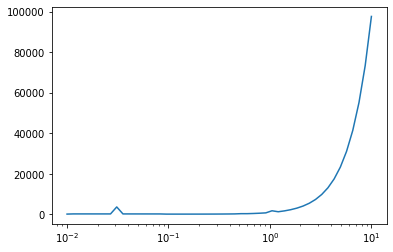

In [125]:
f0 = [(x['f']) for x in profiles[0]]
f0r = [np.exp(-(f0i-min(f0))) for f0i in f0]
plt.semilogx(np.logspace(-2, 1, num=50).flatten(), f0)

In [100]:
list(zip(range(50), np.logspace(-2, 1, num=50),f0r))

[(0, 0.01, DM(6.71594e-07)),
 (1, 0.011513953993264475, DM(4.38142e-45)),
 (2, 0.013257113655901088, DM(7.66425e-45)),
 (3, 0.015264179671752334, DM(1.44617e-44)),
 (4, 0.017575106248547922, DM(2.96877e-44)),
 (5, 0.020235896477251575, DM(6.69053e-44)),
 (6, 0.023299518105153717, DM(1.66976e-43)),
 (7, 0.02682695795279726, DM(4.65636e-43)),
 (8, 0.030888435964774818, DM(0)),
 (9, 0.03556480306223128, DM(5.20354e-42)),
 (10, 0.040949150623804255, DM(2.10543e-41)),
 (11, 0.04714866363457394, DM(9.67273e-41)),
 (12, 0.054286754393238594, DM(5.00772e-40)),
 (13, 0.06250551925273973, DM(2.86983e-39)),
 (14, 0.07196856730011521, DM(1.76412e-38)),
 (15, 0.08286427728546843, DM(1.10531e-37)),
 (16, 0.09540954763499938, DM(0.331159)),
 (17, 0.10985411419875583, DM(0.707001)),
 (18, 0.12648552168552957, DM(1)),
 (19, 0.14563484775012436, DM(0.741689)),
 (20, 0.16768329368110083, DM(0.204725)),
 (21, 0.19306977288832497, DM(0.0142347)),
 (22, 0.22229964825261944, DM(0.000125165)),
 (23, 0.2559547

In [37]:
a0 = linterp(0.011513953993264475, 0.013257113655901088, 0.145754, 0.152931, 0.15)
a1 = linterp( 0.2559547922699536, 0.29470517025518095, 0.314558, 0.115928,  0.15)
a0idx = [1, 2]
a1idx = [23, 24]

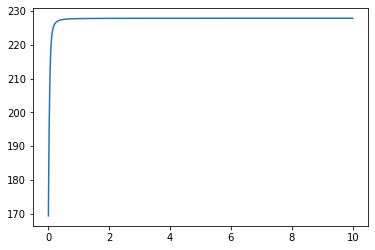

In [101]:
f1 = [(x['f']) for x in profiles[1]]
f1r = [np.exp(-(f1i-min(f1))) for f1i in f1]
plt.plot(np.logspace(-2, 1, num=50).flatten(), f1)

In [102]:
list(zip(range(50), np.logspace(-2, 1, num=50),f1r))

[(0, 0.01, DM(1)),
 (1, 0.011513953993264475, DM(0.0903089)),
 (2, 0.013257113655901088, DM(0.0076637)),
 (3, 0.015264179671752334, DM(0.000598633)),
 (4, 0.017575106248547922, DM(4.16777e-05)),
 (5, 0.020235896477251575, DM(2.49682e-06)),
 (6, 0.023299518105153717, DM(1.24727e-07)),
 (7, 0.02682695795279726, DM(5.07653e-09)),
 (8, 0.030888435964774818, DM(1.6649e-10)),
 (9, 0.03556480306223128, DM(4.42345e-12)),
 (10, 0.040949150623804255, DM(9.79259e-14)),
 (11, 0.04714866363457394, DM(1.92617e-15)),
 (12, 0.054286754393238594, DM(3.80889e-17)),
 (13, 0.06250551925273973, DM(8.97346e-19)),
 (14, 0.07196856730011521, DM(2.94505e-20)),
 (15, 0.08286427728546843, DM(1.54758e-21)),
 (16, 0.09540954763499938, DM(1.4029e-22)),
 (17, 0.10985411419875583, DM(2.1206e-23)),
 (18, 0.12648552168552957, DM(4.89331e-24)),
 (19, 0.14563484775012436, DM(1.57774e-24)),
 (20, 0.16768329368110083, DM(6.61075e-25)),
 (21, 0.19306977288832497, DM(3.39916e-25)),
 (22, 0.22229964825261944, DM(2.0493e-25)),

In [40]:
b0 = linterp(0.6866488450043002, 0.7906043210907697,0.105638 , 0.158776, 0.15)
b1 = linterp(2.8117686979742306,2.8117686979742308, 0.149, 0.151, 0.15)
b0idx = [30, 31]
b1idx = [40, 40]

In [103]:
r0int = [b0/a0, b0/a1, b1/a0, b1/a1]
r0int

[61.651772808241006, 2.6849982819238467, 224.13053183340259, 9.761115787718639]

In [104]:
def gets0(pdx, idx):
    return float(getx(profiles[pdx][idx]['x'])[0][0])
def means0(pdx, idxs):
    return np.mean([gets0(pdx, idx) for idx in idxs])
s0 = [means0(0, a0idx), means0(0, a1idx), means0(1,b0idx), means0(1,b1idx)]
def crossmean(axs, bxs):
    s = []
    for a in axs:
        for b in bxs:
            s.append(np.mean([a, b]))
    return s
s0mean = crossmean(s0[2:], s0[:2])

In [105]:
def rinft(r0,s0):
    f = lambda y: y/s0 - np.exp(r0*(y-s0)/s0) 
    sinf = brentq(f, 0, s0-1) 
    return s0-sinf
[rinft(r0x, s0x) for r0x, s0x in zip(r0int, s0mean)]

[4607.533665189474, 4273.338067959645, 4600.628260130881, 4667.860946881855]

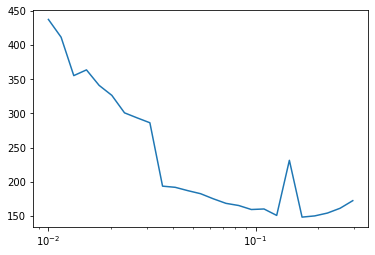

In [106]:
f2 = [(x['f']) for x in profiles[2]]
plt.semilogx(np.logspace(-2, 1, num=50).flatten()[:25], f2[:25])

In [107]:
def mod_seir(t, y, p):
    for i, yi in enumerate(y):
        if yi < 0:
            y[i] = 0 
    return seir(t, y, p)

In [108]:
from scipy.integrate import solve_ivp
idx = 50
tidx = 45
print(model.observation_times[tidx])
sol = solve_ivp(lambda t,y: mod_seir(t, y, getp(sols[idx]['x'])), [0, 150], [getx(sols[idx]['x'])[i][tidx] for i in range(5)], dense_output=True)
solb = solve_ivp(lambda t,y: np.array(mod_seir(t, y, getp(sols[idx]['x']))), [0, -20], [getx(sols[idx]['x'])[i][tidx] for i in range(5)], method='BDF', dense_output=True)

77.0909090909091


In [109]:
[getx(sols[idx]['x'])[i][tidx] for i in range(5)]

[DM(3991.12), DM(200.475), DM(101.39), DM(137.014), DM(748.494)]

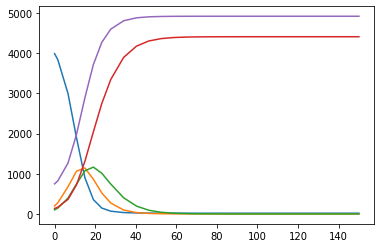

In [110]:
plt.plot(sol.t, sol.y[:,:].T)

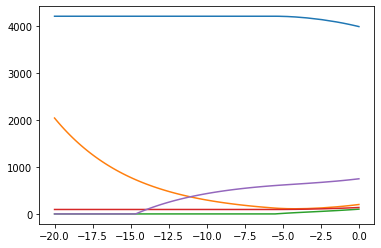

In [111]:
plt.plot(solb.t, solb.y.T)

In [112]:
model.observation_times[-1]

130.0

Text(0.5, 1.0, 'Number of Reported Cases (Prediction)')

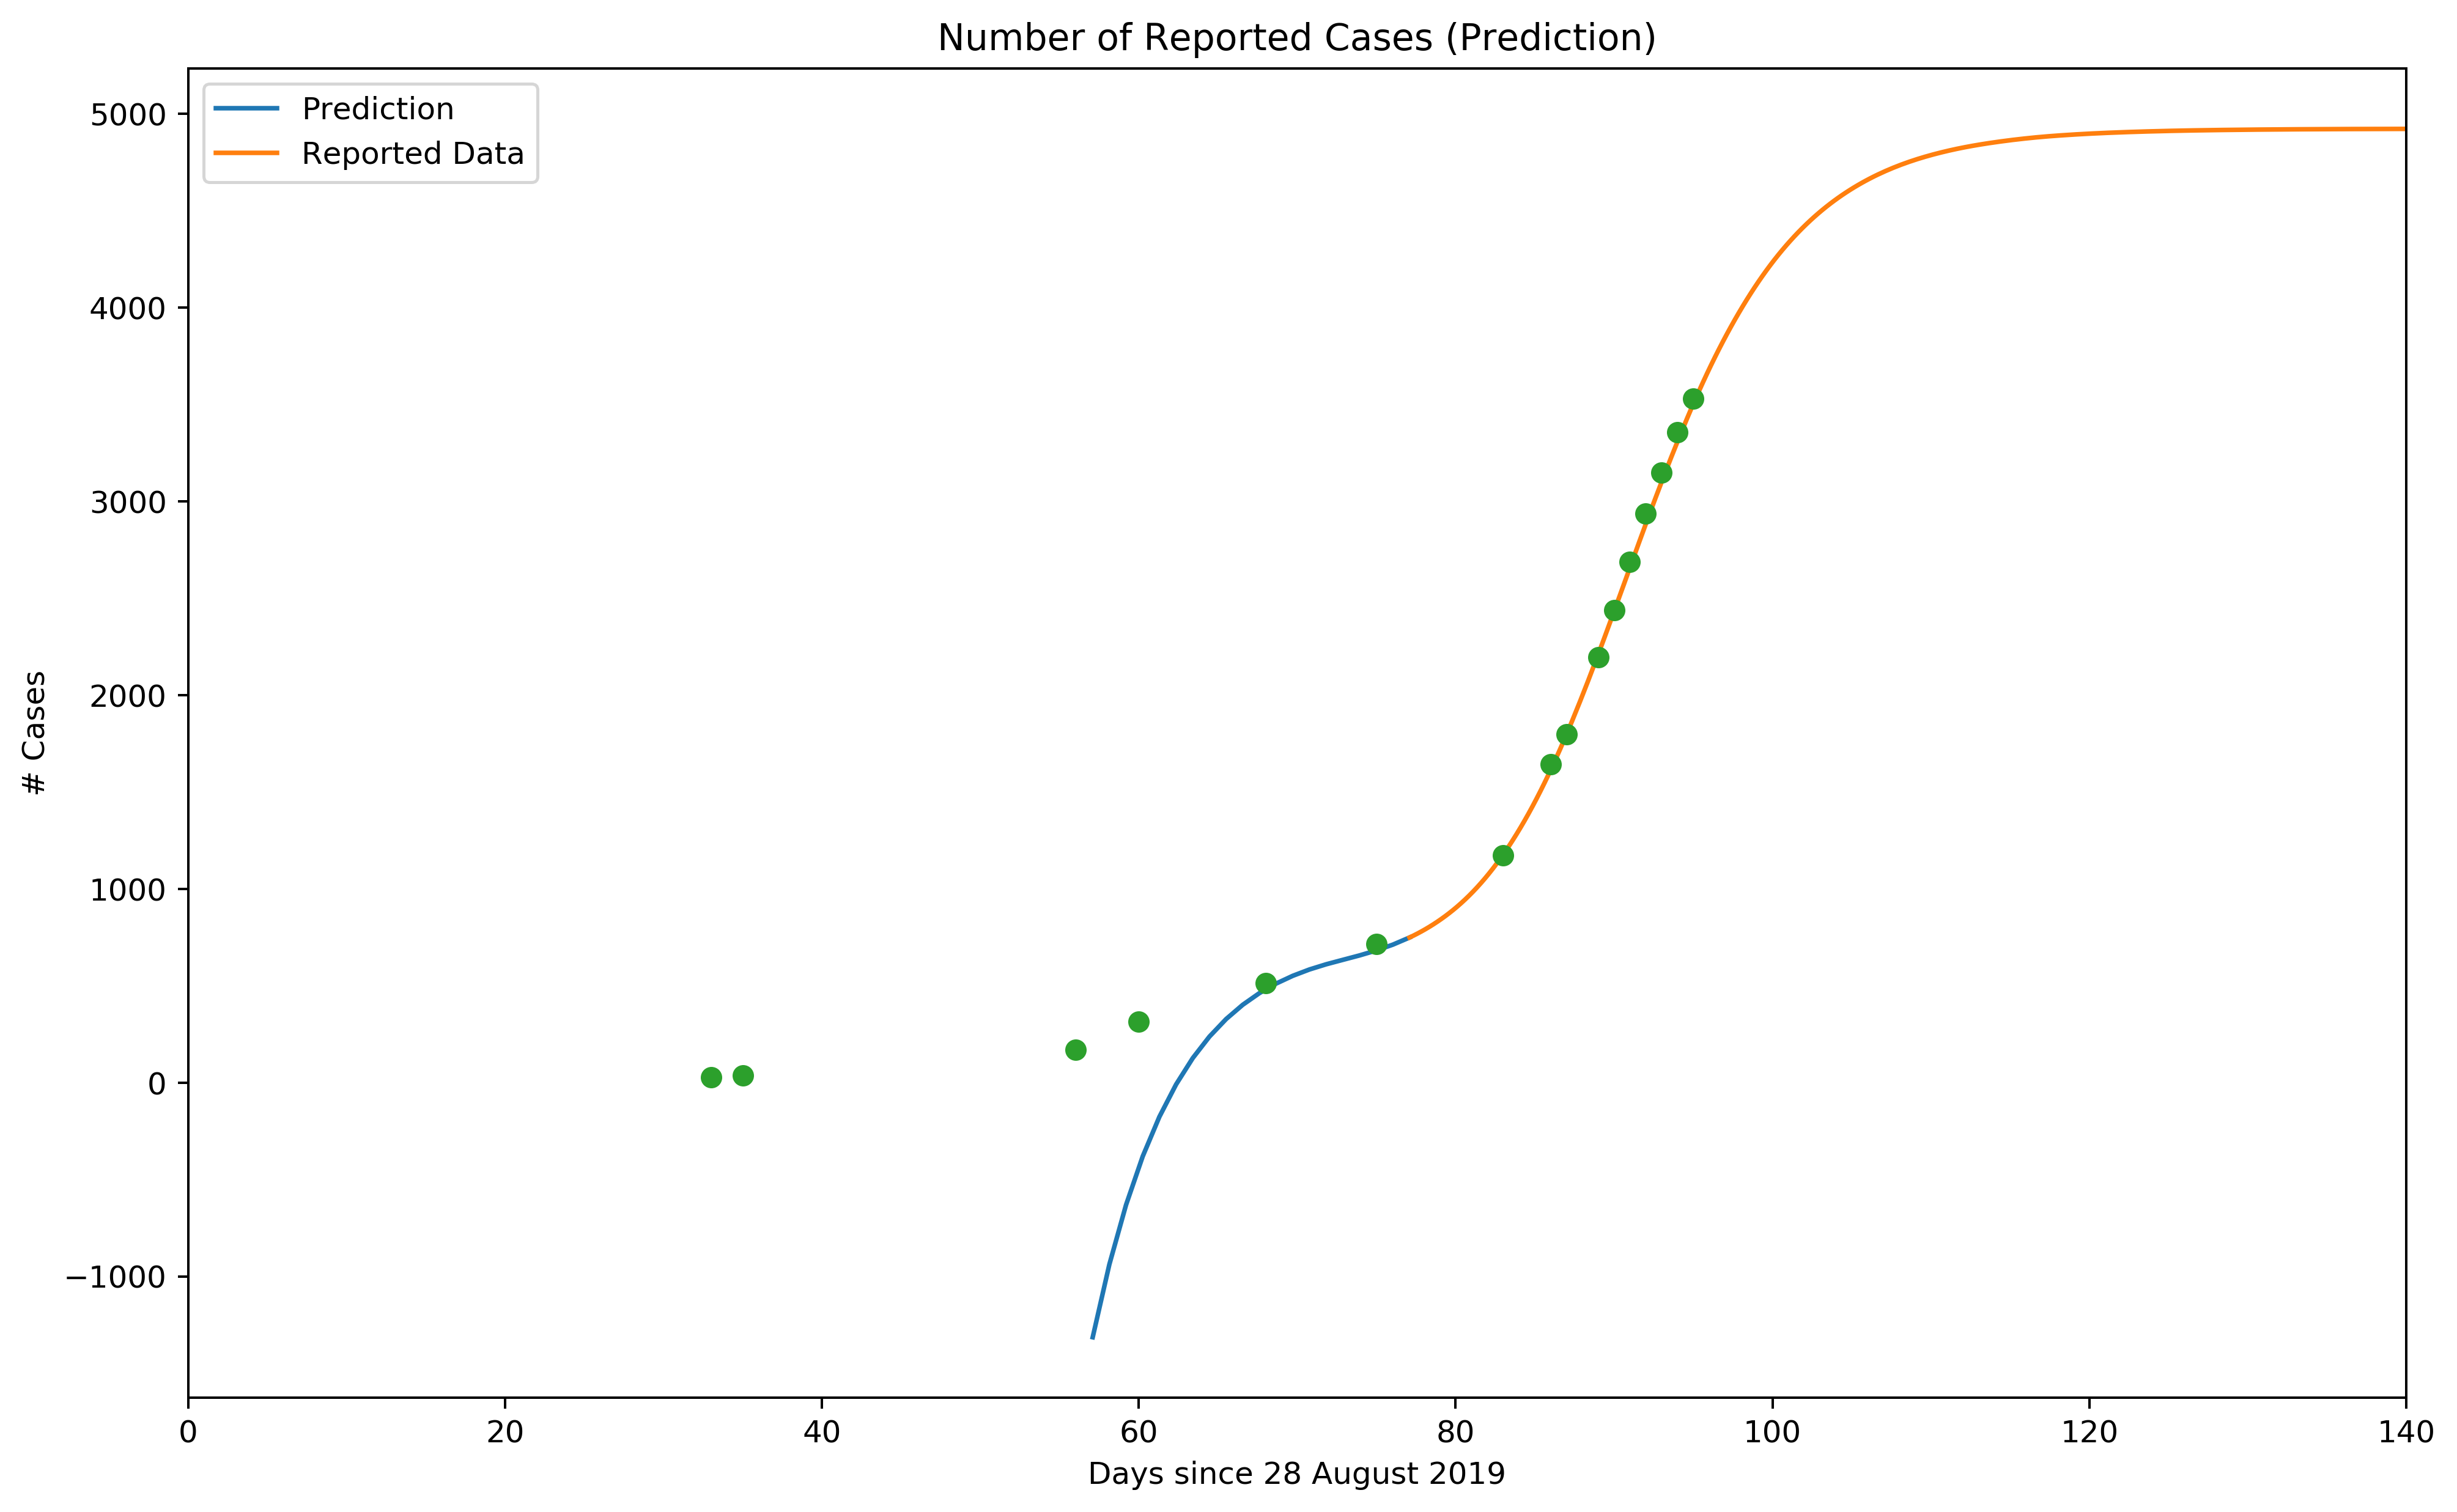

In [113]:
tfine = np.linspace(0, 150, 600)
tbfine = np.linspace(0, -20, 20)
plt.figure(figsize=[13, 8], dpi=360)
plt.plot(tbfine+model.observation_times[tidx], solb.sol(tbfine)[-1,:].T)
plt.plot(tfine+model.observation_times[tidx], sol.sol(tfine)[-1,:].T)
plt.plot(additional_times, additional_cumdata, 'o')
plt.xlim(0, 140)
plt.legend(["Prediction", "Reported Data"])
plt.xlabel("Days since 28 August 2019")
plt.ylabel("# Cases")
plt.title("Number of Reported Cases (Prediction)")

In [114]:
rfin = sol.sol(tfine)[-1,-1]

In [115]:
ridx = np.argmin(np.abs(((1-(sol.sol(tfine)[-1,:])/rfin)*100) - 5))

In [116]:
tfine[ridx]

29.29883138564274

In [117]:
tfine[ridx]-(model.observation_times[-1]-model.observation_times[tidx])

-23.610259523448168

In [118]:
model.observation_times[-1]-model.observation_times[tidx]

52.90909090909091

In [119]:
historical_mortality = 0.02
current_mortality = 39/2936
print(historical_mortality, current_mortality)

0.02 0.013283378746594006


In [120]:
rfin*historical_mortality

98.45127973570617

In [121]:
rfin*current_mortality

65.38828184081301